# Bayesian Optimization Pythia Tune using Ax
> Created: May 24 2024 AAK, Harrison B. Prosper

## Running the notebook
All code and program dependencies such as pythia, rivet, hepmc, Ax are preinstalled on the docker image `alialkadhim/pythia_sbi_tune:latest`. Here is how to install the image and run this notebook:

```
git clone https://github.com/AliAlkadhim/Pythia8_SBI_Tune.git
```
Then,
```
cd Pythia8_SBI_Tune/code/BayesOpt
bash docker_run.sh
```

Then, inside the docker container, do

```
jupyter-lab --ip 0.0.0.0 --port 8889 --allow-root &
```

Now copy and paste the link displayed at the bottom of the terminal to your browser

----

This notebook performs Bayesian Optimizaion using [Ax](https://github.com/facebook/Ax) of the Lund string model parameters $a$ and $b$ that appear in the fragmentation function

$$
f_{\text{Lund}}(z) \propto \frac{(1-z)^a}{z} \exp \left(-\frac{b m_{\perp}^2}{z}\right)
$$

which are referred to as `StringZ:aLund` and `StringZ:bLund` in pythia8, respectively.

We use the data from `ALEPH_1996_S3486095` from the paper ["Studies of quantum chromodynamics with the ALEPH detector"](https://www.sciencedirect.com/science/article/pii/S0370157397000458)


## Key Observations
The default values of these parameters in pythia is due to the [Monash Tune](https://arxiv.org/pdf/1404.5630.pdf). Other papers have corroborated the results of that tune and attained similar values for some of the parameters. Therefore, when performing the Bayesian Optimization, we want to take that into account by forcing the algorithm to sample the Monash tune point. Observe how with few number of iterations, while forcing the sobol quasirandom sampling to explore the Monash tune, we will most likely end up with the Monash tune as the best-fit point. However, when we increase the number of iterations, we arrive at a tune that is slightly different than the Monash tune.

In [1]:
import os, sys, re
import numpy as np
import pandas as pd
import matplotlib as mp
import matplotlib.pyplot as plt
import importlib

from bayes_opt import BayesianOptimization, UtilityFunction 


from ax.service.ax_client import AxClient, ObjectiveProperties
from ax.utils.measurement.synthetic_functions import hartmann6
from ax.utils.notebook.plotting import init_notebook_plotting, render


# init_notebook_plotting()
# import plotly.io as pio
# pio.renderers.default = "jupyterlab"


#`source /cvmfs/sft.cern.ch/lcg/views/LCG_102/x86_64-centos7-gcc11-opt/setup.sh`
from glob import glob
from tqdm import tqdm
import yoda2numpy_BayesOpt
from yoda2numpy_BayesOpt import Yoda2Numpy

import pythia_SBI_utils
from pythia_SBI_utils import *

FONTSIZE = 14
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : FONTSIZE}
mp.rc('font', **font)

# set usetex = False if LaTex is not 
# available on your system or if the 
# rendering is too slow
mp.rc('text', usetex=True)

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
BAYES_OPT=False
AX=True

In [19]:
def make_pythia_card(aLund, 
                     bLund,
                    rFactC,
                    rFactB,
                    aExtraSQuark,
                    aExtraDiquark,
                    sigma,
                    enhancedFraction,
                    enhancedWidth,
                    ProbStoUD,
                    probQQtoQ,
                    probSQtoQQ,
                    ProbQQ1toQQ0,
                    alphaSvalue,
                    pTmin):
    
    cards_dir = os.path.join(os.getcwd(), "BO_Cards")
    filename = f"ALEPH_1996_S3486095_BO_card.cmnd"
    file_path = os.path.join(cards_dir, filename)
    with open(file_path,'w') as f:
        first_block="""Main:numberOfEvents = 300000          ! number of events to generate
Next:numberShowEvent = 0           ! suppress full listing of first events
# random seed
Random:setSeed = on
Random:seed= 0
! 2) Beam parameter settings.
Beams:idA = 11                ! first beam,  e- = 11
Beams:idB = -11                ! second beam, e+ = -11
Beams:eCM = 91.2               ! CM energy of collision
# Pythia 8 settings for LEP
# Hadronic decays including b quarks, with ISR photons switched off
WeakSingleBoson:ffbar2gmZ = on
23:onMode = off
23:onIfAny = 1 2 3 4 5
PDF:lepton = off
SpaceShower:QEDshowerByL = off\n\n"""
        f.write(first_block)
        # f.write(f"Random:seed={indx+1}")
        f.write(f"StringZ:aLund = {aLund}\n\n")
        f.write(f"StringZ:bLund = {bLund}\n\n")
        f.write(f"StringZ:rFactC = {rFactC}\n\n")
        f.write(f"StringZ:rFactC = {rFactB}\n\n")
        f.write(f"StringZ:rFactC = {aExtraSQuark}\n\n")
        f.write(f"StringZ:rFactC = {aExtraDiquark}\n\n")
        f.write(f"StringPT:sigma = {sigma}\n\n")
        f.write(f"StringPT:enhancedFraction = {enhancedFraction}\n\n")
        f.write(f"StringPT:enhancedWidth = {enhancedWidth}\n\n")
        f.write(f"StringFlav:ProbStoUD = {ProbStoUD}\n\n")
        f.write(f"StringFlav:probQQtoQ = {probQQtoQ}\n\n")
        f.write(f"StringFlav:probSQtoQQ = {probSQtoQQ}\n\n")
        f.write(f"StringFlav:ProbQQ1toQQ0 = {ProbQQ1toQQ0}\n\n")
        f.write(f"TimeShower:alphaSvalue = {alphaSvalue}\n\n")
        f.write(f"TimeShower:pTmin = {pTmin}\n\n")
        



MONASH_DICT = {
    "aLund" : 0.68, 
    "bLund" : 0.98,
    "rFactC": 1.32,
    "rFactB":0.855,
    "aExtraSQuark": 0.0,
    "aExtraDiquark":0.97,
    "sigma":0.335,
    "enhancedFraction":0.01,
    "enhancedWidth":2.0,
    "ProbStoUD":0.217,
    "probQQtoQ":0.081,
    "probSQtoQQ":0.915,
    "ProbQQ1toQQ0": 0.0275,
    "alphaSvalue": 0.1365,
    "pTmin": 0.5
}

def get_pbounds(PARAM_DICT):
    pbounds = {}
    for key, value in PARAM_DICT.items():
        p_name = key.split(':')[1]
        p_bound = tuple(value)
        pbounds[p_name] = p_bound
    return pbounds

## Considererations for Data and Effective counts
Notice (unfortunately) that the total effective counts for every histogram is different! This is a huge complication because, in principle, we would need to generate different numbers of events for every histogram. But, as is true of much of what we do in science, we should make some simplifying assumptions to reduce to complexity of the problem. 

**Assumptions**

  1. Since we are not given correlation matrices for the measured cross sections, we assume that the bin-by-bin cross section measurements are conditionally independent: given fixed values of the tune parameters the measured cross sections are statistically independent.
  2. The counts per bin are Poisson-distributed and the cross sections are just scaled values of the counts.  We can, therefore, compute the effective count in each bin using the following *ansatz*
\begin{align}
    n_i & = k_i \sigma_i,\\
    \sqrt{n_i} & = k_i \delta \sigma_i \quad \text{and, therefore, }\\
    n_i & = \left( \frac{\sigma_i}{\delta\sigma_i} \right)^2 ,
\end{align}
where $\sigma_i \pm \delta\sigma_i$ is the measured cross section in bin $i$ and $k_i$, the *effective integrated luminosity*, is the product $\epsilon_i {\cal L}$ of the efficiency times acceptance, $\epsilon_i$, and  the integrated luminosity ${\cal L}$. The total effective count for a histogram is then just $n = \sum_{i} n_i$.

Therefore, for each tune parameter point, a sufficiently large sample of simulated events will result in histograms that serve both as the predictions as well as the basis for simulating events counts in all the simulated "observed" histograms. Given our assumptions, we can write down an approximation of the statistical model, $p(X | \theta)$, where $X$ are *potentially observable* counts and $\theta$ are the tune parameters. With the assumptions above, the statistical model for the $\texttt{ALEPH}$ data can be approximated as a product of either gamma or Gaussian densities depending on the size of the effective bin counts. We see that about 300,000 events need to be simulated per point in order to match the statistical precision of the data.

## .yoda format
The .yoda histograms for the data look like:

```
# xval	 xerr-	 xerr+	 yval	 yerr-	 yerr+
```
`xval` is the bin center, while `yval` is the height of the bin center. `xerr-=xerr+` is the positive and uncertainties in the bin center location, and `yerr-=yerr+` is the uncertainty in the height.

The data recorded is the cross section. so let's call that cross section in bin i $\hat{\sigma}_i^{Data} =yval$ and the uncertainty in bin i $\Delta^{Data}_i = yerr-$ . 


while the simulation histograms look like:
```
xlow	 xhigh	 sumw	 sumw2	 sumwx	 sumwx2	 numEntries
```

`xlow` is the left edge and `xhigh` is the right edge for a bin $i$. `sumw` is the sum of weights per bin $i$ $sumw^{bin, i} \sum_{k=1}^{N_{counts \ in \ bin \ i}} w_k^{bin \ i}$ and `sumw2` is sum of weights squared $sumw2^{bin \ i}=\sum_{k=1}^{N_{counts \ in \ bin \ i}} (w_k^{bin \ i})^2$ . To convert to differential cross section we divide by the bin widths, i.e. we calculate $\Delta x = xhigh-xlow$ and divide $\hat{\sigma}_i^{MC} = sumw/\Delta x$ and $sumw2/\Delta x ^2$ and $sumwx/\Delta x$ and $sumwx2/Delta x^2$ . Then the MC error for the cross section per bin is $\Delta_i^{MC} =\sqrt{sumw2/\Delta x ^2}$ 

We can write the effective count can be as
$$\frac{\sqrt{\sum_i w_i^2}}{\sum_i w_i}=\frac{1}{\sqrt{N_{e f f}}}$$
So 
$$N_{eff,\ i} = \left( \frac{\sum_i w_i }{\sqrt{\sum_i w_i^2 } } \right)^2 = \left( \frac{\sum_i w_i}{\Delta_{i, MC}} \right)^2$$
Therefore the scale factor per bin is

$$K_i = \frac{\sum_i w_i}{\sum_i w_i^2 }= \frac{\sum_i w_i}{\Delta_{i,MC}^2}$$

------

We use the following test statistic
$$
    \lambda(X; \theta) = \sqrt{\frac{1}{N}\sum_\text{histograms} \sum_i \left( \frac{D_i - T_i(\theta)}{\delta_i} \right)^2},
$$
where $N$ is the total number of bins summed over histograms and $\delta_i^2$ is the sum of the variances associated with the data $D_i$ and the theoretical prediction $T_i$ with the latter obtained via Monte Carlo simulation.

In [20]:
def true_objective_func(aLund, 
                     bLund,
                    rFactC,
                    rFactB,
                    aExtraSQuark,
                    aExtraDiquark,
                    sigma,
                    enhancedFraction,
                    enhancedWidth,
                    ProbStoUD,
                    probQQtoQ,
                    probSQtoQQ,
                    ProbQQ1toQQ0,
                    alphaSvalue,
                    pTmin):
    
    # step 1: write .cmnd file 
    make_pythia_card(aLund, 
                     bLund,
                    rFactC,
                    rFactB,
                    aExtraSQuark,
                    aExtraDiquark,
                    sigma,
                    enhancedFraction,
                    enhancedWidth,
                    ProbStoUD,
                    probQQtoQ,
                    probSQtoQQ,
                    ProbQQ1toQQ0,
                    alphaSvalue,
                    pTmin)
    #step 2 run main42 and rivet
    os.system("""./main42 BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd ALEPH_1996_S3486095_card.fifo &
    
    rivet -o ALEPH_1996_S3486095_hist_0.yoda -a ALEPH_1996_S3486095 ALEPH_1996_S3486095_card.fifo

    rm ALEPH_1996_S3486095_card.fifo
    mv ALEPH_1996_S3486095_hist_0.yoda ALEPH_YODAS_BayesOpt/""")
    
    
    dfdata, dfsims, generated_indices = get_data()
    print('DATA DATAFRAME')
    print(dfdata['/REF/ALEPH_1996_S3486095/d01-x01-y01'].head())
    print('FIRST SIM DATAFRAME')
    print(dfsims[generated_indices[0]]['/ALEPH_1996_S3486095/d01-x01-y01'].head())
    
    data_keys, mc_keys = get_hist_names(dfdata)

    filtered_data_keys, filtered_mc_keys = filter_keys(dfdata, dfsims, data_keys, mc_keys)
    X0 = {}
    for ii, gen_ind in enumerate(generated_indices):
        # X0.append(test_statistic(filtered_data_keys,filtered_mc_keys, dfdata, dfsims[gen_ind], which = 0))
        # try:
        #     X0.append(test_statistic(filtered_data_keys,filtered_mc_keys, dfdata, dfsims[ii], which = 0))
        try:
            X0[gen_ind] = test_statistic(filtered_data_keys,filtered_mc_keys, dfdata, dfsims[gen_ind], which = 0)
        except Exception:
            print('test statistic error in file index: ', gen_ind)
            
    if BAYES_OPT:        
        objective_func = - X0[0]
    else:
        objective_func = X0[0]
    os.system("rm ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda")
        
    print(f"objective function = {objective_func}")
    return objective_func

In [ ]:
PARAM_DICT = {
        'StringZ:aLund' : [0.0, 2.0],
        'StringZ:bLund': [0.2, 2.0],
        'StringZ:rFactC':[0.0, 2.0],
        'StringZ:rFactB': [0., 2.0],
        'StringZ:aExtraSQuark':[0.,2.],
        'StringZ:aExtraDiquark':[0.,2.],
        'StringPT:sigma':[0.,1.],
        'StringPT:enhancedFraction':[0.,1.],
        'StringPT:enhancedWidth':[1.0,4.0],
        'StringFlav:ProbStoUD':[0,4.0],
        'StringFlav:probQQtoQ':[0,4.0],
        'StringFlav:probSQtoQQ':[0,4.0],
        'StringFlav:ProbQQ1toQQ0':[0,4.0],
        'TimeShower:alphaSvalue':[0.06,0.25],
        'TimeShower:pTmin':[0.1,2.0]


}

ax_client = AxClient()
ax_client.create_experiment(
name="Ax_Tune_Pythia",
        parameters = [
                    {
                        "name": "aLund",
                        "type": "range",
                        "bounds": [0.0, 2.0],
                    }, 
                    {
                        "name": "bLund",
                        "type": "range",
                        "bounds": [0.2, 2.0],
                    },
                    {
                        "name": "rFactC",
                        "type": "range",
                        "bounds": [0.0, 2.0],
                    }, 
                    {
                        "name": "rFactB",
                        "type": "range",
                        "bounds": [0.0, 2.0],
                    }, 
                    {
                        "name": "aExtraSQuark",
                        "type": "range",
                        "bounds": [0.0, 2.0],
                    }, 
                    {
                        "name": "aExtraDiquark",
                        "type": "range",
                        "bounds": [0.0, 2.0],
                    }, 
                    {
                        "name": "sigma",
                        "type": "range",
                        "bounds": [0.,1.],
                    }, 
                    {
                        "name": "enhancedFraction",
                        "type": "range",
                        "bounds": [0.,1.],
                    }, 
                    {
                        "name": "enhancedWidth",
                        "type": "range",
                        "bounds": [1.0,4.0],
                    }, 
                    {
                        "name": "ProbStoUD",
                        "type": "range",
                        "value_type": "float",
                        "bounds": [0,4.0],
                    }, 
                    {
                        "name": "probQQtoQ",
                        "type": "range",
                        "value_type": "float",
                        "bounds": [0,4.0],
                    }, 
                    {
                        "name": "probSQtoQQ",
                        "type": "range",
                        "value_type": "float",
                        "bounds": [0,4.0],
                    }, 
                    {
                        "name": "ProbQQ1toQQ0",
                        "type": "range",
                        "value_type": "float",
                        "bounds": [0,4.0],
                    }, 
                    {
                        "name": "alphaSvalue",
                        "type": "range",
                        "value_type": "float",
                        "bounds": [0.06,0.25],
                    }, 
                    {
                        "name": "pTmin",
                        "type": "range",
                        "value_type": "float",
                        "bounds": [0.1,2.0],
                    }, 
            
                ],
objectives = {"true_objective_func": ObjectiveProperties(minimize=True)},
)

# Sample Monash Tune point
suggest_param, suggest_ind = ax_client.attach_trial(
    parameters=MONASH_DICT
)
ax_client.complete_trial(trial_index=suggest_ind, raw_data=true_objective_func(
        aLund=suggest_param["aLund"], 
        bLund=suggest_param["bLund"],
        rFactC=suggest_param["rFactC"],
        rFactB=suggest_param["rFactB"],
        aExtraSQuark=suggest_param["aExtraSQuark"],
        aExtraDiquark=suggest_param["aExtraDiquark"],
        sigma=suggest_param["sigma"],
        enhancedFraction=suggest_param["enhancedFraction"],
        enhancedWidth=suggest_param["enhancedWidth"],
        ProbStoUD=suggest_param["ProbStoUD"],
        probQQtoQ=suggest_param["probQQtoQ"],
        probSQtoQQ=suggest_param["probSQtoQQ"],
        ProbQQ1toQQ0=suggest_param["ProbQQ1toQQ0"],
        alphaSvalue=suggest_param["alphaSvalue"],
        pTmin=suggest_param["pTmin"]
))


N_ITER = 8
for i in range(N_ITER):
    parameterization, trial_index = ax_client.get_next_trial()
    print(parameterization)
    ax_client.complete_trial(trial_index=trial_index, raw_data=true_objective_func(
        aLund=parameterization["aLund"], 
        bLund=parameterization["bLund"],
        rFactC=parameterization["rFactC"],
        rFactB=parameterization["rFactB"],
        aExtraSQuark=parameterization["aExtraSQuark"],
        aExtraDiquark=parameterization["aExtraDiquark"],
        sigma=parameterization["sigma"],
        enhancedFraction=parameterization["enhancedFraction"],
        enhancedWidth=parameterization["enhancedWidth"],
        ProbStoUD=parameterization["ProbStoUD"],
        probQQtoQ=parameterization["probQQtoQ"],
        probSQtoQQ=parameterization["probSQtoQQ"],
        ProbQQ1toQQ0=parameterization["ProbQQ1toQQ0"],
        alphaSvalue=parameterization["alphaSvalue"],
        pTmin=parameterization["pTmin"]
    ))



[INFO 05-27 19:12:16] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 6 decimal points.
[INFO 05-27 19:12:16] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter aLund. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 05-27 19:12:16] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter bLund. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 05-27 19:12:16] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter rFactC. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 05-27 19:12:16] a


 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |   P       Y      T    

Rivet 3.1.9 running on machine 99deb7ce41f6 (x86_64) at 2024-05-27 19:12:17
Reading events from 'ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:01 elapsed)
Event 200 (0:00:01 elapsed)
Event 300 (0:00:01 elapsed)
Event 400 (0:00:01 elapsed)
Event 500 (0:00:01 elapsed)
Event 600 (0:00:01 elapsed)
Event 700 (0:00:01 elapsed)



 Pythia::next(): 3000 events have been generated 


Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:02 elapsed)
Event 1300 (0:00:02 elapsed)
Event 1400 (0:00:02 elapsed)
Event 1500 (0:00:02 elapsed)
Event 1600 (0:00:02 elapsed)



 Pythia::next(): 4000 events have been generated 


Event 1700 (0:00:02 elapsed)
Event 1800 (0:00:02 elapsed)
Event 1900 (0:00:02 elapsed)
Event 2000 (0:00:03 elapsed)
Event 2100 (0:00:03 elapsed)
Event 2200 (0:00:03 elapsed)
Event 2300 (0:00:03 elapsed)



 Pythia::next(): 5000 events have been generated 


Event 2400 (0:00:03 elapsed)
Event 2500 (0:00:03 elapsed)
Event 2600 (0:00:03 elapsed)
Event 2700 (0:00:03 elapsed)
Event 2800 (0:00:03 elapsed)
Event 2900 (0:00:03 elapsed)
Event 3000 (0:00:03 elapsed)
Event 3100 (0:00:04 elapsed)
Event 3200 (0:00:04 elapsed)
Event 3300 (0:00:04 elapsed)
Event 3400 (0:00:04 elapsed)



 Pythia::next(): 6000 events have been generated 


Event 3500 (0:00:04 elapsed)
Event 3600 (0:00:04 elapsed)
Event 3700 (0:00:04 elapsed)
Event 3800 (0:00:04 elapsed)
Event 3900 (0:00:04 elapsed)
Event 4000 (0:00:05 elapsed)



 Pythia::next(): 7000 events have been generated 


Event 4100 (0:00:05 elapsed)
Event 4200 (0:00:05 elapsed)
Event 4300 (0:00:05 elapsed)
Event 4400 (0:00:05 elapsed)
Event 4500 (0:00:05 elapsed)
Event 4600 (0:00:05 elapsed)
Event 4700 (0:00:05 elapsed)
Event 4800 (0:00:05 elapsed)
Event 4900 (0:00:05 elapsed)



 Pythia::next(): 8000 events have been generated 


Event 5000 (0:00:06 elapsed)
Event 5100 (0:00:06 elapsed)
Event 5200 (0:00:06 elapsed)
Event 5300 (0:00:06 elapsed)
Event 5400 (0:00:06 elapsed)
Event 5500 (0:00:06 elapsed)
Event 5600 (0:00:06 elapsed)
Event 5700 (0:00:06 elapsed)



 Pythia::next(): 9000 events have been generated 


Event 5800 (0:00:06 elapsed)
Event 5900 (0:00:06 elapsed)
Event 6000 (0:00:07 elapsed)
Event 6100 (0:00:07 elapsed)
Event 6200 (0:00:07 elapsed)
Event 6300 (0:00:07 elapsed)
Event 6400 (0:00:07 elapsed)
Event 6500 (0:00:07 elapsed)
Event 6600 (0:00:07 elapsed)



 Pythia::next(): 10000 events have been generated 


Event 6700 (0:00:07 elapsed)
Event 6800 (0:00:07 elapsed)
Event 6900 (0:00:07 elapsed)
Event 7000 (0:00:08 elapsed)
Event 7100 (0:00:08 elapsed)
Event 7200 (0:00:08 elapsed)
Event 7300 (0:00:08 elapsed)
Event 7400 (0:00:08 elapsed)



 Pythia::next(): 11000 events have been generated 


Event 7500 (0:00:08 elapsed)
Event 7600 (0:00:08 elapsed)
Event 7700 (0:00:08 elapsed)
Event 7800 (0:00:09 elapsed)
Event 7900 (0:00:09 elapsed)
Event 8000 (0:00:09 elapsed)
Event 8100 (0:00:09 elapsed)
Event 8200 (0:00:09 elapsed)
Event 8300 (0:00:09 elapsed)



 Pythia::next(): 12000 events have been generated 


Event 8400 (0:00:09 elapsed)
Event 8500 (0:00:09 elapsed)
Event 8600 (0:00:09 elapsed)
Event 8700 (0:00:09 elapsed)
Event 8800 (0:00:09 elapsed)
Event 8900 (0:00:10 elapsed)
Event 9000 (0:00:10 elapsed)
Event 9100 (0:00:10 elapsed)
Event 9200 (0:00:10 elapsed)



 Pythia::next(): 13000 events have been generated 


Event 9300 (0:00:10 elapsed)
Event 9400 (0:00:10 elapsed)
Event 9500 (0:00:10 elapsed)
Event 9600 (0:00:10 elapsed)
Event 9700 (0:00:10 elapsed)
Event 9800 (0:00:10 elapsed)
Event 9900 (0:00:10 elapsed)
Event 10000 (0:00:11 elapsed)
Event 10100 (0:00:11 elapsed)



 Pythia::next(): 14000 events have been generated 


Event 10200 (0:00:11 elapsed)
Event 10300 (0:00:11 elapsed)
Event 10400 (0:00:11 elapsed)
Event 10500 (0:00:11 elapsed)
Event 10600 (0:00:11 elapsed)
Event 10700 (0:00:11 elapsed)
Event 10800 (0:00:11 elapsed)
Event 10900 (0:00:11 elapsed)
Event 11000 (0:00:11 elapsed)



 Pythia::next(): 15000 events have been generated 


Event 11100 (0:00:12 elapsed)
Event 11200 (0:00:12 elapsed)
Event 11300 (0:00:12 elapsed)
Event 11400 (0:00:12 elapsed)
Event 11500 (0:00:12 elapsed)
Event 11600 (0:00:12 elapsed)



 Pythia::next(): 16000 events have been generated 
 PYTHIA Error in StringFragmentation::fragment: stuck in joining  
 PYTHIA Error in Pythia::next: hadronLevel failed; try again  


Event 11700 (0:00:12 elapsed)
Event 11800 (0:00:12 elapsed)
Event 11900 (0:00:12 elapsed)
Event 12000 (0:00:12 elapsed)
Event 12100 (0:00:12 elapsed)
Event 12200 (0:00:13 elapsed)
Event 12300 (0:00:13 elapsed)
Event 12400 (0:00:13 elapsed)
Event 12500 (0:00:13 elapsed)
Event 12600 (0:00:13 elapsed)
Event 12700 (0:00:13 elapsed)



 Pythia::next(): 17000 events have been generated 


Event 12800 (0:00:13 elapsed)
Event 12900 (0:00:13 elapsed)
Event 13000 (0:00:13 elapsed)
Event 13100 (0:00:13 elapsed)
Event 13200 (0:00:14 elapsed)
Event 13300 (0:00:14 elapsed)
Event 13400 (0:00:14 elapsed)



 Pythia::next(): 18000 events have been generated 


Event 13500 (0:00:14 elapsed)
Event 13600 (0:00:14 elapsed)
Event 13700 (0:00:14 elapsed)
Event 13800 (0:00:14 elapsed)
Event 13900 (0:00:14 elapsed)
Event 14000 (0:00:14 elapsed)
Event 14100 (0:00:15 elapsed)
Event 14200 (0:00:15 elapsed)



 Pythia::next(): 19000 events have been generated 


Event 14300 (0:00:15 elapsed)
Event 14400 (0:00:15 elapsed)
Event 14500 (0:00:15 elapsed)
Event 14600 (0:00:15 elapsed)
Event 14700 (0:00:15 elapsed)
Event 14800 (0:00:15 elapsed)
Event 14900 (0:00:15 elapsed)
Event 15000 (0:00:15 elapsed)
Event 15100 (0:00:16 elapsed)



 Pythia::next(): 20000 events have been generated 


Event 15200 (0:00:16 elapsed)
Event 15300 (0:00:16 elapsed)
Event 15400 (0:00:16 elapsed)
Event 15500 (0:00:16 elapsed)
Event 15600 (0:00:16 elapsed)
Event 15700 (0:00:16 elapsed)
Event 15800 (0:00:16 elapsed)
Event 15900 (0:00:16 elapsed)



 Pythia::next(): 21000 events have been generated 


Event 16000 (0:00:16 elapsed)
Event 16100 (0:00:17 elapsed)
Event 16200 (0:00:17 elapsed)
Event 16300 (0:00:17 elapsed)
Event 16400 (0:00:17 elapsed)
Event 16500 (0:00:17 elapsed)
Event 16600 (0:00:17 elapsed)
Event 16700 (0:00:17 elapsed)
Event 16800 (0:00:17 elapsed)



 Pythia::next(): 22000 events have been generated 


Event 16900 (0:00:17 elapsed)
Event 17000 (0:00:17 elapsed)
Event 17100 (0:00:18 elapsed)
Event 17200 (0:00:18 elapsed)
Event 17300 (0:00:18 elapsed)
Event 17400 (0:00:18 elapsed)
Event 17500 (0:00:18 elapsed)
Event 17600 (0:00:18 elapsed)
Event 17700 (0:00:18 elapsed)



 Pythia::next(): 23000 events have been generated 


Event 17800 (0:00:18 elapsed)
Event 17900 (0:00:18 elapsed)
Event 18000 (0:00:18 elapsed)
Event 18100 (0:00:18 elapsed)
Event 18200 (0:00:19 elapsed)
Event 18300 (0:00:19 elapsed)
Event 18400 (0:00:19 elapsed)
Event 18500 (0:00:19 elapsed)
Event 18600 (0:00:19 elapsed)



 Pythia::next(): 24000 events have been generated 


Event 18700 (0:00:19 elapsed)
Event 18800 (0:00:19 elapsed)
Event 18900 (0:00:19 elapsed)
Event 19000 (0:00:19 elapsed)
Event 19100 (0:00:19 elapsed)
Event 19200 (0:00:19 elapsed)
Event 19300 (0:00:20 elapsed)
Event 19400 (0:00:20 elapsed)
Event 19500 (0:00:20 elapsed)



 Pythia::next(): 25000 events have been generated 


Event 19600 (0:00:20 elapsed)
Event 19700 (0:00:20 elapsed)
Event 19800 (0:00:20 elapsed)
Event 19900 (0:00:20 elapsed)
Event 20000 (0:00:20 elapsed)
Event 20100 (0:00:20 elapsed)
Event 20200 (0:00:20 elapsed)
Event 20300 (0:00:20 elapsed)
Event 20400 (0:00:21 elapsed)



 Pythia::next(): 26000 events have been generated 


Event 20500 (0:00:21 elapsed)
Event 20600 (0:00:21 elapsed)
Event 20700 (0:00:21 elapsed)
Event 20800 (0:00:21 elapsed)
Event 20900 (0:00:21 elapsed)
Event 21000 (0:00:21 elapsed)
Event 21100 (0:00:21 elapsed)
Event 21200 (0:00:21 elapsed)



 Pythia::next(): 27000 events have been generated 


Event 21300 (0:00:21 elapsed)
Event 21400 (0:00:21 elapsed)
Event 21500 (0:00:22 elapsed)
Event 21600 (0:00:22 elapsed)
Event 21700 (0:00:22 elapsed)
Event 21800 (0:00:22 elapsed)
Event 21900 (0:00:22 elapsed)
Event 22000 (0:00:22 elapsed)
Event 22100 (0:00:22 elapsed)



 Pythia::next(): 28000 events have been generated 


Event 22200 (0:00:22 elapsed)
Event 22300 (0:00:22 elapsed)
Event 22400 (0:00:22 elapsed)
Event 22500 (0:00:22 elapsed)
Event 22600 (0:00:22 elapsed)
Event 22700 (0:00:23 elapsed)
Event 22800 (0:00:23 elapsed)
Event 22900 (0:00:23 elapsed)
Event 23000 (0:00:23 elapsed)



 Pythia::next(): 29000 events have been generated 


Event 23100 (0:00:23 elapsed)
Event 23200 (0:00:23 elapsed)
Event 23300 (0:00:23 elapsed)
Event 23400 (0:00:23 elapsed)
Event 23500 (0:00:23 elapsed)
Event 23600 (0:00:23 elapsed)
Event 23700 (0:00:23 elapsed)
Event 23800 (0:00:24 elapsed)
Event 23900 (0:00:24 elapsed)



 Pythia::next(): 30000 events have been generated 


Event 24000 (0:00:24 elapsed)
Event 24100 (0:00:24 elapsed)
Event 24200 (0:00:24 elapsed)
Event 24300 (0:00:24 elapsed)
Event 24400 (0:00:24 elapsed)
Event 24500 (0:00:24 elapsed)



 Pythia::next(): 31000 events have been generated 


Event 24600 (0:00:24 elapsed)
Event 24700 (0:00:24 elapsed)
Event 24800 (0:00:24 elapsed)
Event 24900 (0:00:25 elapsed)
Event 25000 (0:00:25 elapsed)
Event 25100 (0:00:25 elapsed)
Event 25200 (0:00:25 elapsed)
Event 25300 (0:00:25 elapsed)
Event 25400 (0:00:25 elapsed)



 Pythia::next(): 32000 events have been generated 


Event 25500 (0:00:25 elapsed)
Event 25600 (0:00:25 elapsed)
Event 25700 (0:00:25 elapsed)
Event 25800 (0:00:25 elapsed)
Event 25900 (0:00:25 elapsed)
Event 26000 (0:00:25 elapsed)
Event 26100 (0:00:26 elapsed)
Event 26200 (0:00:26 elapsed)
Event 26300 (0:00:26 elapsed)



 Pythia::next(): 33000 events have been generated 


Event 26400 (0:00:26 elapsed)
Event 26500 (0:00:26 elapsed)
Event 26600 (0:00:26 elapsed)
Event 26700 (0:00:26 elapsed)
Event 26800 (0:00:26 elapsed)
Event 26900 (0:00:26 elapsed)
Event 27000 (0:00:27 elapsed)
Event 27100 (0:00:27 elapsed)
Event 27200 (0:00:27 elapsed)



 Pythia::next(): 34000 events have been generated 


Event 27300 (0:00:27 elapsed)
Event 27400 (0:00:27 elapsed)
Event 27500 (0:00:27 elapsed)
Event 27600 (0:00:27 elapsed)
Event 27700 (0:00:27 elapsed)
Event 27800 (0:00:27 elapsed)
Event 27900 (0:00:27 elapsed)
Event 28000 (0:00:27 elapsed)
Event 28100 (0:00:27 elapsed)



 Pythia::next(): 35000 events have been generated 


Event 28200 (0:00:28 elapsed)
Event 28300 (0:00:28 elapsed)
Event 28400 (0:00:28 elapsed)
Event 28500 (0:00:28 elapsed)
Event 28600 (0:00:28 elapsed)
Event 28700 (0:00:28 elapsed)
Event 28800 (0:00:28 elapsed)
Event 28900 (0:00:28 elapsed)
Event 29000 (0:00:28 elapsed)



 Pythia::next(): 36000 events have been generated 


Event 29100 (0:00:29 elapsed)
Event 29200 (0:00:29 elapsed)
Event 29300 (0:00:29 elapsed)
Event 29400 (0:00:29 elapsed)
Event 29500 (0:00:29 elapsed)
Event 29600 (0:00:29 elapsed)



 Pythia::next(): 37000 events have been generated 


Event 29700 (0:00:29 elapsed)
Event 29800 (0:00:29 elapsed)
Event 29900 (0:00:29 elapsed)
Event 30000 (0:00:29 elapsed)
Event 30100 (0:00:29 elapsed)



 Pythia::next(): 38000 events have been generated 


Event 30200 (0:00:30 elapsed)
Event 30300 (0:00:30 elapsed)
Event 30400 (0:00:30 elapsed)
Event 30500 (0:00:30 elapsed)
Event 30600 (0:00:30 elapsed)
Event 30700 (0:00:30 elapsed)
Event 30800 (0:00:30 elapsed)
Event 30900 (0:00:30 elapsed)
Event 31000 (0:00:30 elapsed)



 Pythia::next(): 39000 events have been generated 


Event 31100 (0:00:30 elapsed)
Event 31200 (0:00:30 elapsed)
Event 31300 (0:00:31 elapsed)
Event 31400 (0:00:31 elapsed)
Event 31500 (0:00:31 elapsed)
Event 31600 (0:00:31 elapsed)
Event 31700 (0:00:31 elapsed)
Event 31800 (0:00:31 elapsed)
Event 31900 (0:00:31 elapsed)



 Pythia::next(): 40000 events have been generated 


Event 32000 (0:00:31 elapsed)
Event 32100 (0:00:31 elapsed)
Event 32200 (0:00:32 elapsed)
Event 32300 (0:00:32 elapsed)
Event 32400 (0:00:32 elapsed)



 Pythia::next(): 41000 events have been generated 


Event 32500 (0:00:32 elapsed)
Event 32600 (0:00:32 elapsed)
Event 32700 (0:00:32 elapsed)
Event 32800 (0:00:32 elapsed)
Event 32900 (0:00:32 elapsed)
Event 33000 (0:00:32 elapsed)



 Pythia::next(): 42000 events have been generated 


Event 33100 (0:00:33 elapsed)
Event 33200 (0:00:33 elapsed)
Event 33300 (0:00:33 elapsed)



 Pythia::next(): 43000 events have been generated 


Event 33400 (0:00:33 elapsed)
Event 33500 (0:00:33 elapsed)
Event 33600 (0:00:33 elapsed)
Event 33700 (0:00:34 elapsed)
Event 33800 (0:00:34 elapsed)
Event 33900 (0:00:34 elapsed)
Event 34000 (0:00:34 elapsed)
Event 34100 (0:00:34 elapsed)
Event 34200 (0:00:34 elapsed)



 Pythia::next(): 44000 events have been generated 


Event 34300 (0:00:34 elapsed)
Event 34400 (0:00:34 elapsed)
Event 34500 (0:00:34 elapsed)
Event 34600 (0:00:34 elapsed)
Event 34700 (0:00:34 elapsed)
Event 34800 (0:00:34 elapsed)
Event 34900 (0:00:35 elapsed)
Event 35000 (0:00:35 elapsed)



 Pythia::next(): 45000 events have been generated 


Event 35100 (0:00:35 elapsed)
Event 35200 (0:00:35 elapsed)
Event 35300 (0:00:35 elapsed)
Event 35400 (0:00:35 elapsed)
Event 35500 (0:00:35 elapsed)
Event 35600 (0:00:35 elapsed)



 Pythia::next(): 46000 events have been generated 


Event 35700 (0:00:35 elapsed)
Event 35800 (0:00:35 elapsed)
Event 35900 (0:00:36 elapsed)
Event 36000 (0:00:36 elapsed)
Event 36100 (0:00:36 elapsed)
Event 36200 (0:00:36 elapsed)
Event 36300 (0:00:36 elapsed)



 Pythia::next(): 47000 events have been generated 


Event 36400 (0:00:36 elapsed)
Event 36500 (0:00:36 elapsed)
Event 36600 (0:00:36 elapsed)
Event 36700 (0:00:36 elapsed)
Event 36800 (0:00:37 elapsed)
Event 36900 (0:00:37 elapsed)
Event 37000 (0:00:37 elapsed)



 Pythia::next(): 48000 events have been generated 


Event 37100 (0:00:37 elapsed)
Event 37200 (0:00:37 elapsed)
Event 37300 (0:00:37 elapsed)
Event 37400 (0:00:37 elapsed)
Event 37500 (0:00:37 elapsed)
Event 37600 (0:00:38 elapsed)
Event 37700 (0:00:38 elapsed)
Event 37800 (0:00:38 elapsed)
Event 37900 (0:00:38 elapsed)



 Pythia::next(): 49000 events have been generated 


Event 38000 (0:00:38 elapsed)
Event 38100 (0:00:38 elapsed)
Event 38200 (0:00:38 elapsed)
Event 38300 (0:00:38 elapsed)
Event 38400 (0:00:38 elapsed)
Event 38500 (0:00:39 elapsed)
Event 38600 (0:00:39 elapsed)



 Pythia::next(): 50000 events have been generated 


Event 38700 (0:00:39 elapsed)
Event 38800 (0:00:39 elapsed)
Event 38900 (0:00:39 elapsed)
Event 39000 (0:00:39 elapsed)
Event 39100 (0:00:39 elapsed)
Event 39200 (0:00:39 elapsed)
Event 39300 (0:00:39 elapsed)
Event 39400 (0:00:39 elapsed)



 Pythia::next(): 51000 events have been generated 


Event 39500 (0:00:40 elapsed)
Event 39600 (0:00:40 elapsed)
Event 39700 (0:00:40 elapsed)
Event 39800 (0:00:40 elapsed)
Event 39900 (0:00:40 elapsed)
Event 40000 (0:00:40 elapsed)
Event 40100 (0:00:40 elapsed)
Event 40200 (0:00:40 elapsed)
Event 40300 (0:00:40 elapsed)



 Pythia::next(): 52000 events have been generated 


Event 40400 (0:00:40 elapsed)
Event 40500 (0:00:40 elapsed)
Event 40600 (0:00:41 elapsed)
Event 40700 (0:00:41 elapsed)
Event 40800 (0:00:41 elapsed)
Event 40900 (0:00:41 elapsed)



 Pythia::next(): 53000 events have been generated 


Event 41000 (0:00:41 elapsed)
Event 41100 (0:00:41 elapsed)
Event 41200 (0:00:41 elapsed)
Event 41300 (0:00:42 elapsed)
Event 41400 (0:00:42 elapsed)
Event 41500 (0:00:42 elapsed)
Event 41600 (0:00:42 elapsed)
Event 41700 (0:00:42 elapsed)



 Pythia::next(): 54000 events have been generated 


Event 41800 (0:00:42 elapsed)
Event 41900 (0:00:42 elapsed)
Event 42000 (0:00:42 elapsed)
Event 42100 (0:00:42 elapsed)
Event 42200 (0:00:42 elapsed)
Event 42300 (0:00:42 elapsed)
Event 42400 (0:00:43 elapsed)
Event 42500 (0:00:43 elapsed)
Event 42600 (0:00:43 elapsed)
Event 42700 (0:00:43 elapsed)
Event 42800 (0:00:43 elapsed)



 Pythia::next(): 55000 events have been generated 


Event 42900 (0:00:43 elapsed)
Event 43000 (0:00:43 elapsed)
Event 43100 (0:00:43 elapsed)
Event 43200 (0:00:43 elapsed)
Event 43300 (0:00:43 elapsed)
Event 43400 (0:00:44 elapsed)
Event 43500 (0:00:44 elapsed)
Event 43600 (0:00:44 elapsed)



 Pythia::next(): 56000 events have been generated 


Event 43700 (0:00:44 elapsed)
Event 43800 (0:00:44 elapsed)
Event 43900 (0:00:44 elapsed)
Event 44000 (0:00:44 elapsed)
Event 44100 (0:00:44 elapsed)
Event 44200 (0:00:44 elapsed)
Event 44300 (0:00:45 elapsed)



 Pythia::next(): 57000 events have been generated 


Event 44400 (0:00:45 elapsed)
Event 44500 (0:00:45 elapsed)
Event 44600 (0:00:45 elapsed)
Event 44700 (0:00:45 elapsed)
Event 44800 (0:00:45 elapsed)
Event 44900 (0:00:45 elapsed)
Event 45000 (0:00:45 elapsed)
Event 45100 (0:00:45 elapsed)



 Pythia::next(): 58000 events have been generated 


Event 45200 (0:00:45 elapsed)
Event 45300 (0:00:45 elapsed)
Event 45400 (0:00:46 elapsed)
Event 45500 (0:00:46 elapsed)
Event 45600 (0:00:46 elapsed)
Event 45700 (0:00:46 elapsed)
Event 45800 (0:00:46 elapsed)
Event 45900 (0:00:46 elapsed)
Event 46000 (0:00:46 elapsed)



 Pythia::next(): 59000 events have been generated 


Event 46100 (0:00:46 elapsed)
Event 46200 (0:00:46 elapsed)
Event 46300 (0:00:47 elapsed)
Event 46400 (0:00:47 elapsed)
Event 46500 (0:00:47 elapsed)
Event 46600 (0:00:47 elapsed)



 Pythia::next(): 60000 events have been generated 


Event 46700 (0:00:47 elapsed)
Event 46800 (0:00:47 elapsed)
Event 46900 (0:00:47 elapsed)
Event 47000 (0:00:47 elapsed)
Event 47100 (0:00:47 elapsed)
Event 47200 (0:00:47 elapsed)
Event 47300 (0:00:48 elapsed)
Event 47400 (0:00:48 elapsed)



 Pythia::next(): 61000 events have been generated 


Event 47500 (0:00:48 elapsed)
Event 47600 (0:00:48 elapsed)
Event 47700 (0:00:48 elapsed)
Event 47800 (0:00:48 elapsed)
Event 47900 (0:00:48 elapsed)
Event 48000 (0:00:49 elapsed)
Event 48100 (0:00:49 elapsed)
Event 48200 (0:00:49 elapsed)
Event 48300 (0:00:49 elapsed)



 Pythia::next(): 62000 events have been generated 


Event 48400 (0:00:49 elapsed)
Event 48500 (0:00:49 elapsed)
Event 48600 (0:00:49 elapsed)
Event 48700 (0:00:49 elapsed)
Event 48800 (0:00:49 elapsed)
Event 48900 (0:00:49 elapsed)
Event 49000 (0:00:49 elapsed)
Event 49100 (0:00:50 elapsed)



 Pythia::next(): 63000 events have been generated 


Event 49200 (0:00:50 elapsed)
Event 49300 (0:00:50 elapsed)
Event 49400 (0:00:50 elapsed)
Event 49500 (0:00:50 elapsed)
Event 49600 (0:00:50 elapsed)
Event 49700 (0:00:50 elapsed)
Event 49800 (0:00:50 elapsed)
Event 49900 (0:00:50 elapsed)
Event 50000 (0:00:50 elapsed)



 Pythia::next(): 64000 events have been generated 


Event 50100 (0:00:51 elapsed)
Event 50200 (0:00:51 elapsed)
Event 50300 (0:00:51 elapsed)
Event 50400 (0:00:51 elapsed)
Event 50500 (0:00:51 elapsed)
Event 50600 (0:00:51 elapsed)
Event 50700 (0:00:51 elapsed)
Event 50800 (0:00:51 elapsed)
Event 50900 (0:00:51 elapsed)
Event 51000 (0:00:52 elapsed)



 Pythia::next(): 65000 events have been generated 


Event 51100 (0:00:52 elapsed)
Event 51200 (0:00:52 elapsed)
Event 51300 (0:00:52 elapsed)
Event 51400 (0:00:52 elapsed)
Event 51500 (0:00:52 elapsed)
Event 51600 (0:00:52 elapsed)
Event 51700 (0:00:52 elapsed)
Event 51800 (0:00:52 elapsed)
Event 51900 (0:00:52 elapsed)
Event 52000 (0:00:52 elapsed)
Event 52100 (0:00:53 elapsed)
Event 52200 (0:00:53 elapsed)
Event 52300 (0:00:53 elapsed)
Event 52400 (0:00:53 elapsed)
Event 52500 (0:00:53 elapsed)
Event 52600 (0:00:53 elapsed)
Event 52700 (0:00:53 elapsed)
Event 52800 (0:00:53 elapsed)
Event 52900 (0:00:53 elapsed)
Event 53000 (0:00:53 elapsed)



 Pythia::next(): 66000 events have been generated 


Event 53100 (0:00:53 elapsed)
Event 53200 (0:00:54 elapsed)
Event 53300 (0:00:54 elapsed)
Event 53400 (0:00:54 elapsed)
Event 53500 (0:00:54 elapsed)
Event 53600 (0:00:54 elapsed)
Event 53700 (0:00:54 elapsed)
Event 53800 (0:00:54 elapsed)
Event 53900 (0:00:54 elapsed)



 Pythia::next(): 67000 events have been generated 


Event 54000 (0:00:54 elapsed)
Event 54100 (0:00:54 elapsed)
Event 54200 (0:00:54 elapsed)
Event 54300 (0:00:55 elapsed)
Event 54400 (0:00:55 elapsed)
Event 54500 (0:00:55 elapsed)



 Pythia::next(): 68000 events have been generated 


Event 54600 (0:00:55 elapsed)
Event 54700 (0:00:55 elapsed)
Event 54800 (0:00:55 elapsed)
Event 54900 (0:00:55 elapsed)
Event 55000 (0:00:55 elapsed)
Event 55100 (0:00:55 elapsed)
Event 55200 (0:00:55 elapsed)
Event 55300 (0:00:55 elapsed)
Event 55400 (0:00:56 elapsed)



 Pythia::next(): 69000 events have been generated 


Event 55500 (0:00:56 elapsed)
Event 55600 (0:00:56 elapsed)
Event 55700 (0:00:56 elapsed)
Event 55800 (0:00:56 elapsed)
Event 55900 (0:00:56 elapsed)
Event 56000 (0:00:56 elapsed)
Event 56100 (0:00:56 elapsed)
Event 56200 (0:00:56 elapsed)



 Pythia::next(): 70000 events have been generated 


Event 56300 (0:00:56 elapsed)
Event 56400 (0:00:57 elapsed)
Event 56500 (0:00:57 elapsed)
Event 56600 (0:00:57 elapsed)
Event 56700 (0:00:57 elapsed)
Event 56800 (0:00:57 elapsed)
Event 56900 (0:00:57 elapsed)
Event 57000 (0:00:57 elapsed)
Event 57100 (0:00:57 elapsed)
Event 57200 (0:00:57 elapsed)
Event 57300 (0:00:57 elapsed)



 Pythia::next(): 71000 events have been generated 


Event 57400 (0:00:57 elapsed)
Event 57500 (0:00:58 elapsed)
Event 57600 (0:00:58 elapsed)
Event 57700 (0:00:58 elapsed)
Event 57800 (0:00:58 elapsed)
Event 57900 (0:00:58 elapsed)
Event 58000 (0:00:58 elapsed)
Event 58100 (0:00:58 elapsed)
Event 58200 (0:00:58 elapsed)



 Pythia::next(): 72000 events have been generated 


Event 58300 (0:00:58 elapsed)
Event 58400 (0:00:58 elapsed)
Event 58500 (0:00:58 elapsed)
Event 58600 (0:00:59 elapsed)
Event 58700 (0:00:59 elapsed)
Event 58800 (0:00:59 elapsed)
Event 58900 (0:00:59 elapsed)
Event 59000 (0:00:59 elapsed)
Event 59100 (0:00:59 elapsed)



 Pythia::next(): 73000 events have been generated 


Event 59200 (0:00:59 elapsed)
Event 59300 (0:00:59 elapsed)
Event 59400 (0:00:59 elapsed)
Event 59500 (0:00:59 elapsed)
Event 59600 (0:01:00 elapsed)
Event 59700 (0:01:00 elapsed)
Event 59800 (0:01:00 elapsed)
Event 59900 (0:01:00 elapsed)
Event 60000 (0:01:00 elapsed)



 Pythia::next(): 74000 events have been generated 


Event 60100 (0:01:00 elapsed)
Event 60200 (0:01:00 elapsed)
Event 60300 (0:01:00 elapsed)
Event 60400 (0:01:00 elapsed)
Event 60500 (0:01:00 elapsed)
Event 60600 (0:01:00 elapsed)



 Pythia::next(): 75000 events have been generated 


Event 60700 (0:01:01 elapsed)
Event 60800 (0:01:01 elapsed)
Event 60900 (0:01:01 elapsed)
Event 61000 (0:01:01 elapsed)
Event 61100 (0:01:01 elapsed)
Event 61200 (0:01:01 elapsed)
Event 61300 (0:01:01 elapsed)
Event 61400 (0:01:01 elapsed)
Event 61500 (0:01:01 elapsed)



 Pythia::next(): 76000 events have been generated 


Event 61600 (0:01:01 elapsed)
Event 61700 (0:01:01 elapsed)
Event 61800 (0:01:02 elapsed)
Event 61900 (0:01:02 elapsed)
Event 62000 (0:01:02 elapsed)
Event 62100 (0:01:02 elapsed)
Event 62200 (0:01:02 elapsed)
Event 62300 (0:01:02 elapsed)
Event 62400 (0:01:02 elapsed)



 Pythia::next(): 77000 events have been generated 


Event 62500 (0:01:02 elapsed)
Event 62600 (0:01:02 elapsed)
Event 62700 (0:01:02 elapsed)
Event 62800 (0:01:02 elapsed)
Event 62900 (0:01:03 elapsed)
Event 63000 (0:01:03 elapsed)
Event 63100 (0:01:03 elapsed)
Event 63200 (0:01:03 elapsed)
Event 63300 (0:01:03 elapsed)



 Pythia::next(): 78000 events have been generated 


Event 63400 (0:01:03 elapsed)
Event 63500 (0:01:03 elapsed)
Event 63600 (0:01:03 elapsed)
Event 63700 (0:01:03 elapsed)
Event 63800 (0:01:03 elapsed)
Event 63900 (0:01:04 elapsed)
Event 64000 (0:01:04 elapsed)
Event 64100 (0:01:04 elapsed)
Event 64200 (0:01:04 elapsed)



 Pythia::next(): 79000 events have been generated 


Event 64300 (0:01:04 elapsed)
Event 64400 (0:01:04 elapsed)
Event 64500 (0:01:04 elapsed)
Event 64600 (0:01:04 elapsed)
Event 64700 (0:01:04 elapsed)
Event 64800 (0:01:04 elapsed)
Event 64900 (0:01:05 elapsed)
Event 65000 (0:01:05 elapsed)
Event 65100 (0:01:05 elapsed)



 Pythia::next(): 80000 events have been generated 


Event 65200 (0:01:05 elapsed)
Event 65300 (0:01:05 elapsed)
Event 65400 (0:01:05 elapsed)
Event 65500 (0:01:05 elapsed)
Event 65600 (0:01:05 elapsed)
Event 65700 (0:01:05 elapsed)
Event 65800 (0:01:05 elapsed)
Event 65900 (0:01:05 elapsed)



 Pythia::next(): 81000 events have been generated 


Event 66000 (0:01:06 elapsed)
Event 66100 (0:01:06 elapsed)
Event 66200 (0:01:06 elapsed)
Event 66300 (0:01:06 elapsed)
Event 66400 (0:01:06 elapsed)
Event 66500 (0:01:06 elapsed)
Event 66600 (0:01:06 elapsed)
Event 66700 (0:01:06 elapsed)
Event 66800 (0:01:06 elapsed)



 Pythia::next(): 82000 events have been generated 


Event 66900 (0:01:06 elapsed)
Event 67000 (0:01:06 elapsed)
Event 67100 (0:01:07 elapsed)
Event 67200 (0:01:07 elapsed)
Event 67300 (0:01:07 elapsed)
Event 67400 (0:01:07 elapsed)
Event 67500 (0:01:07 elapsed)
Event 67600 (0:01:07 elapsed)
Event 67700 (0:01:07 elapsed)



 Pythia::next(): 83000 events have been generated 


Event 67800 (0:01:07 elapsed)
Event 67900 (0:01:07 elapsed)
Event 68000 (0:01:07 elapsed)
Event 68100 (0:01:08 elapsed)
Event 68200 (0:01:08 elapsed)
Event 68300 (0:01:08 elapsed)
Event 68400 (0:01:08 elapsed)
Event 68500 (0:01:08 elapsed)
Event 68600 (0:01:08 elapsed)



 Pythia::next(): 84000 events have been generated 


Event 68700 (0:01:08 elapsed)
Event 68800 (0:01:08 elapsed)
Event 68900 (0:01:08 elapsed)
Event 69000 (0:01:08 elapsed)
Event 69100 (0:01:08 elapsed)
Event 69200 (0:01:09 elapsed)



 Pythia::next(): 85000 events have been generated 


Event 69300 (0:01:09 elapsed)
Event 69400 (0:01:09 elapsed)
Event 69500 (0:01:09 elapsed)
Event 69600 (0:01:09 elapsed)
Event 69700 (0:01:09 elapsed)
Event 69800 (0:01:09 elapsed)
Event 69900 (0:01:09 elapsed)
Event 70000 (0:01:09 elapsed)
Event 70100 (0:01:09 elapsed)



 Pythia::next(): 86000 events have been generated 


Event 70200 (0:01:09 elapsed)
Event 70300 (0:01:10 elapsed)
Event 70400 (0:01:10 elapsed)
Event 70500 (0:01:10 elapsed)
Event 70600 (0:01:10 elapsed)
Event 70700 (0:01:10 elapsed)
Event 70800 (0:01:10 elapsed)
Event 70900 (0:01:10 elapsed)
Event 71000 (0:01:10 elapsed)



 Pythia::next(): 87000 events have been generated 


Event 71100 (0:01:10 elapsed)
Event 71200 (0:01:10 elapsed)
Event 71300 (0:01:10 elapsed)
Event 71400 (0:01:11 elapsed)
Event 71500 (0:01:11 elapsed)
Event 71600 (0:01:11 elapsed)
Event 71700 (0:01:11 elapsed)
Event 71800 (0:01:11 elapsed)
Event 71900 (0:01:11 elapsed)



 Pythia::next(): 88000 events have been generated 


Event 72000 (0:01:11 elapsed)
Event 72100 (0:01:11 elapsed)
Event 72200 (0:01:11 elapsed)
Event 72300 (0:01:11 elapsed)
Event 72400 (0:01:11 elapsed)
Event 72500 (0:01:12 elapsed)
Event 72600 (0:01:12 elapsed)
Event 72700 (0:01:12 elapsed)
Event 72800 (0:01:12 elapsed)



 Pythia::next(): 89000 events have been generated 


Event 72900 (0:01:12 elapsed)
Event 73000 (0:01:12 elapsed)
Event 73100 (0:01:12 elapsed)
Event 73200 (0:01:12 elapsed)
Event 73300 (0:01:12 elapsed)
Event 73400 (0:01:12 elapsed)
Event 73500 (0:01:13 elapsed)
Event 73600 (0:01:13 elapsed)
Event 73700 (0:01:13 elapsed)



 Pythia::next(): 90000 events have been generated 


Event 73800 (0:01:13 elapsed)
Event 73900 (0:01:13 elapsed)
Event 74000 (0:01:13 elapsed)
Event 74100 (0:01:13 elapsed)
Event 74200 (0:01:13 elapsed)
Event 74300 (0:01:13 elapsed)
Event 74400 (0:01:13 elapsed)
Event 74500 (0:01:14 elapsed)
Event 74600 (0:01:14 elapsed)



 Pythia::next(): 91000 events have been generated 


Event 74700 (0:01:14 elapsed)
Event 74800 (0:01:14 elapsed)
Event 74900 (0:01:14 elapsed)
Event 75000 (0:01:14 elapsed)
Event 75100 (0:01:14 elapsed)
Event 75200 (0:01:14 elapsed)
Event 75300 (0:01:14 elapsed)
Event 75400 (0:01:14 elapsed)
Event 75500 (0:01:14 elapsed)



 Pythia::next(): 92000 events have been generated 


Event 75600 (0:01:15 elapsed)
Event 75700 (0:01:15 elapsed)
Event 75800 (0:01:15 elapsed)
Event 75900 (0:01:15 elapsed)
Event 76000 (0:01:15 elapsed)
Event 76100 (0:01:15 elapsed)
Event 76200 (0:01:15 elapsed)
Event 76300 (0:01:15 elapsed)



 Pythia::next(): 93000 events have been generated 


Event 76400 (0:01:15 elapsed)
Event 76500 (0:01:15 elapsed)
Event 76600 (0:01:16 elapsed)
Event 76700 (0:01:16 elapsed)
Event 76800 (0:01:16 elapsed)
Event 76900 (0:01:16 elapsed)
Event 77000 (0:01:16 elapsed)
Event 77100 (0:01:16 elapsed)
Event 77200 (0:01:16 elapsed)



 Pythia::next(): 94000 events have been generated 


Event 77300 (0:01:16 elapsed)
Event 77400 (0:01:16 elapsed)
Event 77500 (0:01:16 elapsed)
Event 77600 (0:01:16 elapsed)
Event 77700 (0:01:17 elapsed)
Event 77800 (0:01:17 elapsed)
Event 77900 (0:01:17 elapsed)
Event 78000 (0:01:17 elapsed)
Event 78100 (0:01:17 elapsed)



 Pythia::next(): 95000 events have been generated 


Event 78200 (0:01:17 elapsed)
Event 78300 (0:01:17 elapsed)
Event 78400 (0:01:17 elapsed)
Event 78500 (0:01:17 elapsed)
Event 78600 (0:01:17 elapsed)
Event 78700 (0:01:17 elapsed)
Event 78800 (0:01:18 elapsed)
Event 78900 (0:01:18 elapsed)
Event 79000 (0:01:18 elapsed)



 Pythia::next(): 96000 events have been generated 


Event 79100 (0:01:18 elapsed)
Event 79200 (0:01:18 elapsed)
Event 79300 (0:01:18 elapsed)
Event 79400 (0:01:18 elapsed)
Event 79500 (0:01:18 elapsed)
Event 79600 (0:01:18 elapsed)
Event 79700 (0:01:18 elapsed)
Event 79800 (0:01:19 elapsed)
Event 79900 (0:01:19 elapsed)



 Pythia::next(): 97000 events have been generated 


Event 80000 (0:01:19 elapsed)
Event 80100 (0:01:19 elapsed)
Event 80200 (0:01:19 elapsed)
Event 80300 (0:01:19 elapsed)
Event 80400 (0:01:19 elapsed)
Event 80500 (0:01:19 elapsed)



 Pythia::next(): 98000 events have been generated 


Event 80600 (0:01:19 elapsed)
Event 80700 (0:01:19 elapsed)
Event 80800 (0:01:19 elapsed)
Event 80900 (0:01:20 elapsed)
Event 81000 (0:01:20 elapsed)
Event 81100 (0:01:20 elapsed)
Event 81200 (0:01:20 elapsed)
Event 81300 (0:01:20 elapsed)
Event 81400 (0:01:20 elapsed)



 Pythia::next(): 99000 events have been generated 


Event 81500 (0:01:20 elapsed)
Event 81600 (0:01:20 elapsed)
Event 81700 (0:01:20 elapsed)
Event 81800 (0:01:20 elapsed)
Event 81900 (0:01:20 elapsed)
Event 82000 (0:01:21 elapsed)
Event 82100 (0:01:21 elapsed)
Event 82200 (0:01:21 elapsed)
Event 82300 (0:01:21 elapsed)
Event 82400 (0:01:21 elapsed)
Event 82500 (0:01:21 elapsed)
Event 82600 (0:01:21 elapsed)
Event 82700 (0:01:21 elapsed)
Event 82800 (0:01:21 elapsed)
Event 82900 (0:01:21 elapsed)



 Pythia::next(): 100000 events have been generated 


Event 83000 (0:01:22 elapsed)
Event 83100 (0:01:22 elapsed)
Event 83200 (0:01:22 elapsed)
Event 83300 (0:01:22 elapsed)
Event 83400 (0:01:22 elapsed)
Event 83500 (0:01:22 elapsed)
Event 83600 (0:01:22 elapsed)
Event 83700 (0:01:22 elapsed)
Event 83800 (0:01:22 elapsed)
Event 83900 (0:01:23 elapsed)
Event 84000 (0:01:23 elapsed)
Event 84100 (0:01:23 elapsed)
Event 84200 (0:01:23 elapsed)
Event 84300 (0:01:23 elapsed)
Event 84400 (0:01:23 elapsed)



 Pythia::next(): 101000 events have been generated 


Event 84500 (0:01:23 elapsed)
Event 84600 (0:01:23 elapsed)
Event 84700 (0:01:23 elapsed)
Event 84800 (0:01:23 elapsed)
Event 84900 (0:01:23 elapsed)
Event 85000 (0:01:24 elapsed)
Event 85100 (0:01:24 elapsed)
Event 85200 (0:01:24 elapsed)
Event 85300 (0:01:24 elapsed)
Event 85400 (0:01:24 elapsed)
Event 85500 (0:01:24 elapsed)



 Pythia::next(): 102000 events have been generated 


Event 85600 (0:01:24 elapsed)
Event 85700 (0:01:24 elapsed)
Event 85800 (0:01:24 elapsed)
Event 85900 (0:01:24 elapsed)
Event 86000 (0:01:24 elapsed)
Event 86100 (0:01:25 elapsed)
Event 86200 (0:01:25 elapsed)



 Pythia::next(): 103000 events have been generated 


Event 86300 (0:01:25 elapsed)
Event 86400 (0:01:25 elapsed)
Event 86500 (0:01:25 elapsed)
Event 86600 (0:01:25 elapsed)
Event 86700 (0:01:25 elapsed)
Event 86800 (0:01:26 elapsed)
Event 86900 (0:01:26 elapsed)
Event 87000 (0:01:26 elapsed)
Event 87100 (0:01:26 elapsed)
Event 87200 (0:01:26 elapsed)
Event 87300 (0:01:26 elapsed)
Event 87400 (0:01:26 elapsed)
Event 87500 (0:01:26 elapsed)



 Pythia::next(): 104000 events have been generated 


Event 87600 (0:01:26 elapsed)
Event 87700 (0:01:26 elapsed)
Event 87800 (0:01:26 elapsed)
Event 87900 (0:01:26 elapsed)
Event 88000 (0:01:27 elapsed)
Event 88100 (0:01:27 elapsed)
Event 88200 (0:01:27 elapsed)
Event 88300 (0:01:27 elapsed)
Event 88400 (0:01:27 elapsed)
Event 88500 (0:01:27 elapsed)
Event 88600 (0:01:27 elapsed)
Event 88700 (0:01:27 elapsed)



 Pythia::next(): 105000 events have been generated 


Event 88800 (0:01:27 elapsed)
Event 88900 (0:01:27 elapsed)
Event 89000 (0:01:27 elapsed)
Event 89100 (0:01:28 elapsed)
Event 89200 (0:01:28 elapsed)
Event 89300 (0:01:28 elapsed)
Event 89400 (0:01:28 elapsed)
Event 89500 (0:01:28 elapsed)
Event 89600 (0:01:28 elapsed)



 Pythia::next(): 106000 events have been generated 


Event 89700 (0:01:28 elapsed)
Event 89800 (0:01:28 elapsed)
Event 89900 (0:01:28 elapsed)
Event 90000 (0:01:28 elapsed)
Event 90100 (0:01:29 elapsed)
Event 90200 (0:01:29 elapsed)
Event 90300 (0:01:29 elapsed)
Event 90400 (0:01:29 elapsed)
Event 90500 (0:01:29 elapsed)
Event 90600 (0:01:29 elapsed)
Event 90700 (0:01:29 elapsed)
Event 90800 (0:01:29 elapsed)
Event 90900 (0:01:29 elapsed)
Event 91000 (0:01:29 elapsed)
Event 91100 (0:01:29 elapsed)
Event 91200 (0:01:30 elapsed)
Event 91300 (0:01:30 elapsed)



 Pythia::next(): 107000 events have been generated 


Event 91400 (0:01:30 elapsed)
Event 91500 (0:01:30 elapsed)
Event 91600 (0:01:30 elapsed)
Event 91700 (0:01:30 elapsed)
Event 91800 (0:01:30 elapsed)
Event 91900 (0:01:30 elapsed)
Event 92000 (0:01:30 elapsed)
Event 92100 (0:01:30 elapsed)



 Pythia::next(): 108000 events have been generated 


Event 92200 (0:01:30 elapsed)
Event 92300 (0:01:31 elapsed)
Event 92400 (0:01:31 elapsed)
Event 92500 (0:01:31 elapsed)
Event 92600 (0:01:31 elapsed)
Event 92700 (0:01:31 elapsed)
Event 92800 (0:01:31 elapsed)
Event 92900 (0:01:31 elapsed)
Event 93000 (0:01:31 elapsed)
Event 93100 (0:01:31 elapsed)



 Pythia::next(): 109000 events have been generated 


Event 93200 (0:01:32 elapsed)
Event 93300 (0:01:32 elapsed)
Event 93400 (0:01:32 elapsed)
Event 93500 (0:01:32 elapsed)
Event 93600 (0:01:32 elapsed)
Event 93700 (0:01:32 elapsed)
Event 93800 (0:01:32 elapsed)
Event 93900 (0:01:32 elapsed)
Event 94000 (0:01:32 elapsed)



 Pythia::next(): 110000 events have been generated 


Event 94100 (0:01:32 elapsed)
Event 94200 (0:01:32 elapsed)
Event 94300 (0:01:33 elapsed)
Event 94400 (0:01:33 elapsed)
Event 94500 (0:01:33 elapsed)
Event 94600 (0:01:33 elapsed)



 Pythia::next(): 111000 events have been generated 


Event 94700 (0:01:33 elapsed)
Event 94800 (0:01:33 elapsed)
Event 94900 (0:01:33 elapsed)
Event 95000 (0:01:33 elapsed)
Event 95100 (0:01:34 elapsed)
Event 95200 (0:01:34 elapsed)
Event 95300 (0:01:34 elapsed)
Event 95400 (0:01:34 elapsed)
Event 95500 (0:01:34 elapsed)
Event 95600 (0:01:34 elapsed)
Event 95700 (0:01:34 elapsed)



 Pythia::next(): 112000 events have been generated 


Event 95800 (0:01:34 elapsed)
Event 95900 (0:01:34 elapsed)
Event 96000 (0:01:35 elapsed)
Event 96100 (0:01:35 elapsed)
Event 96200 (0:01:35 elapsed)
Event 96300 (0:01:35 elapsed)
Event 96400 (0:01:35 elapsed)
Event 96500 (0:01:35 elapsed)



 Pythia::next(): 113000 events have been generated 


Event 96600 (0:01:35 elapsed)
Event 96700 (0:01:35 elapsed)
Event 96800 (0:01:35 elapsed)
Event 96900 (0:01:35 elapsed)
Event 97000 (0:01:36 elapsed)
Event 97100 (0:01:36 elapsed)
Event 97200 (0:01:36 elapsed)
Event 97300 (0:01:36 elapsed)



 Pythia::next(): 114000 events have been generated 


Event 97400 (0:01:36 elapsed)
Event 97500 (0:01:36 elapsed)
Event 97600 (0:01:36 elapsed)
Event 97700 (0:01:36 elapsed)
Event 97800 (0:01:36 elapsed)
Event 97900 (0:01:37 elapsed)
Event 98000 (0:01:37 elapsed)
Event 98100 (0:01:37 elapsed)
Event 98200 (0:01:37 elapsed)
Event 98300 (0:01:37 elapsed)



 Pythia::next(): 115000 events have been generated 


Event 98400 (0:01:37 elapsed)
Event 98500 (0:01:37 elapsed)
Event 98600 (0:01:38 elapsed)
Event 98700 (0:01:38 elapsed)
Event 98800 (0:01:38 elapsed)
Event 98900 (0:01:38 elapsed)
Event 99000 (0:01:38 elapsed)
Event 99100 (0:01:38 elapsed)
Event 99200 (0:01:38 elapsed)
Event 99300 (0:01:38 elapsed)
Event 99400 (0:01:38 elapsed)
Event 99500 (0:01:38 elapsed)
Event 99600 (0:01:39 elapsed)
Event 99700 (0:01:39 elapsed)
Event 99800 (0:01:39 elapsed)



 Pythia::next(): 116000 events have been generated 


Event 99900 (0:01:39 elapsed)
Event 100000 (0:01:39 elapsed)
Event 100100 (0:01:39 elapsed)
Event 100200 (0:01:39 elapsed)
Event 100300 (0:01:39 elapsed)
Event 100400 (0:01:39 elapsed)
Event 100500 (0:01:39 elapsed)
Event 100600 (0:01:40 elapsed)



 Pythia::next(): 117000 events have been generated 


Event 100700 (0:01:40 elapsed)
Event 100800 (0:01:40 elapsed)
Event 100900 (0:01:40 elapsed)
Event 101000 (0:01:40 elapsed)



 Pythia::next(): 118000 events have been generated 


Event 101100 (0:01:40 elapsed)
Event 101200 (0:01:40 elapsed)
Event 101300 (0:01:41 elapsed)
Event 101400 (0:01:41 elapsed)
Event 101500 (0:01:41 elapsed)
Event 101600 (0:01:41 elapsed)
Event 101700 (0:01:41 elapsed)
Event 101800 (0:01:41 elapsed)
Event 101900 (0:01:41 elapsed)
Event 102000 (0:01:41 elapsed)



 Pythia::next(): 119000 events have been generated 


Event 102100 (0:01:41 elapsed)
Event 102200 (0:01:41 elapsed)
Event 102300 (0:01:42 elapsed)
Event 102400 (0:01:42 elapsed)
Event 102500 (0:01:42 elapsed)
Event 102600 (0:01:42 elapsed)
Event 102700 (0:01:42 elapsed)
Event 102800 (0:01:42 elapsed)
Event 102900 (0:01:42 elapsed)



 Pythia::next(): 120000 events have been generated 


Event 103000 (0:01:42 elapsed)
Event 103100 (0:01:42 elapsed)


 PYTHIA Warning in TauDecays::decay: unknown correlated tau production, assuming from unpolarized photon  


Event 103200 (0:01:42 elapsed)
Event 103300 (0:01:43 elapsed)
Event 103400 (0:01:43 elapsed)
Event 103500 (0:01:43 elapsed)
Event 103600 (0:01:43 elapsed)
Event 103700 (0:01:43 elapsed)
Event 103800 (0:01:43 elapsed)
Event 103900 (0:01:43 elapsed)
Event 104000 (0:01:43 elapsed)



 Pythia::next(): 121000 events have been generated 

 Pythia::next(): 122000 events have been generated 


Event 104100 (0:01:44 elapsed)
Event 104200 (0:01:44 elapsed)
Event 104300 (0:01:44 elapsed)
Event 104400 (0:01:44 elapsed)
Event 104500 (0:01:44 elapsed)
Event 104600 (0:01:44 elapsed)
Event 104700 (0:01:44 elapsed)
Event 104800 (0:01:44 elapsed)
Event 104900 (0:01:45 elapsed)
Event 105000 (0:01:45 elapsed)
Event 105100 (0:01:45 elapsed)
Event 105200 (0:01:45 elapsed)
Event 105300 (0:01:45 elapsed)
Event 105400 (0:01:45 elapsed)
Event 105500 (0:01:45 elapsed)
Event 105600 (0:01:45 elapsed)
Event 105700 (0:01:45 elapsed)
Event 105800 (0:01:45 elapsed)
Event 105900 (0:01:45 elapsed)
Event 106000 (0:01:45 elapsed)



 Pythia::next(): 123000 events have been generated 


Event 106100 (0:01:46 elapsed)
Event 106200 (0:01:46 elapsed)
Event 106300 (0:01:46 elapsed)
Event 106400 (0:01:46 elapsed)
Event 106500 (0:01:46 elapsed)
Event 106600 (0:01:46 elapsed)
Event 106700 (0:01:46 elapsed)
Event 106800 (0:01:46 elapsed)
Event 106900 (0:01:46 elapsed)
Event 107000 (0:01:46 elapsed)



 Pythia::next(): 124000 events have been generated 


Event 107100 (0:01:47 elapsed)
Event 107200 (0:01:47 elapsed)
Event 107300 (0:01:47 elapsed)
Event 107400 (0:01:47 elapsed)
Event 107500 (0:01:47 elapsed)
Event 107600 (0:01:47 elapsed)
Event 107700 (0:01:47 elapsed)
Event 107800 (0:01:47 elapsed)
Event 107900 (0:01:47 elapsed)



 Pythia::next(): 125000 events have been generated 


Event 108000 (0:01:48 elapsed)
Event 108100 (0:01:48 elapsed)
Event 108200 (0:01:48 elapsed)
Event 108300 (0:01:48 elapsed)
Event 108400 (0:01:48 elapsed)
Event 108500 (0:01:48 elapsed)
Event 108600 (0:01:48 elapsed)
Event 108700 (0:01:48 elapsed)
Event 108800 (0:01:48 elapsed)



 Pythia::next(): 126000 events have been generated 


Event 108900 (0:01:48 elapsed)
Event 109000 (0:01:48 elapsed)
Event 109100 (0:01:49 elapsed)
Event 109200 (0:01:49 elapsed)
Event 109300 (0:01:49 elapsed)
Event 109400 (0:01:49 elapsed)
Event 109500 (0:01:49 elapsed)
Event 109600 (0:01:49 elapsed)
Event 109700 (0:01:49 elapsed)



 Pythia::next(): 127000 events have been generated 


Event 109800 (0:01:49 elapsed)
Event 109900 (0:01:49 elapsed)
Event 110000 (0:01:49 elapsed)
Event 110100 (0:01:50 elapsed)
Event 110200 (0:01:50 elapsed)
Event 110300 (0:01:50 elapsed)
Event 110400 (0:01:50 elapsed)
Event 110500 (0:01:50 elapsed)
Event 110600 (0:01:50 elapsed)



 Pythia::next(): 128000 events have been generated 


Event 110700 (0:01:50 elapsed)
Event 110800 (0:01:50 elapsed)
Event 110900 (0:01:50 elapsed)
Event 111000 (0:01:50 elapsed)
Event 111100 (0:01:50 elapsed)
Event 111200 (0:01:51 elapsed)
Event 111300 (0:01:51 elapsed)
Event 111400 (0:01:51 elapsed)
Event 111500 (0:01:51 elapsed)



 Pythia::next(): 129000 events have been generated 


Event 111600 (0:01:51 elapsed)
Event 111700 (0:01:51 elapsed)
Event 111800 (0:01:51 elapsed)
Event 111900 (0:01:51 elapsed)
Event 112000 (0:01:51 elapsed)
Event 112100 (0:01:51 elapsed)



 Pythia::next(): 130000 events have been generated 


Event 112200 (0:01:51 elapsed)
Event 112300 (0:01:52 elapsed)
Event 112400 (0:01:52 elapsed)
Event 112500 (0:01:52 elapsed)
Event 112600 (0:01:52 elapsed)
Event 112700 (0:01:52 elapsed)
Event 112800 (0:01:52 elapsed)
Event 112900 (0:01:52 elapsed)
Event 113000 (0:01:52 elapsed)



 Pythia::next(): 131000 events have been generated 


Event 113100 (0:01:52 elapsed)
Event 113200 (0:01:52 elapsed)
Event 113300 (0:01:53 elapsed)
Event 113400 (0:01:53 elapsed)
Event 113500 (0:01:53 elapsed)
Event 113600 (0:01:53 elapsed)
Event 113700 (0:01:53 elapsed)
Event 113800 (0:01:53 elapsed)
Event 113900 (0:01:53 elapsed)



 Pythia::next(): 132000 events have been generated 


Event 114000 (0:01:53 elapsed)
Event 114100 (0:01:53 elapsed)
Event 114200 (0:01:53 elapsed)
Event 114300 (0:01:53 elapsed)
Event 114400 (0:01:54 elapsed)
Event 114500 (0:01:54 elapsed)
Event 114600 (0:01:54 elapsed)
Event 114700 (0:01:54 elapsed)



 Pythia::next(): 133000 events have been generated 


Event 114800 (0:01:54 elapsed)
Event 114900 (0:01:54 elapsed)
Event 115000 (0:01:54 elapsed)
Event 115100 (0:01:54 elapsed)
Event 115200 (0:01:54 elapsed)
Event 115300 (0:01:54 elapsed)
Event 115400 (0:01:54 elapsed)
Event 115500 (0:01:55 elapsed)
Event 115600 (0:01:55 elapsed)



 Pythia::next(): 134000 events have been generated 


Event 115700 (0:01:55 elapsed)
Event 115800 (0:01:55 elapsed)
Event 115900 (0:01:55 elapsed)
Event 116000 (0:01:55 elapsed)
Event 116100 (0:01:55 elapsed)
Event 116200 (0:01:55 elapsed)
Event 116300 (0:01:55 elapsed)
Event 116400 (0:01:55 elapsed)
Event 116500 (0:01:56 elapsed)



 Pythia::next(): 135000 events have been generated 


Event 116600 (0:01:56 elapsed)
Event 116700 (0:01:56 elapsed)
Event 116800 (0:01:56 elapsed)
Event 116900 (0:01:56 elapsed)
Event 117000 (0:01:56 elapsed)
Event 117100 (0:01:56 elapsed)
Event 117200 (0:01:56 elapsed)
Event 117300 (0:01:56 elapsed)
Event 117400 (0:01:56 elapsed)



 Pythia::next(): 136000 events have been generated 


Event 117500 (0:01:56 elapsed)
Event 117600 (0:01:57 elapsed)
Event 117700 (0:01:57 elapsed)
Event 117800 (0:01:57 elapsed)
Event 117900 (0:01:57 elapsed)
Event 118000 (0:01:57 elapsed)



 Pythia::next(): 137000 events have been generated 


Event 118100 (0:01:57 elapsed)
Event 118200 (0:01:57 elapsed)
Event 118300 (0:01:57 elapsed)
Event 118400 (0:01:57 elapsed)
Event 118500 (0:01:57 elapsed)
Event 118600 (0:01:58 elapsed)
Event 118700 (0:01:58 elapsed)
Event 118800 (0:01:58 elapsed)
Event 118900 (0:01:58 elapsed)
Event 119000 (0:01:58 elapsed)



 Pythia::next(): 138000 events have been generated 


Event 119100 (0:01:58 elapsed)
Event 119200 (0:01:58 elapsed)
Event 119300 (0:01:58 elapsed)
Event 119400 (0:01:58 elapsed)
Event 119500 (0:01:58 elapsed)
Event 119600 (0:01:59 elapsed)
Event 119700 (0:01:59 elapsed)
Event 119800 (0:01:59 elapsed)
Event 119900 (0:01:59 elapsed)



 Pythia::next(): 139000 events have been generated 


Event 120000 (0:01:59 elapsed)
Event 120100 (0:01:59 elapsed)
Event 120200 (0:01:59 elapsed)
Event 120300 (0:01:59 elapsed)
Event 120400 (0:01:59 elapsed)
Event 120500 (0:01:59 elapsed)
Event 120600 (0:01:59 elapsed)
Event 120700 (0:02:00 elapsed)
Event 120800 (0:02:00 elapsed)



 Pythia::next(): 140000 events have been generated 


Event 120900 (0:02:00 elapsed)
Event 121000 (0:02:00 elapsed)
Event 121100 (0:02:00 elapsed)
Event 121200 (0:02:00 elapsed)
Event 121300 (0:02:00 elapsed)
Event 121400 (0:02:00 elapsed)
Event 121500 (0:02:00 elapsed)
Event 121600 (0:02:00 elapsed)
Event 121700 (0:02:00 elapsed)



 Pythia::next(): 141000 events have been generated 


Event 121800 (0:02:01 elapsed)
Event 121900 (0:02:01 elapsed)
Event 122000 (0:02:01 elapsed)
Event 122100 (0:02:01 elapsed)
Event 122200 (0:02:01 elapsed)
Event 122300 (0:02:01 elapsed)
Event 122400 (0:02:01 elapsed)
Event 122500 (0:02:01 elapsed)
Event 122600 (0:02:01 elapsed)



 Pythia::next(): 142000 events have been generated 


Event 122700 (0:02:01 elapsed)
Event 122800 (0:02:01 elapsed)
Event 122900 (0:02:02 elapsed)
Event 123000 (0:02:02 elapsed)
Event 123100 (0:02:02 elapsed)
Event 123200 (0:02:02 elapsed)



 Pythia::next(): 143000 events have been generated 


Event 123300 (0:02:02 elapsed)
Event 123400 (0:02:02 elapsed)
Event 123500 (0:02:02 elapsed)
Event 123600 (0:02:02 elapsed)
Event 123700 (0:02:02 elapsed)
Event 123800 (0:02:02 elapsed)
Event 123900 (0:02:03 elapsed)
Event 124000 (0:02:03 elapsed)
Event 124100 (0:02:03 elapsed)



 Pythia::next(): 144000 events have been generated 


Event 124200 (0:02:03 elapsed)
Event 124300 (0:02:03 elapsed)
Event 124400 (0:02:03 elapsed)
Event 124500 (0:02:03 elapsed)
Event 124600 (0:02:03 elapsed)
Event 124700 (0:02:03 elapsed)
Event 124800 (0:02:03 elapsed)
Event 124900 (0:02:03 elapsed)



 Pythia::next(): 145000 events have been generated 


Event 125000 (0:02:04 elapsed)
Event 125100 (0:02:04 elapsed)
Event 125200 (0:02:04 elapsed)
Event 125300 (0:02:04 elapsed)
Event 125400 (0:02:04 elapsed)
Event 125500 (0:02:04 elapsed)
Event 125600 (0:02:04 elapsed)
Event 125700 (0:02:04 elapsed)
Event 125800 (0:02:04 elapsed)
Event 125900 (0:02:05 elapsed)



 Pythia::next(): 146000 events have been generated 


Event 126000 (0:02:05 elapsed)
Event 126100 (0:02:05 elapsed)
Event 126200 (0:02:05 elapsed)
Event 126300 (0:02:05 elapsed)
Event 126400 (0:02:05 elapsed)
Event 126500 (0:02:05 elapsed)
Event 126600 (0:02:05 elapsed)
Event 126700 (0:02:05 elapsed)
Event 126800 (0:02:05 elapsed)



 Pythia::next(): 147000 events have been generated 


Event 126900 (0:02:05 elapsed)
Event 127000 (0:02:06 elapsed)
Event 127100 (0:02:06 elapsed)
Event 127200 (0:02:06 elapsed)
Event 127300 (0:02:06 elapsed)
Event 127400 (0:02:06 elapsed)
Event 127500 (0:02:06 elapsed)
Event 127600 (0:02:06 elapsed)
Event 127700 (0:02:06 elapsed)



 Pythia::next(): 148000 events have been generated 


Event 127800 (0:02:06 elapsed)
Event 127900 (0:02:06 elapsed)
Event 128000 (0:02:06 elapsed)
Event 128100 (0:02:07 elapsed)
Event 128200 (0:02:07 elapsed)
Event 128300 (0:02:07 elapsed)



 Pythia::next(): 149000 events have been generated 


Event 128400 (0:02:07 elapsed)
Event 128500 (0:02:07 elapsed)
Event 128600 (0:02:07 elapsed)
Event 128700 (0:02:07 elapsed)
Event 128800 (0:02:07 elapsed)
Event 128900 (0:02:07 elapsed)
Event 129000 (0:02:07 elapsed)
Event 129100 (0:02:08 elapsed)
Event 129200 (0:02:08 elapsed)



 Pythia::next(): 150000 events have been generated 


Event 129300 (0:02:08 elapsed)
Event 129400 (0:02:08 elapsed)
Event 129500 (0:02:08 elapsed)
Event 129600 (0:02:08 elapsed)
Event 129700 (0:02:08 elapsed)
Event 129800 (0:02:08 elapsed)
Event 129900 (0:02:08 elapsed)
Event 130000 (0:02:08 elapsed)



 Pythia::next(): 151000 events have been generated 


Event 130100 (0:02:08 elapsed)
Event 130200 (0:02:09 elapsed)
Event 130300 (0:02:09 elapsed)
Event 130400 (0:02:09 elapsed)
Event 130500 (0:02:09 elapsed)
Event 130600 (0:02:09 elapsed)
Event 130700 (0:02:09 elapsed)
Event 130800 (0:02:09 elapsed)
Event 130900 (0:02:09 elapsed)



 Pythia::next(): 152000 events have been generated 


Event 131000 (0:02:09 elapsed)
Event 131100 (0:02:09 elapsed)
Event 131200 (0:02:10 elapsed)
Event 131300 (0:02:10 elapsed)
Event 131400 (0:02:10 elapsed)
Event 131500 (0:02:10 elapsed)
Event 131600 (0:02:10 elapsed)
Event 131700 (0:02:10 elapsed)
Event 131800 (0:02:10 elapsed)



 Pythia::next(): 153000 events have been generated 


Event 131900 (0:02:10 elapsed)
Event 132000 (0:02:10 elapsed)
Event 132100 (0:02:10 elapsed)
Event 132200 (0:02:10 elapsed)
Event 132300 (0:02:11 elapsed)
Event 132400 (0:02:11 elapsed)
Event 132500 (0:02:11 elapsed)
Event 132600 (0:02:11 elapsed)
Event 132700 (0:02:11 elapsed)



 Pythia::next(): 154000 events have been generated 


Event 132800 (0:02:11 elapsed)
Event 132900 (0:02:11 elapsed)
Event 133000 (0:02:11 elapsed)
Event 133100 (0:02:11 elapsed)
Event 133200 (0:02:11 elapsed)
Event 133300 (0:02:11 elapsed)
Event 133400 (0:02:12 elapsed)
Event 133500 (0:02:12 elapsed)
Event 133600 (0:02:12 elapsed)



 Pythia::next(): 155000 events have been generated 


Event 133700 (0:02:12 elapsed)
Event 133800 (0:02:12 elapsed)
Event 133900 (0:02:12 elapsed)
Event 134000 (0:02:12 elapsed)
Event 134100 (0:02:12 elapsed)
Event 134200 (0:02:12 elapsed)
Event 134300 (0:02:12 elapsed)
Event 134400 (0:02:13 elapsed)
Event 134500 (0:02:13 elapsed)



 Pythia::next(): 156000 events have been generated 


Event 134600 (0:02:13 elapsed)
Event 134700 (0:02:13 elapsed)
Event 134800 (0:02:13 elapsed)
Event 134900 (0:02:13 elapsed)
Event 135000 (0:02:13 elapsed)
Event 135100 (0:02:13 elapsed)
Event 135200 (0:02:13 elapsed)
Event 135300 (0:02:13 elapsed)



 Pythia::next(): 157000 events have been generated 


Event 135400 (0:02:14 elapsed)
Event 135500 (0:02:14 elapsed)
Event 135600 (0:02:14 elapsed)
Event 135700 (0:02:14 elapsed)
Event 135800 (0:02:14 elapsed)
Event 135900 (0:02:14 elapsed)
Event 136000 (0:02:14 elapsed)
Event 136100 (0:02:14 elapsed)
Event 136200 (0:02:14 elapsed)



 Pythia::next(): 158000 events have been generated 


Event 136300 (0:02:14 elapsed)
Event 136400 (0:02:14 elapsed)
Event 136500 (0:02:15 elapsed)
Event 136600 (0:02:15 elapsed)
Event 136700 (0:02:15 elapsed)
Event 136800 (0:02:15 elapsed)
Event 136900 (0:02:15 elapsed)
Event 137000 (0:02:15 elapsed)
Event 137100 (0:02:15 elapsed)



 Pythia::next(): 159000 events have been generated 


Event 137200 (0:02:15 elapsed)
Event 137300 (0:02:15 elapsed)
Event 137400 (0:02:15 elapsed)
Event 137500 (0:02:15 elapsed)
Event 137600 (0:02:16 elapsed)
Event 137700 (0:02:16 elapsed)
Event 137800 (0:02:16 elapsed)
Event 137900 (0:02:16 elapsed)
Event 138000 (0:02:16 elapsed)



 Pythia::next(): 160000 events have been generated 


Event 138100 (0:02:16 elapsed)
Event 138200 (0:02:16 elapsed)
Event 138300 (0:02:16 elapsed)
Event 138400 (0:02:16 elapsed)
Event 138500 (0:02:16 elapsed)
Event 138600 (0:02:17 elapsed)
Event 138700 (0:02:17 elapsed)
Event 138800 (0:02:17 elapsed)
Event 138900 (0:02:17 elapsed)



 Pythia::next(): 161000 events have been generated 


Event 139000 (0:02:17 elapsed)
Event 139100 (0:02:17 elapsed)
Event 139200 (0:02:17 elapsed)
Event 139300 (0:02:17 elapsed)
Event 139400 (0:02:17 elapsed)
Event 139500 (0:02:17 elapsed)
Event 139600 (0:02:17 elapsed)
Event 139700 (0:02:18 elapsed)
Event 139800 (0:02:18 elapsed)



 Pythia::next(): 162000 events have been generated 


Event 139900 (0:02:18 elapsed)
Event 140000 (0:02:18 elapsed)
Event 140100 (0:02:18 elapsed)
Event 140200 (0:02:18 elapsed)
Event 140300 (0:02:18 elapsed)
Event 140400 (0:02:18 elapsed)
Event 140500 (0:02:18 elapsed)
Event 140600 (0:02:18 elapsed)
Event 140700 (0:02:18 elapsed)
Event 140800 (0:02:19 elapsed)
Event 140900 (0:02:19 elapsed)
Event 141000 (0:02:19 elapsed)
Event 141100 (0:02:19 elapsed)
Event 141200 (0:02:19 elapsed)
Event 141300 (0:02:19 elapsed)



 Pythia::next(): 163000 events have been generated 


Event 141400 (0:02:19 elapsed)
Event 141500 (0:02:19 elapsed)
Event 141600 (0:02:19 elapsed)
Event 141700 (0:02:19 elapsed)
Event 141800 (0:02:20 elapsed)
Event 141900 (0:02:20 elapsed)
Event 142000 (0:02:20 elapsed)



 Pythia::next(): 164000 events have been generated 


Event 142100 (0:02:20 elapsed)
Event 142200 (0:02:20 elapsed)
Event 142300 (0:02:20 elapsed)
Event 142400 (0:02:21 elapsed)
Event 142500 (0:02:21 elapsed)
Event 142600 (0:02:21 elapsed)
Event 142700 (0:02:21 elapsed)
Event 142800 (0:02:21 elapsed)
Event 142900 (0:02:21 elapsed)
Event 143000 (0:02:21 elapsed)
Event 143100 (0:02:21 elapsed)



 Pythia::next(): 165000 events have been generated 


Event 143200 (0:02:21 elapsed)
Event 143300 (0:02:21 elapsed)
Event 143400 (0:02:21 elapsed)
Event 143500 (0:02:22 elapsed)
Event 143600 (0:02:22 elapsed)
Event 143700 (0:02:22 elapsed)
Event 143800 (0:02:22 elapsed)
Event 143900 (0:02:22 elapsed)
Event 144000 (0:02:22 elapsed)



 Pythia::next(): 166000 events have been generated 
 PYTHIA Warning in HadronWidths::pickMasses: angular momentum and running widths not used  


Event 144100 (0:02:22 elapsed)
Event 144200 (0:02:22 elapsed)
Event 144300 (0:02:22 elapsed)
Event 144400 (0:02:23 elapsed)
Event 144500 (0:02:23 elapsed)
Event 144600 (0:02:23 elapsed)
Event 144700 (0:02:23 elapsed)
Event 144800 (0:02:23 elapsed)
Event 144900 (0:02:23 elapsed)



 Pythia::next(): 167000 events have been generated 


Event 145000 (0:02:23 elapsed)
Event 145100 (0:02:23 elapsed)
Event 145200 (0:02:24 elapsed)
Event 145300 (0:02:24 elapsed)
Event 145400 (0:02:24 elapsed)
Event 145500 (0:02:24 elapsed)
Event 145600 (0:02:24 elapsed)



 Pythia::next(): 168000 events have been generated 


Event 145700 (0:02:24 elapsed)
Event 145800 (0:02:24 elapsed)
Event 145900 (0:02:24 elapsed)
Event 146000 (0:02:24 elapsed)
Event 146100 (0:02:24 elapsed)
Event 146200 (0:02:25 elapsed)
Event 146300 (0:02:25 elapsed)
Event 146400 (0:02:25 elapsed)



 Pythia::next(): 169000 events have been generated 


Event 146500 (0:02:25 elapsed)
Event 146600 (0:02:25 elapsed)
Event 146700 (0:02:25 elapsed)
Event 146800 (0:02:25 elapsed)
Event 146900 (0:02:25 elapsed)
Event 147000 (0:02:25 elapsed)
Event 147100 (0:02:25 elapsed)
Event 147200 (0:02:25 elapsed)
Event 147300 (0:02:26 elapsed)



 Pythia::next(): 170000 events have been generated 


Event 147400 (0:02:26 elapsed)
Event 147500 (0:02:26 elapsed)
Event 147600 (0:02:26 elapsed)
Event 147700 (0:02:26 elapsed)
Event 147800 (0:02:26 elapsed)
Event 147900 (0:02:26 elapsed)



 Pythia::next(): 171000 events have been generated 


Event 148000 (0:02:26 elapsed)
Event 148100 (0:02:27 elapsed)
Event 148200 (0:02:27 elapsed)
Event 148300 (0:02:27 elapsed)
Event 148400 (0:02:27 elapsed)
Event 148500 (0:02:27 elapsed)
Event 148600 (0:02:27 elapsed)



 Pythia::next(): 172000 events have been generated 


Event 148700 (0:02:27 elapsed)
Event 148800 (0:02:27 elapsed)
Event 148900 (0:02:27 elapsed)
Event 149000 (0:02:27 elapsed)
Event 149100 (0:02:28 elapsed)
Event 149200 (0:02:28 elapsed)
Event 149300 (0:02:28 elapsed)



 Pythia::next(): 173000 events have been generated 


Event 149400 (0:02:28 elapsed)
Event 149500 (0:02:28 elapsed)
Event 149600 (0:02:28 elapsed)
Event 149700 (0:02:28 elapsed)
Event 149800 (0:02:28 elapsed)
Event 149900 (0:02:28 elapsed)
Event 150000 (0:02:29 elapsed)



 Pythia::next(): 174000 events have been generated 


Event 150100 (0:02:29 elapsed)
Event 150200 (0:02:29 elapsed)
Event 150300 (0:02:29 elapsed)
Event 150400 (0:02:29 elapsed)
Event 150500 (0:02:29 elapsed)
Event 150600 (0:02:29 elapsed)
Event 150700 (0:02:29 elapsed)
Event 150800 (0:02:30 elapsed)
Event 150900 (0:02:30 elapsed)



 Pythia::next(): 175000 events have been generated 


Event 151000 (0:02:30 elapsed)
Event 151100 (0:02:30 elapsed)
Event 151200 (0:02:30 elapsed)
Event 151300 (0:02:30 elapsed)
Event 151400 (0:02:30 elapsed)
Event 151500 (0:02:30 elapsed)
Event 151600 (0:02:30 elapsed)
Event 151700 (0:02:31 elapsed)
Event 151800 (0:02:31 elapsed)
Event 151900 (0:02:31 elapsed)



 Pythia::next(): 176000 events have been generated 


Event 152000 (0:02:31 elapsed)
Event 152100 (0:02:31 elapsed)
Event 152200 (0:02:31 elapsed)
Event 152300 (0:02:31 elapsed)
Event 152400 (0:02:31 elapsed)
Event 152500 (0:02:31 elapsed)



 Pythia::next(): 177000 events have been generated 


Event 152600 (0:02:32 elapsed)
Event 152700 (0:02:32 elapsed)
Event 152800 (0:02:32 elapsed)
Event 152900 (0:02:32 elapsed)
Event 153000 (0:02:32 elapsed)



 Pythia::next(): 178000 events have been generated 


Event 153100 (0:02:32 elapsed)
Event 153200 (0:02:33 elapsed)
Event 153300 (0:02:33 elapsed)
Event 153400 (0:02:33 elapsed)
Event 153500 (0:02:33 elapsed)
Event 153600 (0:02:33 elapsed)
Event 153700 (0:02:33 elapsed)
Event 153800 (0:02:33 elapsed)
Event 153900 (0:02:33 elapsed)
Event 154000 (0:02:33 elapsed)
Event 154100 (0:02:33 elapsed)
Event 154200 (0:02:33 elapsed)
Event 154300 (0:02:34 elapsed)
Event 154400 (0:02:34 elapsed)
Event 154500 (0:02:34 elapsed)
Event 154600 (0:02:34 elapsed)
Event 154700 (0:02:34 elapsed)



 Pythia::next(): 179000 events have been generated 


Event 154800 (0:02:34 elapsed)
Event 154900 (0:02:34 elapsed)
Event 155000 (0:02:34 elapsed)
Event 155100 (0:02:34 elapsed)
Event 155200 (0:02:34 elapsed)
Event 155300 (0:02:35 elapsed)
Event 155400 (0:02:35 elapsed)
Event 155500 (0:02:35 elapsed)
Event 155600 (0:02:35 elapsed)
Event 155700 (0:02:35 elapsed)
Event 155800 (0:02:35 elapsed)
Event 155900 (0:02:35 elapsed)
Event 156000 (0:02:35 elapsed)
Event 156100 (0:02:35 elapsed)
Event 156200 (0:02:35 elapsed)
Event 156300 (0:02:35 elapsed)
Event 156400 (0:02:36 elapsed)
Event 156500 (0:02:36 elapsed)



 Pythia::next(): 180000 events have been generated 


Event 156600 (0:02:36 elapsed)
Event 156700 (0:02:36 elapsed)
Event 156800 (0:02:36 elapsed)
Event 156900 (0:02:36 elapsed)
Event 157000 (0:02:36 elapsed)
Event 157100 (0:02:36 elapsed)
Event 157200 (0:02:36 elapsed)
Event 157300 (0:02:36 elapsed)



 Pythia::next(): 181000 events have been generated 


Event 157400 (0:02:36 elapsed)
Event 157500 (0:02:37 elapsed)
Event 157600 (0:02:37 elapsed)
Event 157700 (0:02:37 elapsed)
Event 157800 (0:02:37 elapsed)
Event 157900 (0:02:37 elapsed)
Event 158000 (0:02:37 elapsed)



 Pythia::next(): 182000 events have been generated 


Event 158100 (0:02:37 elapsed)
Event 158200 (0:02:37 elapsed)
Event 158300 (0:02:37 elapsed)
Event 158400 (0:02:38 elapsed)
Event 158500 (0:02:38 elapsed)
Event 158600 (0:02:38 elapsed)
Event 158700 (0:02:38 elapsed)
Event 158800 (0:02:38 elapsed)
Event 158900 (0:02:38 elapsed)



 Pythia::next(): 183000 events have been generated 


Event 159000 (0:02:38 elapsed)
Event 159100 (0:02:39 elapsed)
Event 159200 (0:02:39 elapsed)
Event 159300 (0:02:39 elapsed)



 Pythia::next(): 184000 events have been generated 


Event 159400 (0:02:39 elapsed)
Event 159500 (0:02:39 elapsed)
Event 159600 (0:02:39 elapsed)
Event 159700 (0:02:39 elapsed)
Event 159800 (0:02:39 elapsed)
Event 159900 (0:02:39 elapsed)
Event 160000 (0:02:40 elapsed)



 Pythia::next(): 185000 events have been generated 


Event 160100 (0:02:40 elapsed)
Event 160200 (0:02:40 elapsed)
Event 160300 (0:02:40 elapsed)
Event 160400 (0:02:40 elapsed)
Event 160500 (0:02:40 elapsed)
Event 160600 (0:02:40 elapsed)



 Pythia::next(): 186000 events have been generated 


Event 160700 (0:02:40 elapsed)
Event 160800 (0:02:40 elapsed)
Event 160900 (0:02:41 elapsed)
Event 161000 (0:02:41 elapsed)
Event 161100 (0:02:41 elapsed)
Event 161200 (0:02:41 elapsed)
Event 161300 (0:02:41 elapsed)
Event 161400 (0:02:41 elapsed)
Event 161500 (0:02:41 elapsed)
Event 161600 (0:02:41 elapsed)



 Pythia::next(): 187000 events have been generated 


Event 161700 (0:02:41 elapsed)
Event 161800 (0:02:42 elapsed)
Event 161900 (0:02:42 elapsed)
Event 162000 (0:02:42 elapsed)
Event 162100 (0:02:42 elapsed)
Event 162200 (0:02:42 elapsed)
Event 162300 (0:02:42 elapsed)
Event 162400 (0:02:42 elapsed)



 Pythia::next(): 188000 events have been generated 


Event 162500 (0:02:42 elapsed)
Event 162600 (0:02:42 elapsed)
Event 162700 (0:02:42 elapsed)
Event 162800 (0:02:43 elapsed)
Event 162900 (0:02:43 elapsed)
Event 163000 (0:02:43 elapsed)



 Pythia::next(): 189000 events have been generated 

 Pythia::next(): 190000 events have been generated 


Event 163100 (0:02:44 elapsed)
Event 163200 (0:02:44 elapsed)
Event 163300 (0:02:44 elapsed)
Event 163400 (0:02:44 elapsed)
Event 163500 (0:02:44 elapsed)
Event 163600 (0:02:44 elapsed)
Event 163700 (0:02:45 elapsed)
Event 163800 (0:02:45 elapsed)
Event 163900 (0:02:45 elapsed)
Event 164000 (0:02:45 elapsed)



 Pythia::next(): 191000 events have been generated 


Event 164100 (0:02:45 elapsed)
Event 164200 (0:02:45 elapsed)
Event 164300 (0:02:45 elapsed)
Event 164400 (0:02:45 elapsed)
Event 164500 (0:02:45 elapsed)
Event 164600 (0:02:45 elapsed)
Event 164700 (0:02:46 elapsed)
Event 164800 (0:02:46 elapsed)



 Pythia::next(): 192000 events have been generated 


Event 164900 (0:02:46 elapsed)
Event 165000 (0:02:46 elapsed)
Event 165100 (0:02:46 elapsed)
Event 165200 (0:02:46 elapsed)
Event 165300 (0:02:46 elapsed)
Event 165400 (0:02:46 elapsed)
Event 165500 (0:02:47 elapsed)
Event 165600 (0:02:47 elapsed)



 Pythia::next(): 193000 events have been generated 


Event 165700 (0:02:47 elapsed)
Event 165800 (0:02:47 elapsed)
Event 165900 (0:02:47 elapsed)
Event 166000 (0:02:47 elapsed)
Event 166100 (0:02:47 elapsed)
Event 166200 (0:02:48 elapsed)



 Pythia::next(): 194000 events have been generated 


Event 166300 (0:02:48 elapsed)
Event 166400 (0:02:48 elapsed)
Event 166500 (0:02:48 elapsed)
Event 166600 (0:02:48 elapsed)
Event 166700 (0:02:49 elapsed)
Event 166800 (0:02:49 elapsed)
Event 166900 (0:02:49 elapsed)
Event 167000 (0:02:49 elapsed)
Event 167100 (0:02:49 elapsed)



 Pythia::next(): 195000 events have been generated 


Event 167200 (0:02:49 elapsed)
Event 167300 (0:02:49 elapsed)
Event 167400 (0:02:50 elapsed)
Event 167500 (0:02:50 elapsed)
Event 167600 (0:02:50 elapsed)
Event 167700 (0:02:50 elapsed)
Event 167800 (0:02:50 elapsed)
Event 167900 (0:02:50 elapsed)



 Pythia::next(): 196000 events have been generated 


Event 168000 (0:02:50 elapsed)
Event 168100 (0:02:50 elapsed)
Event 168200 (0:02:51 elapsed)
Event 168300 (0:02:51 elapsed)
Event 168400 (0:02:51 elapsed)
Event 168500 (0:02:51 elapsed)
Event 168600 (0:02:51 elapsed)
Event 168700 (0:02:51 elapsed)
Event 168800 (0:02:51 elapsed)
Event 168900 (0:02:51 elapsed)



 Pythia::next(): 197000 events have been generated 


Event 169000 (0:02:51 elapsed)
Event 169100 (0:02:52 elapsed)
Event 169200 (0:02:52 elapsed)
Event 169300 (0:02:52 elapsed)
Event 169400 (0:02:52 elapsed)
Event 169500 (0:02:52 elapsed)
Event 169600 (0:02:52 elapsed)
Event 169700 (0:02:52 elapsed)



 Pythia::next(): 198000 events have been generated 


Event 169800 (0:02:53 elapsed)
Event 169900 (0:02:53 elapsed)
Event 170000 (0:02:53 elapsed)
Event 170100 (0:02:53 elapsed)
Event 170200 (0:02:53 elapsed)
Event 170300 (0:02:53 elapsed)
Event 170400 (0:02:53 elapsed)
Event 170500 (0:02:54 elapsed)



 Pythia::next(): 199000 events have been generated 


Event 170600 (0:02:54 elapsed)
Event 170700 (0:02:54 elapsed)
Event 170800 (0:02:54 elapsed)
Event 170900 (0:02:54 elapsed)
Event 171000 (0:02:54 elapsed)
Event 171100 (0:02:55 elapsed)
Event 171200 (0:02:55 elapsed)
Event 171300 (0:02:55 elapsed)



 Pythia::next(): 200000 events have been generated 


Event 171400 (0:02:55 elapsed)
Event 171500 (0:02:55 elapsed)
Event 171600 (0:02:55 elapsed)
Event 171700 (0:02:56 elapsed)
Event 171800 (0:02:56 elapsed)
Event 171900 (0:02:56 elapsed)
Event 172000 (0:02:56 elapsed)
Event 172100 (0:02:56 elapsed)
Event 172200 (0:02:57 elapsed)



 Pythia::next(): 201000 events have been generated 


Event 172300 (0:02:57 elapsed)
Event 172400 (0:02:57 elapsed)
Event 172500 (0:02:57 elapsed)
Event 172600 (0:02:57 elapsed)
Event 172700 (0:02:57 elapsed)
Event 172800 (0:02:57 elapsed)
Event 172900 (0:02:58 elapsed)
Event 173000 (0:02:58 elapsed)



 Pythia::next(): 202000 events have been generated 


Event 173100 (0:02:58 elapsed)
Event 173200 (0:02:58 elapsed)
Event 173300 (0:02:58 elapsed)
Event 173400 (0:02:59 elapsed)
Event 173500 (0:02:59 elapsed)
Event 173600 (0:02:59 elapsed)
Event 173700 (0:02:59 elapsed)
Event 173800 (0:02:59 elapsed)



 Pythia::next(): 203000 events have been generated 


Event 173900 (0:02:59 elapsed)
Event 174000 (0:02:59 elapsed)
Event 174100 (0:03:00 elapsed)
Event 174200 (0:03:00 elapsed)
Event 174300 (0:03:00 elapsed)
Event 174400 (0:03:00 elapsed)
Event 174500 (0:03:00 elapsed)
Event 174600 (0:03:00 elapsed)
Event 174700 (0:03:00 elapsed)
Event 174800 (0:03:01 elapsed)



 Pythia::next(): 204000 events have been generated 


Event 174900 (0:03:01 elapsed)
Event 175000 (0:03:01 elapsed)
Event 175100 (0:03:01 elapsed)
Event 175200 (0:03:01 elapsed)
Event 175300 (0:03:01 elapsed)
Event 175400 (0:03:02 elapsed)
Event 175500 (0:03:02 elapsed)
Event 175600 (0:03:02 elapsed)



 Pythia::next(): 205000 events have been generated 


Event 175700 (0:03:02 elapsed)
Event 175800 (0:03:02 elapsed)
Event 175900 (0:03:02 elapsed)
Event 176000 (0:03:02 elapsed)
Event 176100 (0:03:03 elapsed)
Event 176200 (0:03:03 elapsed)
Event 176300 (0:03:03 elapsed)
Event 176400 (0:03:03 elapsed)



 Pythia::next(): 206000 events have been generated 


Event 176500 (0:03:03 elapsed)
Event 176600 (0:03:03 elapsed)
Event 176700 (0:03:04 elapsed)
Event 176800 (0:03:04 elapsed)
Event 176900 (0:03:04 elapsed)
Event 177000 (0:03:04 elapsed)
Event 177100 (0:03:04 elapsed)
Event 177200 (0:03:04 elapsed)
Event 177300 (0:03:04 elapsed)



 Pythia::next(): 207000 events have been generated 


Event 177400 (0:03:04 elapsed)
Event 177500 (0:03:04 elapsed)
Event 177600 (0:03:05 elapsed)
Event 177700 (0:03:05 elapsed)
Event 177800 (0:03:05 elapsed)
Event 177900 (0:03:05 elapsed)
Event 178000 (0:03:05 elapsed)
Event 178100 (0:03:05 elapsed)



 Pythia::next(): 208000 events have been generated 


Event 178200 (0:03:05 elapsed)
Event 178300 (0:03:06 elapsed)
Event 178400 (0:03:06 elapsed)
Event 178500 (0:03:06 elapsed)
Event 178600 (0:03:06 elapsed)
Event 178700 (0:03:06 elapsed)
Event 178800 (0:03:06 elapsed)
Event 178900 (0:03:07 elapsed)



 Pythia::next(): 209000 events have been generated 


Event 179000 (0:03:07 elapsed)
Event 179100 (0:03:07 elapsed)
Event 179200 (0:03:07 elapsed)
Event 179300 (0:03:07 elapsed)
Event 179400 (0:03:07 elapsed)
Event 179500 (0:03:07 elapsed)
Event 179600 (0:03:07 elapsed)
Event 179700 (0:03:07 elapsed)



 Pythia::next(): 210000 events have been generated 


Event 179800 (0:03:08 elapsed)
Event 179900 (0:03:08 elapsed)
Event 180000 (0:03:08 elapsed)
Event 180100 (0:03:08 elapsed)
Event 180200 (0:03:08 elapsed)
Event 180300 (0:03:08 elapsed)
Event 180400 (0:03:08 elapsed)
Event 180500 (0:03:08 elapsed)
Event 180600 (0:03:08 elapsed)



 Pythia::next(): 211000 events have been generated 


Event 180700 (0:03:08 elapsed)
Event 180800 (0:03:09 elapsed)
Event 180900 (0:03:09 elapsed)
Event 181000 (0:03:09 elapsed)
Event 181100 (0:03:09 elapsed)
Event 181200 (0:03:09 elapsed)
Event 181300 (0:03:09 elapsed)
Event 181400 (0:03:09 elapsed)



 Pythia::next(): 212000 events have been generated 


Event 181500 (0:03:09 elapsed)
Event 181600 (0:03:09 elapsed)
Event 181700 (0:03:09 elapsed)
Event 181800 (0:03:10 elapsed)
Event 181900 (0:03:10 elapsed)
Event 182000 (0:03:10 elapsed)
Event 182100 (0:03:10 elapsed)
Event 182200 (0:03:10 elapsed)
Event 182300 (0:03:10 elapsed)



 Pythia::next(): 213000 events have been generated 


Event 182400 (0:03:10 elapsed)
Event 182500 (0:03:10 elapsed)
Event 182600 (0:03:11 elapsed)
Event 182700 (0:03:11 elapsed)
Event 182800 (0:03:11 elapsed)
Event 182900 (0:03:11 elapsed)
Event 183000 (0:03:11 elapsed)
Event 183100 (0:03:11 elapsed)



 Pythia::next(): 214000 events have been generated 


Event 183200 (0:03:11 elapsed)
Event 183300 (0:03:12 elapsed)
Event 183400 (0:03:12 elapsed)
Event 183500 (0:03:12 elapsed)
Event 183600 (0:03:12 elapsed)
Event 183700 (0:03:12 elapsed)
Event 183800 (0:03:12 elapsed)
Event 183900 (0:03:12 elapsed)



 Pythia::next(): 215000 events have been generated 


Event 184000 (0:03:12 elapsed)
Event 184100 (0:03:12 elapsed)
Event 184200 (0:03:12 elapsed)
Event 184300 (0:03:13 elapsed)
Event 184400 (0:03:13 elapsed)
Event 184500 (0:03:13 elapsed)
Event 184600 (0:03:13 elapsed)
Event 184700 (0:03:13 elapsed)
Event 184800 (0:03:13 elapsed)
Event 184900 (0:03:13 elapsed)
Event 185000 (0:03:13 elapsed)



 Pythia::next(): 216000 events have been generated 


Event 185100 (0:03:13 elapsed)
Event 185200 (0:03:13 elapsed)
Event 185300 (0:03:14 elapsed)
Event 185400 (0:03:14 elapsed)
Event 185500 (0:03:14 elapsed)
Event 185600 (0:03:14 elapsed)
Event 185700 (0:03:14 elapsed)
Event 185800 (0:03:14 elapsed)
Event 185900 (0:03:14 elapsed)
Event 186000 (0:03:14 elapsed)



 Pythia::next(): 217000 events have been generated 


Event 186100 (0:03:14 elapsed)
Event 186200 (0:03:14 elapsed)
Event 186300 (0:03:15 elapsed)
Event 186400 (0:03:15 elapsed)
Event 186500 (0:03:15 elapsed)
Event 186600 (0:03:15 elapsed)
Event 186700 (0:03:15 elapsed)
Event 186800 (0:03:15 elapsed)
Event 186900 (0:03:15 elapsed)
Event 187000 (0:03:15 elapsed)
Event 187100 (0:03:15 elapsed)
Event 187200 (0:03:15 elapsed)
Event 187300 (0:03:15 elapsed)
Event 187400 (0:03:16 elapsed)
Event 187500 (0:03:16 elapsed)
Event 187600 (0:03:16 elapsed)



 Pythia::next(): 218000 events have been generated 


Event 187700 (0:03:16 elapsed)
Event 187800 (0:03:16 elapsed)
Event 187900 (0:03:16 elapsed)
Event 188000 (0:03:16 elapsed)



 Pythia::next(): 219000 events have been generated 


Event 188100 (0:03:17 elapsed)
Event 188200 (0:03:17 elapsed)
Event 188300 (0:03:17 elapsed)
Event 188400 (0:03:17 elapsed)
Event 188500 (0:03:17 elapsed)
Event 188600 (0:03:17 elapsed)
Event 188700 (0:03:17 elapsed)
Event 188800 (0:03:17 elapsed)
Event 188900 (0:03:17 elapsed)
Event 189000 (0:03:18 elapsed)



 Pythia::next(): 220000 events have been generated 


Event 189100 (0:03:18 elapsed)
Event 189200 (0:03:18 elapsed)
Event 189300 (0:03:18 elapsed)
Event 189400 (0:03:18 elapsed)
Event 189500 (0:03:18 elapsed)
Event 189600 (0:03:18 elapsed)
Event 189700 (0:03:18 elapsed)
Event 189800 (0:03:18 elapsed)
Event 189900 (0:03:19 elapsed)
Event 190000 (0:03:19 elapsed)
Event 190100 (0:03:19 elapsed)
Event 190200 (0:03:19 elapsed)
Event 190300 (0:03:19 elapsed)
Event 190400 (0:03:19 elapsed)
Event 190500 (0:03:19 elapsed)



 Pythia::next(): 221000 events have been generated 


Event 190600 (0:03:19 elapsed)
Event 190700 (0:03:19 elapsed)
Event 190800 (0:03:20 elapsed)
Event 190900 (0:03:20 elapsed)
Event 191000 (0:03:20 elapsed)
Event 191100 (0:03:20 elapsed)
Event 191200 (0:03:20 elapsed)
Event 191300 (0:03:20 elapsed)



 Pythia::next(): 222000 events have been generated 


Event 191400 (0:03:21 elapsed)
Event 191500 (0:03:21 elapsed)
Event 191600 (0:03:21 elapsed)
Event 191700 (0:03:21 elapsed)
Event 191800 (0:03:21 elapsed)
Event 191900 (0:03:21 elapsed)
Event 192000 (0:03:21 elapsed)
Event 192100 (0:03:22 elapsed)
Event 192200 (0:03:22 elapsed)
Event 192300 (0:03:22 elapsed)
Event 192400 (0:03:22 elapsed)



 Pythia::next(): 223000 events have been generated 


Event 192500 (0:03:22 elapsed)
Event 192600 (0:03:22 elapsed)
Event 192700 (0:03:22 elapsed)
Event 192800 (0:03:22 elapsed)
Event 192900 (0:03:22 elapsed)
Event 193000 (0:03:23 elapsed)
Event 193100 (0:03:23 elapsed)
Event 193200 (0:03:23 elapsed)
Event 193300 (0:03:23 elapsed)
Event 193400 (0:03:23 elapsed)
Event 193500 (0:03:23 elapsed)
Event 193600 (0:03:23 elapsed)
Event 193700 (0:03:23 elapsed)
Event 193800 (0:03:23 elapsed)
Event 193900 (0:03:23 elapsed)
Event 194000 (0:03:23 elapsed)
Event 194100 (0:03:24 elapsed)
Event 194200 (0:03:24 elapsed)
Event 194300 (0:03:24 elapsed)
Event 194400 (0:03:24 elapsed)
Event 194500 (0:03:24 elapsed)



 Pythia::next(): 224000 events have been generated 


Event 194600 (0:03:24 elapsed)
Event 194700 (0:03:24 elapsed)
Event 194800 (0:03:24 elapsed)
Event 194900 (0:03:24 elapsed)
Event 195000 (0:03:24 elapsed)
Event 195100 (0:03:25 elapsed)
Event 195200 (0:03:25 elapsed)
Event 195300 (0:03:25 elapsed)



 Pythia::next(): 225000 events have been generated 


Event 195400 (0:03:25 elapsed)
Event 195500 (0:03:25 elapsed)
Event 195600 (0:03:25 elapsed)
Event 195700 (0:03:25 elapsed)
Event 195800 (0:03:25 elapsed)
Event 195900 (0:03:25 elapsed)
Event 196000 (0:03:25 elapsed)
Event 196100 (0:03:26 elapsed)
Event 196200 (0:03:26 elapsed)
Event 196300 (0:03:26 elapsed)
Event 196400 (0:03:26 elapsed)
Event 196500 (0:03:26 elapsed)



 Pythia::next(): 226000 events have been generated 


Event 196600 (0:03:26 elapsed)
Event 196700 (0:03:26 elapsed)
Event 196800 (0:03:26 elapsed)
Event 196900 (0:03:26 elapsed)
Event 197000 (0:03:26 elapsed)



 Pythia::next(): 227000 events have been generated 


Event 197100 (0:03:27 elapsed)
Event 197200 (0:03:27 elapsed)
Event 197300 (0:03:28 elapsed)



 Pythia::next(): 228000 events have been generated 


Event 197400 (0:03:28 elapsed)
Event 197500 (0:03:28 elapsed)
Event 197600 (0:03:28 elapsed)
Event 197700 (0:03:28 elapsed)
Event 197800 (0:03:28 elapsed)
Event 197900 (0:03:28 elapsed)
Event 198000 (0:03:28 elapsed)
Event 198100 (0:03:29 elapsed)
Event 198200 (0:03:29 elapsed)
Event 198300 (0:03:29 elapsed)
Event 198400 (0:03:29 elapsed)



 Pythia::next(): 229000 events have been generated 


Event 198500 (0:03:29 elapsed)
Event 198600 (0:03:30 elapsed)
Event 198700 (0:03:30 elapsed)
Event 198800 (0:03:30 elapsed)
Event 198900 (0:03:30 elapsed)
Event 199000 (0:03:30 elapsed)
Event 199100 (0:03:31 elapsed)
Event 199200 (0:03:31 elapsed)



 Pythia::next(): 230000 events have been generated 


Event 199300 (0:03:31 elapsed)
Event 199400 (0:03:31 elapsed)
Event 199500 (0:03:31 elapsed)
Event 199600 (0:03:31 elapsed)
Event 199700 (0:03:31 elapsed)
Event 199800 (0:03:32 elapsed)
Event 199900 (0:03:32 elapsed)
Event 200000 (0:03:32 elapsed)



 Pythia::next(): 231000 events have been generated 


Event 200100 (0:03:32 elapsed)
Event 200200 (0:03:32 elapsed)
Event 200300 (0:03:33 elapsed)
Event 200400 (0:03:33 elapsed)
Event 200500 (0:03:33 elapsed)
Event 200600 (0:03:33 elapsed)
Event 200700 (0:03:33 elapsed)
Event 200800 (0:03:33 elapsed)
Event 200900 (0:03:33 elapsed)



 Pythia::next(): 232000 events have been generated 


Event 201000 (0:03:34 elapsed)
Event 201100 (0:03:34 elapsed)
Event 201200 (0:03:34 elapsed)
Event 201300 (0:03:34 elapsed)
Event 201400 (0:03:34 elapsed)
Event 201500 (0:03:35 elapsed)
Event 201600 (0:03:35 elapsed)



 Pythia::next(): 233000 events have been generated 


Event 201700 (0:03:35 elapsed)
Event 201800 (0:03:35 elapsed)
Event 201900 (0:03:35 elapsed)
Event 202000 (0:03:35 elapsed)
Event 202100 (0:03:36 elapsed)
Event 202200 (0:03:36 elapsed)
Event 202300 (0:03:36 elapsed)
Event 202400 (0:03:36 elapsed)



 Pythia::next(): 234000 events have been generated 


Event 202500 (0:03:36 elapsed)
Event 202600 (0:03:36 elapsed)
Event 202700 (0:03:36 elapsed)
Event 202800 (0:03:36 elapsed)
Event 202900 (0:03:37 elapsed)
Event 203000 (0:03:37 elapsed)
Event 203100 (0:03:37 elapsed)
Event 203200 (0:03:37 elapsed)



 Pythia::next(): 235000 events have been generated 


Event 203300 (0:03:37 elapsed)
Event 203400 (0:03:37 elapsed)
Event 203500 (0:03:38 elapsed)
Event 203600 (0:03:38 elapsed)
Event 203700 (0:03:38 elapsed)
Event 203800 (0:03:38 elapsed)
Event 203900 (0:03:38 elapsed)
Event 204000 (0:03:38 elapsed)
Event 204100 (0:03:38 elapsed)
Event 204200 (0:03:39 elapsed)



 Pythia::next(): 236000 events have been generated 


Event 204300 (0:03:39 elapsed)
Event 204400 (0:03:39 elapsed)
Event 204500 (0:03:39 elapsed)
Event 204600 (0:03:39 elapsed)
Event 204700 (0:03:39 elapsed)
Event 204800 (0:03:39 elapsed)
Event 204900 (0:03:39 elapsed)
Event 205000 (0:03:39 elapsed)



 Pythia::next(): 237000 events have been generated 


Event 205100 (0:03:40 elapsed)
Event 205200 (0:03:41 elapsed)
Event 205300 (0:03:41 elapsed)
Event 205400 (0:03:41 elapsed)
Event 205500 (0:03:41 elapsed)



 Pythia::next(): 238000 events have been generated 


Event 205600 (0:03:41 elapsed)
Event 205700 (0:03:41 elapsed)
Event 205800 (0:03:41 elapsed)
Event 205900 (0:03:41 elapsed)
Event 206000 (0:03:41 elapsed)



 Pythia::next(): 239000 events have been generated 


Event 206100 (0:03:41 elapsed)
Event 206200 (0:03:42 elapsed)
Event 206300 (0:03:42 elapsed)
Event 206400 (0:03:42 elapsed)
Event 206500 (0:03:42 elapsed)
Event 206600 (0:03:42 elapsed)
Event 206700 (0:03:42 elapsed)
Event 206800 (0:03:42 elapsed)
Event 206900 (0:03:42 elapsed)



 Pythia::next(): 240000 events have been generated 


Event 207000 (0:03:42 elapsed)
Event 207100 (0:03:43 elapsed)
Event 207200 (0:03:43 elapsed)
Event 207300 (0:03:43 elapsed)
Event 207400 (0:03:43 elapsed)
Event 207500 (0:03:43 elapsed)
Event 207600 (0:03:43 elapsed)
Event 207700 (0:03:43 elapsed)
Event 207800 (0:03:43 elapsed)
Event 207900 (0:03:43 elapsed)



 Pythia::next(): 241000 events have been generated 


Event 208000 (0:03:44 elapsed)
Event 208100 (0:03:44 elapsed)
Event 208200 (0:03:44 elapsed)
Event 208300 (0:03:44 elapsed)
Event 208400 (0:03:44 elapsed)
Event 208500 (0:03:44 elapsed)
Event 208600 (0:03:44 elapsed)
Event 208700 (0:03:44 elapsed)



 Pythia::next(): 242000 events have been generated 


Event 208800 (0:03:44 elapsed)
Event 208900 (0:03:45 elapsed)
Event 209000 (0:03:45 elapsed)
Event 209100 (0:03:45 elapsed)
Event 209200 (0:03:45 elapsed)
Event 209300 (0:03:45 elapsed)
Event 209400 (0:03:45 elapsed)
Event 209500 (0:03:45 elapsed)



 Pythia::next(): 243000 events have been generated 


Event 209600 (0:03:45 elapsed)
Event 209700 (0:03:46 elapsed)
Event 209800 (0:03:46 elapsed)
Event 209900 (0:03:46 elapsed)
Event 210000 (0:03:46 elapsed)
Event 210100 (0:03:46 elapsed)
Event 210200 (0:03:46 elapsed)
Event 210300 (0:03:46 elapsed)



 Pythia::next(): 244000 events have been generated 


Event 210400 (0:03:46 elapsed)
Event 210500 (0:03:46 elapsed)
Event 210600 (0:03:47 elapsed)
Event 210700 (0:03:47 elapsed)
Event 210800 (0:03:47 elapsed)
Event 210900 (0:03:47 elapsed)
Event 211000 (0:03:47 elapsed)
Event 211100 (0:03:47 elapsed)
Event 211200 (0:03:47 elapsed)
Event 211300 (0:03:48 elapsed)



 Pythia::next(): 245000 events have been generated 


Event 211400 (0:03:48 elapsed)
Event 211500 (0:03:48 elapsed)
Event 211600 (0:03:48 elapsed)
Event 211700 (0:03:48 elapsed)
Event 211800 (0:03:48 elapsed)
Event 211900 (0:03:48 elapsed)
Event 212000 (0:03:48 elapsed)
Event 212100 (0:03:48 elapsed)



 Pythia::next(): 246000 events have been generated 


Event 212200 (0:03:49 elapsed)
Event 212300 (0:03:49 elapsed)
Event 212400 (0:03:49 elapsed)
Event 212500 (0:03:49 elapsed)
Event 212600 (0:03:49 elapsed)
Event 212700 (0:03:49 elapsed)
Event 212800 (0:03:49 elapsed)
Event 212900 (0:03:49 elapsed)



 Pythia::next(): 247000 events have been generated 


Event 213000 (0:03:49 elapsed)
Event 213100 (0:03:50 elapsed)
Event 213200 (0:03:50 elapsed)
Event 213300 (0:03:50 elapsed)
Event 213400 (0:03:50 elapsed)
Event 213500 (0:03:50 elapsed)
Event 213600 (0:03:50 elapsed)



 Pythia::next(): 248000 events have been generated 


Event 213700 (0:03:50 elapsed)
Event 213800 (0:03:50 elapsed)
Event 213900 (0:03:50 elapsed)
Event 214000 (0:03:51 elapsed)
Event 214100 (0:03:51 elapsed)
Event 214200 (0:03:51 elapsed)
Event 214300 (0:03:51 elapsed)
Event 214400 (0:03:51 elapsed)
Event 214500 (0:03:51 elapsed)
Event 214600 (0:03:51 elapsed)



 Pythia::next(): 249000 events have been generated 


Event 214700 (0:03:51 elapsed)
Event 214800 (0:03:51 elapsed)
Event 214900 (0:03:51 elapsed)
Event 215000 (0:03:52 elapsed)
Event 215100 (0:03:52 elapsed)
Event 215200 (0:03:52 elapsed)
Event 215300 (0:03:52 elapsed)
Event 215400 (0:03:52 elapsed)
Event 215500 (0:03:52 elapsed)



 Pythia::next(): 250000 events have been generated 


Event 215600 (0:03:52 elapsed)
Event 215700 (0:03:52 elapsed)
Event 215800 (0:03:52 elapsed)
Event 215900 (0:03:52 elapsed)
Event 216000 (0:03:53 elapsed)
Event 216100 (0:03:53 elapsed)
Event 216200 (0:03:53 elapsed)
Event 216300 (0:03:53 elapsed)



 Pythia::next(): 251000 events have been generated 


Event 216400 (0:03:53 elapsed)
Event 216500 (0:03:53 elapsed)
Event 216600 (0:03:53 elapsed)
Event 216700 (0:03:53 elapsed)
Event 216800 (0:03:53 elapsed)
Event 216900 (0:03:53 elapsed)
Event 217000 (0:03:54 elapsed)
Event 217100 (0:03:54 elapsed)



 Pythia::next(): 252000 events have been generated 


Event 217200 (0:03:54 elapsed)
Event 217300 (0:03:54 elapsed)
Event 217400 (0:03:54 elapsed)
Event 217500 (0:03:54 elapsed)
Event 217600 (0:03:54 elapsed)
Event 217700 (0:03:54 elapsed)
Event 217800 (0:03:54 elapsed)
Event 217900 (0:03:55 elapsed)



 Pythia::next(): 253000 events have been generated 


Event 218000 (0:03:55 elapsed)
Event 218100 (0:03:55 elapsed)
Event 218200 (0:03:55 elapsed)
Event 218300 (0:03:55 elapsed)
Event 218400 (0:03:55 elapsed)
Event 218500 (0:03:55 elapsed)
Event 218600 (0:03:55 elapsed)
Event 218700 (0:03:56 elapsed)
Event 218800 (0:03:56 elapsed)



 Pythia::next(): 254000 events have been generated 


Event 218900 (0:03:56 elapsed)
Event 219000 (0:03:56 elapsed)
Event 219100 (0:03:56 elapsed)
Event 219200 (0:03:56 elapsed)
Event 219300 (0:03:56 elapsed)
Event 219400 (0:03:56 elapsed)
Event 219500 (0:03:56 elapsed)
Event 219600 (0:03:56 elapsed)
Event 219700 (0:03:56 elapsed)



 Pythia::next(): 255000 events have been generated 


Event 219800 (0:03:57 elapsed)
Event 219900 (0:03:57 elapsed)
Event 220000 (0:03:57 elapsed)
Event 220100 (0:03:57 elapsed)
Event 220200 (0:03:57 elapsed)
Event 220300 (0:03:57 elapsed)
Event 220400 (0:03:57 elapsed)
Event 220500 (0:03:57 elapsed)
Event 220600 (0:03:57 elapsed)



 Pythia::next(): 256000 events have been generated 


Event 220700 (0:03:57 elapsed)
Event 220800 (0:03:58 elapsed)
Event 220900 (0:03:58 elapsed)
Event 221000 (0:03:58 elapsed)
Event 221100 (0:03:58 elapsed)
Event 221200 (0:03:58 elapsed)
Event 221300 (0:03:58 elapsed)
Event 221400 (0:03:58 elapsed)
Event 221500 (0:03:58 elapsed)



 Pythia::next(): 257000 events have been generated 


Event 221600 (0:03:58 elapsed)
Event 221700 (0:03:58 elapsed)
Event 221800 (0:03:59 elapsed)
Event 221900 (0:03:59 elapsed)
Event 222000 (0:03:59 elapsed)
Event 222100 (0:03:59 elapsed)



 Pythia::next(): 258000 events have been generated 


Event 222200 (0:03:59 elapsed)
Event 222300 (0:03:59 elapsed)
Event 222400 (0:03:59 elapsed)
Event 222500 (0:03:59 elapsed)
Event 222600 (0:03:59 elapsed)
Event 222700 (0:03:59 elapsed)
Event 222800 (0:04:00 elapsed)
Event 222900 (0:04:00 elapsed)
Event 223000 (0:04:00 elapsed)
Event 223100 (0:04:00 elapsed)



 Pythia::next(): 259000 events have been generated 


Event 223200 (0:04:00 elapsed)
Event 223300 (0:04:00 elapsed)
Event 223400 (0:04:00 elapsed)
Event 223500 (0:04:00 elapsed)
Event 223600 (0:04:00 elapsed)
Event 223700 (0:04:01 elapsed)
Event 223800 (0:04:01 elapsed)
Event 223900 (0:04:01 elapsed)
Event 224000 (0:04:01 elapsed)



 Pythia::next(): 260000 events have been generated 


Event 224100 (0:04:01 elapsed)
Event 224200 (0:04:01 elapsed)
Event 224300 (0:04:01 elapsed)
Event 224400 (0:04:01 elapsed)
Event 224500 (0:04:01 elapsed)
Event 224600 (0:04:01 elapsed)
Event 224700 (0:04:02 elapsed)
Event 224800 (0:04:02 elapsed)
Event 224900 (0:04:02 elapsed)



 Pythia::next(): 261000 events have been generated 


Event 225000 (0:04:02 elapsed)
Event 225100 (0:04:02 elapsed)
Event 225200 (0:04:02 elapsed)
Event 225300 (0:04:02 elapsed)
Event 225400 (0:04:02 elapsed)
Event 225500 (0:04:02 elapsed)



 Pythia::next(): 262000 events have been generated 


Event 225600 (0:04:02 elapsed)
Event 225700 (0:04:02 elapsed)
Event 225800 (0:04:03 elapsed)
Event 225900 (0:04:03 elapsed)
Event 226000 (0:04:03 elapsed)
Event 226100 (0:04:03 elapsed)
Event 226200 (0:04:03 elapsed)
Event 226300 (0:04:03 elapsed)
Event 226400 (0:04:03 elapsed)



 Pythia::next(): 263000 events have been generated 


Event 226500 (0:04:03 elapsed)
Event 226600 (0:04:03 elapsed)
Event 226700 (0:04:03 elapsed)
Event 226800 (0:04:04 elapsed)
Event 226900 (0:04:04 elapsed)
Event 227000 (0:04:04 elapsed)
Event 227100 (0:04:04 elapsed)
Event 227200 (0:04:04 elapsed)
Event 227300 (0:04:04 elapsed)



 Pythia::next(): 264000 events have been generated 


Event 227400 (0:04:04 elapsed)
Event 227500 (0:04:04 elapsed)
Event 227600 (0:04:04 elapsed)
Event 227700 (0:04:04 elapsed)
Event 227800 (0:04:05 elapsed)
Event 227900 (0:04:05 elapsed)
Event 228000 (0:04:05 elapsed)
Event 228100 (0:04:05 elapsed)



 Pythia::next(): 265000 events have been generated 


Event 228200 (0:04:05 elapsed)
Event 228300 (0:04:05 elapsed)
Event 228400 (0:04:05 elapsed)
Event 228500 (0:04:05 elapsed)
Event 228600 (0:04:06 elapsed)
Event 228700 (0:04:06 elapsed)
Event 228800 (0:04:06 elapsed)
Event 228900 (0:04:06 elapsed)
Event 229000 (0:04:06 elapsed)
Event 229100 (0:04:06 elapsed)



 Pythia::next(): 266000 events have been generated 


Event 229200 (0:04:06 elapsed)
Event 229300 (0:04:06 elapsed)
Event 229400 (0:04:06 elapsed)
Event 229500 (0:04:07 elapsed)
Event 229600 (0:04:07 elapsed)
Event 229700 (0:04:07 elapsed)
Event 229800 (0:04:07 elapsed)



 Pythia::next(): 267000 events have been generated 


Event 229900 (0:04:07 elapsed)
Event 230000 (0:04:07 elapsed)
Event 230100 (0:04:07 elapsed)
Event 230200 (0:04:07 elapsed)
Event 230300 (0:04:07 elapsed)
Event 230400 (0:04:08 elapsed)
Event 230500 (0:04:08 elapsed)
Event 230600 (0:04:08 elapsed)
Event 230700 (0:04:08 elapsed)



 Pythia::next(): 268000 events have been generated 


Event 230800 (0:04:08 elapsed)
Event 230900 (0:04:08 elapsed)
Event 231000 (0:04:08 elapsed)
Event 231100 (0:04:08 elapsed)
Event 231200 (0:04:08 elapsed)
Event 231300 (0:04:09 elapsed)
Event 231400 (0:04:09 elapsed)
Event 231500 (0:04:09 elapsed)
Event 231600 (0:04:09 elapsed)
Event 231700 (0:04:09 elapsed)



 Pythia::next(): 269000 events have been generated 


Event 231800 (0:04:09 elapsed)
Event 231900 (0:04:09 elapsed)
Event 232000 (0:04:09 elapsed)
Event 232100 (0:04:09 elapsed)
Event 232200 (0:04:09 elapsed)
Event 232300 (0:04:10 elapsed)
Event 232400 (0:04:10 elapsed)
Event 232500 (0:04:10 elapsed)



 Pythia::next(): 270000 events have been generated 


Event 232600 (0:04:10 elapsed)
Event 232700 (0:04:10 elapsed)
Event 232800 (0:04:10 elapsed)
Event 232900 (0:04:10 elapsed)
Event 233000 (0:04:10 elapsed)
Event 233100 (0:04:10 elapsed)
Event 233200 (0:04:10 elapsed)
Event 233300 (0:04:11 elapsed)



 Pythia::next(): 271000 events have been generated 


Event 233400 (0:04:11 elapsed)
Event 233500 (0:04:11 elapsed)
Event 233600 (0:04:11 elapsed)
Event 233700 (0:04:11 elapsed)
Event 233800 (0:04:11 elapsed)
Event 233900 (0:04:11 elapsed)
Event 234000 (0:04:11 elapsed)
Event 234100 (0:04:11 elapsed)
Event 234200 (0:04:11 elapsed)



 Pythia::next(): 272000 events have been generated 


Event 234300 (0:04:12 elapsed)
Event 234400 (0:04:12 elapsed)
Event 234500 (0:04:12 elapsed)
Event 234600 (0:04:12 elapsed)
Event 234700 (0:04:12 elapsed)
Event 234800 (0:04:12 elapsed)
Event 234900 (0:04:12 elapsed)
Event 235000 (0:04:12 elapsed)



 Pythia::next(): 273000 events have been generated 


Event 235100 (0:04:12 elapsed)
Event 235200 (0:04:12 elapsed)
Event 235300 (0:04:12 elapsed)
Event 235400 (0:04:13 elapsed)
Event 235500 (0:04:13 elapsed)
Event 235600 (0:04:13 elapsed)
Event 235700 (0:04:13 elapsed)
Event 235800 (0:04:13 elapsed)
Event 235900 (0:04:13 elapsed)



 Pythia::next(): 274000 events have been generated 


Event 236000 (0:04:13 elapsed)
Event 236100 (0:04:13 elapsed)
Event 236200 (0:04:13 elapsed)
Event 236300 (0:04:13 elapsed)
Event 236400 (0:04:14 elapsed)
Event 236500 (0:04:14 elapsed)
Event 236600 (0:04:14 elapsed)
Event 236700 (0:04:14 elapsed)
Event 236800 (0:04:14 elapsed)



 Pythia::next(): 275000 events have been generated 


Event 236900 (0:04:14 elapsed)
Event 237000 (0:04:14 elapsed)
Event 237100 (0:04:14 elapsed)
Event 237200 (0:04:14 elapsed)
Event 237300 (0:04:14 elapsed)
Event 237400 (0:04:14 elapsed)
Event 237500 (0:04:15 elapsed)
Event 237600 (0:04:15 elapsed)
Event 237700 (0:04:15 elapsed)
Event 237800 (0:04:15 elapsed)
Event 237900 (0:04:15 elapsed)
Event 238000 (0:04:15 elapsed)



 Pythia::next(): 276000 events have been generated 


Event 238100 (0:04:15 elapsed)
Event 238200 (0:04:15 elapsed)
Event 238300 (0:04:15 elapsed)
Event 238400 (0:04:16 elapsed)
Event 238500 (0:04:16 elapsed)
Event 238600 (0:04:16 elapsed)
Event 238700 (0:04:16 elapsed)
Event 238800 (0:04:16 elapsed)
Event 238900 (0:04:16 elapsed)



 Pythia::next(): 277000 events have been generated 


Event 239000 (0:04:16 elapsed)
Event 239100 (0:04:16 elapsed)
Event 239200 (0:04:16 elapsed)
Event 239300 (0:04:16 elapsed)
Event 239400 (0:04:16 elapsed)
Event 239500 (0:04:17 elapsed)
Event 239600 (0:04:17 elapsed)
Event 239700 (0:04:17 elapsed)
Event 239800 (0:04:17 elapsed)



 Pythia::next(): 278000 events have been generated 


Event 239900 (0:04:17 elapsed)
Event 240000 (0:04:17 elapsed)
Event 240100 (0:04:17 elapsed)
Event 240200 (0:04:17 elapsed)
Event 240300 (0:04:17 elapsed)
Event 240400 (0:04:17 elapsed)
Event 240500 (0:04:18 elapsed)
Event 240600 (0:04:18 elapsed)
Event 240700 (0:04:18 elapsed)
Event 240800 (0:04:18 elapsed)
Event 240900 (0:04:18 elapsed)
Event 241000 (0:04:18 elapsed)



 Pythia::next(): 279000 events have been generated 


Event 241100 (0:04:18 elapsed)
Event 241200 (0:04:18 elapsed)
Event 241300 (0:04:18 elapsed)
Event 241400 (0:04:18 elapsed)
Event 241500 (0:04:19 elapsed)
Event 241600 (0:04:19 elapsed)
Event 241700 (0:04:19 elapsed)
Event 241800 (0:04:19 elapsed)
Event 241900 (0:04:19 elapsed)
Event 242000 (0:04:19 elapsed)
Event 242100 (0:04:19 elapsed)
Event 242200 (0:04:19 elapsed)
Event 242300 (0:04:19 elapsed)
Event 242400 (0:04:19 elapsed)
Event 242500 (0:04:20 elapsed)
Event 242600 (0:04:20 elapsed)
Event 242700 (0:04:20 elapsed)
Event 242800 (0:04:20 elapsed)
Event 242900 (0:04:20 elapsed)



 Pythia::next(): 280000 events have been generated 


Event 243000 (0:04:20 elapsed)
Event 243100 (0:04:20 elapsed)
Event 243200 (0:04:21 elapsed)



 Pythia::next(): 281000 events have been generated 


Event 243300 (0:04:21 elapsed)
Event 243400 (0:04:21 elapsed)
Event 243500 (0:04:21 elapsed)
Event 243600 (0:04:21 elapsed)
Event 243700 (0:04:21 elapsed)
Event 243800 (0:04:21 elapsed)
Event 243900 (0:04:21 elapsed)
Event 244000 (0:04:21 elapsed)
Event 244100 (0:04:22 elapsed)



 Pythia::next(): 282000 events have been generated 


Event 244200 (0:04:22 elapsed)
Event 244300 (0:04:22 elapsed)
Event 244400 (0:04:22 elapsed)
Event 244500 (0:04:22 elapsed)
Event 244600 (0:04:22 elapsed)
Event 244700 (0:04:22 elapsed)
Event 244800 (0:04:22 elapsed)
Event 244900 (0:04:23 elapsed)
Event 245000 (0:04:23 elapsed)
Event 245100 (0:04:23 elapsed)
Event 245200 (0:04:23 elapsed)
Event 245300 (0:04:23 elapsed)
Event 245400 (0:04:23 elapsed)
Event 245500 (0:04:23 elapsed)
Event 245600 (0:04:23 elapsed)



 Pythia::next(): 283000 events have been generated 


Event 245700 (0:04:23 elapsed)
Event 245800 (0:04:23 elapsed)
Event 245900 (0:04:23 elapsed)
Event 246000 (0:04:24 elapsed)



 Pythia::next(): 284000 events have been generated 


Event 246100 (0:04:24 elapsed)
Event 246200 (0:04:24 elapsed)
Event 246300 (0:04:24 elapsed)
Event 246400 (0:04:24 elapsed)
Event 246500 (0:04:25 elapsed)
Event 246600 (0:04:25 elapsed)
Event 246700 (0:04:25 elapsed)
Event 246800 (0:04:25 elapsed)
Event 246900 (0:04:25 elapsed)
Event 247000 (0:04:25 elapsed)
Event 247100 (0:04:25 elapsed)
Event 247200 (0:04:25 elapsed)
Event 247300 (0:04:25 elapsed)



 Pythia::next(): 285000 events have been generated 


Event 247400 (0:04:25 elapsed)
Event 247500 (0:04:25 elapsed)
Event 247600 (0:04:26 elapsed)
Event 247700 (0:04:26 elapsed)
Event 247800 (0:04:26 elapsed)
Event 247900 (0:04:26 elapsed)
Event 248000 (0:04:26 elapsed)
Event 248100 (0:04:26 elapsed)



 Pythia::next(): 286000 events have been generated 


Event 248200 (0:04:26 elapsed)
Event 248300 (0:04:26 elapsed)
Event 248400 (0:04:26 elapsed)
Event 248500 (0:04:27 elapsed)
Event 248600 (0:04:27 elapsed)
Event 248700 (0:04:27 elapsed)
Event 248800 (0:04:27 elapsed)
Event 248900 (0:04:27 elapsed)
Event 249000 (0:04:27 elapsed)



 Pythia::next(): 287000 events have been generated 


Event 249100 (0:04:27 elapsed)
Event 249200 (0:04:27 elapsed)
Event 249300 (0:04:27 elapsed)
Event 249400 (0:04:27 elapsed)
Event 249500 (0:04:28 elapsed)
Event 249600 (0:04:28 elapsed)
Event 249700 (0:04:28 elapsed)
Event 249800 (0:04:28 elapsed)
Event 249900 (0:04:28 elapsed)



 Pythia::next(): 288000 events have been generated 


Event 250000 (0:04:28 elapsed)
Event 250100 (0:04:28 elapsed)
Event 250200 (0:04:28 elapsed)
Event 250300 (0:04:28 elapsed)
Event 250400 (0:04:28 elapsed)
Event 250500 (0:04:29 elapsed)
Event 250600 (0:04:29 elapsed)
Event 250700 (0:04:29 elapsed)
Event 250800 (0:04:29 elapsed)



 Pythia::next(): 289000 events have been generated 


Event 250900 (0:04:29 elapsed)
Event 251000 (0:04:29 elapsed)
Event 251100 (0:04:29 elapsed)
Event 251200 (0:04:29 elapsed)
Event 251300 (0:04:29 elapsed)
Event 251400 (0:04:29 elapsed)
Event 251500 (0:04:29 elapsed)
Event 251600 (0:04:30 elapsed)
Event 251700 (0:04:30 elapsed)
Event 251800 (0:04:30 elapsed)
Event 251900 (0:04:30 elapsed)



 Pythia::next(): 290000 events have been generated 


Event 252000 (0:04:30 elapsed)



 Pythia::next(): 291000 events have been generated 


Event 252100 (0:04:31 elapsed)
Event 252200 (0:04:31 elapsed)
Event 252300 (0:04:31 elapsed)
Event 252400 (0:04:31 elapsed)
Event 252500 (0:04:31 elapsed)
Event 252600 (0:04:31 elapsed)
Event 252700 (0:04:32 elapsed)
Event 252800 (0:04:32 elapsed)
Event 252900 (0:04:32 elapsed)
Event 253000 (0:04:32 elapsed)



 Pythia::next(): 292000 events have been generated 


Event 253100 (0:04:32 elapsed)
Event 253200 (0:04:32 elapsed)
Event 253300 (0:04:32 elapsed)
Event 253400 (0:04:32 elapsed)
Event 253500 (0:04:33 elapsed)
Event 253600 (0:04:33 elapsed)
Event 253700 (0:04:33 elapsed)
Event 253800 (0:04:33 elapsed)



 Pythia::next(): 293000 events have been generated 


Event 253900 (0:04:33 elapsed)
Event 254000 (0:04:33 elapsed)
Event 254100 (0:04:33 elapsed)
Event 254200 (0:04:33 elapsed)
Event 254300 (0:04:34 elapsed)
Event 254400 (0:04:34 elapsed)
Event 254500 (0:04:34 elapsed)
Event 254600 (0:04:34 elapsed)



 Pythia::next(): 294000 events have been generated 


Event 254700 (0:04:34 elapsed)
Event 254800 (0:04:34 elapsed)
Event 254900 (0:04:34 elapsed)
Event 255000 (0:04:34 elapsed)
Event 255100 (0:04:35 elapsed)
Event 255200 (0:04:35 elapsed)
Event 255300 (0:04:35 elapsed)
Event 255400 (0:04:35 elapsed)
Event 255500 (0:04:35 elapsed)
Event 255600 (0:04:35 elapsed)
Event 255700 (0:04:35 elapsed)
Event 255800 (0:04:35 elapsed)



 Pythia::next(): 295000 events have been generated 


Event 255900 (0:04:35 elapsed)
Event 256000 (0:04:36 elapsed)
Event 256100 (0:04:36 elapsed)
Event 256200 (0:04:36 elapsed)
Event 256300 (0:04:36 elapsed)
Event 256400 (0:04:36 elapsed)
Event 256500 (0:04:36 elapsed)
Event 256600 (0:04:36 elapsed)



 Pythia::next(): 296000 events have been generated 


Event 256700 (0:04:36 elapsed)
Event 256800 (0:04:36 elapsed)
Event 256900 (0:04:37 elapsed)
Event 257000 (0:04:37 elapsed)
Event 257100 (0:04:37 elapsed)
Event 257200 (0:04:37 elapsed)
Event 257300 (0:04:37 elapsed)
Event 257400 (0:04:37 elapsed)



 Pythia::next(): 297000 events have been generated 


Event 257500 (0:04:37 elapsed)
Event 257600 (0:04:37 elapsed)
Event 257700 (0:04:38 elapsed)
Event 257800 (0:04:38 elapsed)
Event 257900 (0:04:38 elapsed)
Event 258000 (0:04:38 elapsed)
Event 258100 (0:04:38 elapsed)
Event 258200 (0:04:38 elapsed)
Event 258300 (0:04:38 elapsed)
Event 258400 (0:04:38 elapsed)



 Pythia::next(): 298000 events have been generated 


Event 258500 (0:04:38 elapsed)
Event 258600 (0:04:39 elapsed)
Event 258700 (0:04:39 elapsed)
Event 258800 (0:04:39 elapsed)
Event 258900 (0:04:39 elapsed)
Event 259000 (0:04:39 elapsed)
Event 259100 (0:04:39 elapsed)
Event 259200 (0:04:39 elapsed)
Event 259300 (0:04:39 elapsed)
Event 259400 (0:04:40 elapsed)
Event 259500 (0:04:40 elapsed)
Event 259600 (0:04:40 elapsed)



 Pythia::next(): 299000 events have been generated 


Event 259700 (0:04:40 elapsed)
Event 259800 (0:04:40 elapsed)
Event 259900 (0:04:40 elapsed)
Event 260000 (0:04:40 elapsed)
Event 260100 (0:04:40 elapsed)
Event 260200 (0:04:41 elapsed)
Event 260300 (0:04:41 elapsed)
Event 260400 (0:04:41 elapsed)
Event 260500 (0:04:41 elapsed)
Event 260600 (0:04:41 elapsed)
Event 260700 (0:04:41 elapsed)
Event 260800 (0:04:41 elapsed)
Event 260900 (0:04:41 elapsed)
Event 261000 (0:04:41 elapsed)
Event 261100 (0:04:41 elapsed)



 *-------  PYTHIA Event and Cross Section Statistics  -------------------------------------------------------------*
 |                                                                                                                 |
 | Subprocess                                    Code |            Number of events       |      sigma +- delta    |
 |                                                    |       Tried   Selected   Accepted |     (estimated) (mb)   |
 |                                                    |                                   |                        |
 |-----------------------------------------------------------------------------------------------------------------|
 |                                                    |                                   |                        |
 | f fbar -> gamma*/Z0                            221 |      315079     300000     300000 |   4.144e-05  1.555e-13 |
 |                                                    |        

Event 261200 (0:04:42 elapsed)
Event 261300 (0:04:42 elapsed)
Event 261400 (0:04:42 elapsed)
Event 261500 (0:04:42 elapsed)
Event 261600 (0:04:42 elapsed)
Event 261700 (0:04:42 elapsed)
Event 261800 (0:04:42 elapsed)
Event 261900 (0:04:42 elapsed)
Event 262000 (0:04:42 elapsed)
Event 262100 (0:04:43 elapsed)
Event 262200 (0:04:43 elapsed)
Event 262300 (0:04:43 elapsed)
Event 262400 (0:04:43 elapsed)
Event 262500 (0:04:43 elapsed)
Event 262600 (0:04:43 elapsed)
Event 262700 (0:04:43 elapsed)
Event 262800 (0:04:43 elapsed)
Event 262900 (0:04:43 elapsed)
Event 263000 (0:04:43 elapsed)
Event 263100 (0:04:43 elapsed)
Event 263200 (0:04:44 elapsed)
Event 263300 (0:04:44 elapsed)
Event 263400 (0:04:44 elapsed)
Event 263500 (0:04:44 elapsed)
Event 263600 (0:04:44 elapsed)
Event 263700 (0:04:44 elapsed)
Event 263800 (0:04:44 elapsed)
Event 263900 (0:04:44 elapsed)
Event 264000 (0:04:44 elapsed)
Event 264100 (0:04:44 elapsed)
Event 264200 (0:04:45 elapsed)
Event 264300 (0:04:45 elapsed)
Event 26





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



  0%|                                                                                                                                                                                        | 0/2 [00:00<?, ?it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.00it/s]


using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw     sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  11.926666  0.007951  0.040655  0.030427     17890.0
1  0.005  0.010  23.630659  0.015754  0.177203  0.275442     35446.0
2  0.010  0.015  20.760660  0.013840  0.257721  0.648535     31141.0
3  0.015  0.020  17.198000  0.011465  0.299249  1.048570     25797.0
4  0.020  0.025  13.954000  0.009303  0.312918  1.409220     20931.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S

[INFO 05-27 19:17:41] ax.service.ax_client: Completed trial 0 with data: {'true_objective_func': (3.2579, None)}.


objective function = 3.257899807584733


[INFO 05-27 19:17:42] ax.service.ax_client: Generated new trial 1 with parameters {'aLund': 0.497399, 'bLund': 1.587109, 'rFactC': 0.134377, 'rFactB': 1.356702, 'aExtraSQuark': 0.02306, 'aExtraDiquark': 0.964914, 'sigma': 0.654233, 'enhancedFraction': 0.987522, 'enhancedWidth': 2.403568, 'ProbStoUD': 1.233024, 'probQQtoQ': 0.977854, 'probSQtoQQ': 1.335243, 'ProbQQ1toQQ0': 0.87639, 'alphaSvalue': 0.162191, 'pTmin': 1.54467} using model Sobol.


{'aLund': 0.49739906191825867, 'bLund': 1.587109112739563, 'rFactC': 0.13437680900096893, 'rFactB': 1.3567017316818237, 'aExtraSQuark': 0.02306021936237812, 'aExtraDiquark': 0.9649142026901245, 'sigma': 0.654232919216156, 'enhancedFraction': 0.9875220060348511, 'enhancedWidth': 2.4035677909851074, 'ProbStoUD': 1.2330235242843628, 'probQQtoQ': 0.9778535962104797, 'probSQtoQQ': 1.3352428674697876, 'ProbQQ1toQQ0': 0.8763902187347412, 'alphaSvalue': 0.16219132304191589, 'pTmin': 1.5446704149246215}

 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                         

Rivet 3.1.9 running on machine 99deb7ce41f6 (x86_64) at 2024-05-27 19:17:45
Reading events from 'ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)



 Pythia::next(): 4000 events have been generated 


Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Event 600 (0:00:00 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)



 Pythia::next(): 5000 events have been generated 


Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:01 elapsed)
Event 1700 (0:00:01 elapsed)
Event 1800 (0:00:01 elapsed)
Event 1900 (0:00:01 elapsed)
Event 2000 (0:00:01 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)



 Pythia::next(): 6000 events have been generated 


Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Event 2600 (0:00:02 elapsed)
Event 2700 (0:00:02 elapsed)
Event 2800 (0:00:02 elapsed)
Event 2900 (0:00:02 elapsed)
Event 3000 (0:00:02 elapsed)
Event 3100 (0:00:02 elapsed)
Event 3200 (0:00:02 elapsed)
Event 3300 (0:00:02 elapsed)
Event 3400 (0:00:02 elapsed)
Event 3500 (0:00:03 elapsed)
Event 3600 (0:00:03 elapsed)



 Pythia::next(): 7000 events have been generated 


Event 3700 (0:00:03 elapsed)
Event 3800 (0:00:03 elapsed)
Event 3900 (0:00:03 elapsed)
Event 4000 (0:00:03 elapsed)
Event 4100 (0:00:03 elapsed)
Event 4200 (0:00:03 elapsed)
Event 4300 (0:00:03 elapsed)
Event 4400 (0:00:03 elapsed)



 Pythia::next(): 8000 events have been generated 


Event 4500 (0:00:03 elapsed)
Event 4600 (0:00:03 elapsed)
Event 4700 (0:00:03 elapsed)
Event 4800 (0:00:03 elapsed)
Event 4900 (0:00:03 elapsed)
Event 5000 (0:00:04 elapsed)
Event 5100 (0:00:04 elapsed)
Event 5200 (0:00:04 elapsed)
Event 5300 (0:00:04 elapsed)
Event 5400 (0:00:04 elapsed)
Event 5500 (0:00:04 elapsed)
Event 5600 (0:00:04 elapsed)



 Pythia::next(): 9000 events have been generated 


Event 5700 (0:00:04 elapsed)
Event 5800 (0:00:04 elapsed)
Event 5900 (0:00:04 elapsed)
Event 6000 (0:00:04 elapsed)
Event 6100 (0:00:04 elapsed)
Event 6200 (0:00:04 elapsed)
Event 6300 (0:00:04 elapsed)
Event 6400 (0:00:04 elapsed)
Event 6500 (0:00:05 elapsed)



 Pythia::next(): 10000 events have been generated 


Event 6600 (0:00:05 elapsed)
Event 6700 (0:00:05 elapsed)
Event 6800 (0:00:05 elapsed)
Event 6900 (0:00:05 elapsed)
Event 7000 (0:00:05 elapsed)
Event 7100 (0:00:05 elapsed)
Event 7200 (0:00:05 elapsed)
Event 7300 (0:00:06 elapsed)
Event 7400 (0:00:06 elapsed)



 Pythia::next(): 11000 events have been generated 


Event 7500 (0:00:06 elapsed)
Event 7600 (0:00:06 elapsed)
Event 7700 (0:00:06 elapsed)
Event 7800 (0:00:06 elapsed)
Event 7900 (0:00:06 elapsed)
Event 8000 (0:00:06 elapsed)
Event 8100 (0:00:06 elapsed)
Event 8200 (0:00:07 elapsed)
Event 8300 (0:00:07 elapsed)



 Pythia::next(): 12000 events have been generated 


Event 8400 (0:00:07 elapsed)
Event 8500 (0:00:07 elapsed)
Event 8600 (0:00:07 elapsed)
Event 8700 (0:00:07 elapsed)
Event 8800 (0:00:07 elapsed)
Event 8900 (0:00:07 elapsed)
Event 9000 (0:00:07 elapsed)
Event 9100 (0:00:07 elapsed)
Event 9200 (0:00:07 elapsed)



 Pythia::next(): 13000 events have been generated 


Event 9300 (0:00:07 elapsed)
Event 9400 (0:00:07 elapsed)
Event 9500 (0:00:07 elapsed)
Event 9600 (0:00:08 elapsed)
Event 9700 (0:00:08 elapsed)
Event 9800 (0:00:08 elapsed)
Event 9900 (0:00:08 elapsed)
Event 10000 (0:00:08 elapsed)
Event 10100 (0:00:08 elapsed)
Event 10200 (0:00:08 elapsed)
Event 10300 (0:00:08 elapsed)
Event 10400 (0:00:08 elapsed)



 Pythia::next(): 14000 events have been generated 


Event 10500 (0:00:08 elapsed)
Event 10600 (0:00:08 elapsed)
Event 10700 (0:00:08 elapsed)
Event 10800 (0:00:08 elapsed)
Event 10900 (0:00:08 elapsed)
Event 11000 (0:00:09 elapsed)
Event 11100 (0:00:09 elapsed)
Event 11200 (0:00:09 elapsed)
Event 11300 (0:00:09 elapsed)
Event 11400 (0:00:09 elapsed)
Event 11500 (0:00:09 elapsed)



 Pythia::next(): 15000 events have been generated 


Event 11600 (0:00:09 elapsed)
Event 11700 (0:00:09 elapsed)
Event 11800 (0:00:09 elapsed)
Event 11900 (0:00:09 elapsed)
Event 12000 (0:00:09 elapsed)
Event 12100 (0:00:09 elapsed)
Event 12200 (0:00:09 elapsed)
Event 12300 (0:00:09 elapsed)
Event 12400 (0:00:10 elapsed)



 Pythia::next(): 16000 events have been generated 


Event 12500 (0:00:10 elapsed)
Event 12600 (0:00:10 elapsed)
Event 12700 (0:00:10 elapsed)
Event 12800 (0:00:10 elapsed)
Event 12900 (0:00:10 elapsed)
Event 13000 (0:00:10 elapsed)
Event 13100 (0:00:10 elapsed)
Event 13200 (0:00:10 elapsed)
Event 13300 (0:00:10 elapsed)
Event 13400 (0:00:10 elapsed)
Event 13500 (0:00:10 elapsed)
Event 13600 (0:00:10 elapsed)



 Pythia::next(): 17000 events have been generated 


Event 13700 (0:00:10 elapsed)
Event 13800 (0:00:11 elapsed)
Event 13900 (0:00:11 elapsed)
Event 14000 (0:00:11 elapsed)
Event 14100 (0:00:11 elapsed)
Event 14200 (0:00:11 elapsed)
Event 14300 (0:00:11 elapsed)
Event 14400 (0:00:11 elapsed)
Event 14500 (0:00:11 elapsed)



 Pythia::next(): 18000 events have been generated 


Event 14600 (0:00:11 elapsed)
Event 14700 (0:00:11 elapsed)
Event 14800 (0:00:11 elapsed)
Event 14900 (0:00:11 elapsed)
Event 15000 (0:00:11 elapsed)
Event 15100 (0:00:11 elapsed)
Event 15200 (0:00:11 elapsed)
Event 15300 (0:00:12 elapsed)
Event 15400 (0:00:12 elapsed)
Event 15500 (0:00:12 elapsed)



 Pythia::next(): 19000 events have been generated 


Event 15600 (0:00:12 elapsed)
Event 15700 (0:00:12 elapsed)
Event 15800 (0:00:12 elapsed)
Event 15900 (0:00:12 elapsed)
Event 16000 (0:00:12 elapsed)
Event 16100 (0:00:12 elapsed)
Event 16200 (0:00:12 elapsed)
Event 16300 (0:00:12 elapsed)
Event 16400 (0:00:12 elapsed)
Event 16500 (0:00:13 elapsed)
Event 16600 (0:00:13 elapsed)
Event 16700 (0:00:13 elapsed)



 Pythia::next(): 20000 events have been generated 


Event 16800 (0:00:13 elapsed)
Event 16900 (0:00:13 elapsed)
Event 17000 (0:00:13 elapsed)
Event 17100 (0:00:13 elapsed)
Event 17200 (0:00:13 elapsed)
Event 17300 (0:00:13 elapsed)
Event 17400 (0:00:13 elapsed)
Event 17500 (0:00:13 elapsed)
Event 17600 (0:00:13 elapsed)



 Pythia::next(): 21000 events have been generated 


Event 17700 (0:00:13 elapsed)
Event 17800 (0:00:13 elapsed)
Event 17900 (0:00:14 elapsed)
Event 18000 (0:00:14 elapsed)
Event 18100 (0:00:14 elapsed)
Event 18200 (0:00:14 elapsed)
Event 18300 (0:00:14 elapsed)
Event 18400 (0:00:14 elapsed)
Event 18500 (0:00:14 elapsed)
Event 18600 (0:00:14 elapsed)
Event 18700 (0:00:14 elapsed)
Event 18800 (0:00:14 elapsed)



 Pythia::next(): 22000 events have been generated 


Event 18900 (0:00:14 elapsed)
Event 19000 (0:00:14 elapsed)
Event 19100 (0:00:14 elapsed)
Event 19200 (0:00:14 elapsed)
Event 19300 (0:00:15 elapsed)
Event 19400 (0:00:15 elapsed)
Event 19500 (0:00:15 elapsed)
Event 19600 (0:00:15 elapsed)
Event 19700 (0:00:15 elapsed)



 Pythia::next(): 23000 events have been generated 


Event 19800 (0:00:15 elapsed)
Event 19900 (0:00:15 elapsed)
Event 20000 (0:00:15 elapsed)
Event 20100 (0:00:15 elapsed)
Event 20200 (0:00:15 elapsed)
Event 20300 (0:00:15 elapsed)
Event 20400 (0:00:15 elapsed)
Event 20500 (0:00:15 elapsed)
Event 20600 (0:00:15 elapsed)
Event 20700 (0:00:16 elapsed)
Event 20800 (0:00:16 elapsed)
Event 20900 (0:00:16 elapsed)



 Pythia::next(): 24000 events have been generated 


Event 21000 (0:00:16 elapsed)
Event 21100 (0:00:16 elapsed)
Event 21200 (0:00:16 elapsed)
Event 21300 (0:00:16 elapsed)
Event 21400 (0:00:16 elapsed)
Event 21500 (0:00:16 elapsed)
Event 21600 (0:00:16 elapsed)
Event 21700 (0:00:16 elapsed)
Event 21800 (0:00:16 elapsed)



 Pythia::next(): 25000 events have been generated 


Event 21900 (0:00:16 elapsed)
Event 22000 (0:00:16 elapsed)
Event 22100 (0:00:17 elapsed)
Event 22200 (0:00:17 elapsed)
Event 22300 (0:00:17 elapsed)
Event 22400 (0:00:17 elapsed)
Event 22500 (0:00:17 elapsed)
Event 22600 (0:00:17 elapsed)
Event 22700 (0:00:17 elapsed)



 Pythia::next(): 26000 events have been generated 


Event 22800 (0:00:17 elapsed)
Event 22900 (0:00:17 elapsed)
Event 23000 (0:00:17 elapsed)
Event 23100 (0:00:17 elapsed)
Event 23200 (0:00:17 elapsed)
Event 23300 (0:00:17 elapsed)
Event 23400 (0:00:17 elapsed)
Event 23500 (0:00:18 elapsed)
Event 23600 (0:00:18 elapsed)
Event 23700 (0:00:18 elapsed)
Event 23800 (0:00:18 elapsed)
Event 23900 (0:00:18 elapsed)



 Pythia::next(): 27000 events have been generated 


Event 24000 (0:00:18 elapsed)
Event 24100 (0:00:18 elapsed)
Event 24200 (0:00:18 elapsed)
Event 24300 (0:00:18 elapsed)
Event 24400 (0:00:18 elapsed)
Event 24500 (0:00:18 elapsed)
Event 24600 (0:00:18 elapsed)
Event 24700 (0:00:18 elapsed)
Event 24800 (0:00:18 elapsed)



 Pythia::next(): 28000 events have been generated 


Event 24900 (0:00:19 elapsed)
Event 25000 (0:00:19 elapsed)
Event 25100 (0:00:19 elapsed)
Event 25200 (0:00:19 elapsed)
Event 25300 (0:00:19 elapsed)
Event 25400 (0:00:19 elapsed)
Event 25500 (0:00:19 elapsed)
Event 25600 (0:00:19 elapsed)
Event 25700 (0:00:19 elapsed)
Event 25800 (0:00:19 elapsed)
Event 25900 (0:00:19 elapsed)
Event 26000 (0:00:19 elapsed)



 Pythia::next(): 29000 events have been generated 


Event 26100 (0:00:19 elapsed)
Event 26200 (0:00:19 elapsed)
Event 26300 (0:00:20 elapsed)
Event 26400 (0:00:20 elapsed)
Event 26500 (0:00:20 elapsed)
Event 26600 (0:00:20 elapsed)
Event 26700 (0:00:20 elapsed)
Event 26800 (0:00:20 elapsed)
Event 26900 (0:00:20 elapsed)
Event 27000 (0:00:20 elapsed)
Event 27100 (0:00:20 elapsed)
Event 27200 (0:00:20 elapsed)



 Pythia::next(): 30000 events have been generated 


Event 27300 (0:00:20 elapsed)
Event 27400 (0:00:20 elapsed)
Event 27500 (0:00:20 elapsed)
Event 27600 (0:00:21 elapsed)
Event 27700 (0:00:21 elapsed)
Event 27800 (0:00:21 elapsed)
Event 27900 (0:00:21 elapsed)
Event 28000 (0:00:21 elapsed)
Event 28100 (0:00:21 elapsed)



 Pythia::next(): 31000 events have been generated 


Event 28200 (0:00:21 elapsed)
Event 28300 (0:00:21 elapsed)
Event 28400 (0:00:21 elapsed)
Event 28500 (0:00:21 elapsed)
Event 28600 (0:00:21 elapsed)
Event 28700 (0:00:21 elapsed)
Event 28800 (0:00:21 elapsed)
Event 28900 (0:00:21 elapsed)
Event 29000 (0:00:22 elapsed)



 Pythia::next(): 32000 events have been generated 


Event 29100 (0:00:22 elapsed)
Event 29200 (0:00:22 elapsed)
Event 29300 (0:00:22 elapsed)
Event 29400 (0:00:22 elapsed)
Event 29500 (0:00:22 elapsed)
Event 29600 (0:00:22 elapsed)



 Pythia::next(): 33000 events have been generated 


Event 29700 (0:00:22 elapsed)
Event 29800 (0:00:22 elapsed)
Event 29900 (0:00:22 elapsed)
Event 30000 (0:00:23 elapsed)
Event 30100 (0:00:23 elapsed)
Event 30200 (0:00:23 elapsed)
Event 30300 (0:00:23 elapsed)
Event 30400 (0:00:23 elapsed)
Event 30500 (0:00:23 elapsed)
Event 30600 (0:00:23 elapsed)
Event 30700 (0:00:23 elapsed)
Event 30800 (0:00:23 elapsed)



 Pythia::next(): 34000 events have been generated 


Event 30900 (0:00:23 elapsed)
Event 31000 (0:00:23 elapsed)
Event 31100 (0:00:23 elapsed)
Event 31200 (0:00:23 elapsed)
Event 31300 (0:00:23 elapsed)
Event 31400 (0:00:24 elapsed)
Event 31500 (0:00:24 elapsed)
Event 31600 (0:00:24 elapsed)
Event 31700 (0:00:24 elapsed)



 Pythia::next(): 35000 events have been generated 


Event 31800 (0:00:24 elapsed)
Event 31900 (0:00:24 elapsed)
Event 32000 (0:00:24 elapsed)
Event 32100 (0:00:24 elapsed)
Event 32200 (0:00:24 elapsed)
Event 32300 (0:00:25 elapsed)
Event 32400 (0:00:25 elapsed)
Event 32500 (0:00:25 elapsed)
Event 32600 (0:00:25 elapsed)
Event 32700 (0:00:25 elapsed)



 Pythia::next(): 36000 events have been generated 


Event 32800 (0:00:25 elapsed)
Event 32900 (0:00:25 elapsed)
Event 33000 (0:00:25 elapsed)
Event 33100 (0:00:25 elapsed)
Event 33200 (0:00:25 elapsed)
Event 33300 (0:00:25 elapsed)
Event 33400 (0:00:25 elapsed)
Event 33500 (0:00:26 elapsed)
Event 33600 (0:00:26 elapsed)
Event 33700 (0:00:26 elapsed)
Event 33800 (0:00:26 elapsed)
Event 33900 (0:00:26 elapsed)
Event 34000 (0:00:26 elapsed)



 Pythia::next(): 37000 events have been generated 


Event 34100 (0:00:26 elapsed)
Event 34200 (0:00:26 elapsed)
Event 34300 (0:00:26 elapsed)
Event 34400 (0:00:26 elapsed)
Event 34500 (0:00:27 elapsed)
Event 34600 (0:00:27 elapsed)
Event 34700 (0:00:27 elapsed)
Event 34800 (0:00:27 elapsed)



 Pythia::next(): 38000 events have been generated 


Event 34900 (0:00:27 elapsed)
Event 35000 (0:00:27 elapsed)
Event 35100 (0:00:27 elapsed)
Event 35200 (0:00:27 elapsed)
Event 35300 (0:00:27 elapsed)
Event 35400 (0:00:27 elapsed)
Event 35500 (0:00:27 elapsed)
Event 35600 (0:00:28 elapsed)
Event 35700 (0:00:28 elapsed)
Event 35800 (0:00:28 elapsed)
Event 35900 (0:00:28 elapsed)
Event 36000 (0:00:28 elapsed)



 Pythia::next(): 39000 events have been generated 


Event 36100 (0:00:28 elapsed)
Event 36200 (0:00:28 elapsed)
Event 36300 (0:00:28 elapsed)
Event 36400 (0:00:28 elapsed)
Event 36500 (0:00:28 elapsed)
Event 36600 (0:00:28 elapsed)
Event 36700 (0:00:28 elapsed)
Event 36800 (0:00:28 elapsed)
Event 36900 (0:00:29 elapsed)



 Pythia::next(): 40000 events have been generated 


Event 37000 (0:00:29 elapsed)
Event 37100 (0:00:29 elapsed)
Event 37200 (0:00:29 elapsed)
Event 37300 (0:00:29 elapsed)
Event 37400 (0:00:29 elapsed)
Event 37500 (0:00:29 elapsed)
Event 37600 (0:00:29 elapsed)
Event 37700 (0:00:29 elapsed)
Event 37800 (0:00:29 elapsed)



 Pythia::next(): 41000 events have been generated 


Event 37900 (0:00:29 elapsed)
Event 38000 (0:00:29 elapsed)
Event 38100 (0:00:29 elapsed)
Event 38200 (0:00:29 elapsed)
Event 38300 (0:00:30 elapsed)
Event 38400 (0:00:30 elapsed)
Event 38500 (0:00:30 elapsed)
Event 38600 (0:00:30 elapsed)
Event 38700 (0:00:30 elapsed)
Event 38800 (0:00:30 elapsed)
Event 38900 (0:00:30 elapsed)
Event 39000 (0:00:30 elapsed)



 Pythia::next(): 42000 events have been generated 


Event 39100 (0:00:30 elapsed)
Event 39200 (0:00:30 elapsed)
Event 39300 (0:00:30 elapsed)
Event 39400 (0:00:30 elapsed)
Event 39500 (0:00:30 elapsed)
Event 39600 (0:00:30 elapsed)
Event 39700 (0:00:31 elapsed)
Event 39800 (0:00:31 elapsed)
Event 39900 (0:00:31 elapsed)



 Pythia::next(): 43000 events have been generated 


Event 40000 (0:00:31 elapsed)
Event 40100 (0:00:31 elapsed)
Event 40200 (0:00:31 elapsed)
Event 40300 (0:00:31 elapsed)
Event 40400 (0:00:31 elapsed)
Event 40500 (0:00:31 elapsed)
Event 40600 (0:00:31 elapsed)
Event 40700 (0:00:31 elapsed)
Event 40800 (0:00:31 elapsed)
Event 40900 (0:00:31 elapsed)
Event 41000 (0:00:31 elapsed)
Event 41100 (0:00:32 elapsed)



 Pythia::next(): 44000 events have been generated 


Event 41200 (0:00:32 elapsed)
Event 41300 (0:00:32 elapsed)
Event 41400 (0:00:32 elapsed)
Event 41500 (0:00:32 elapsed)
Event 41600 (0:00:32 elapsed)
Event 41700 (0:00:32 elapsed)
Event 41800 (0:00:32 elapsed)
Event 41900 (0:00:32 elapsed)
Event 42000 (0:00:32 elapsed)



 Pythia::next(): 45000 events have been generated 


Event 42100 (0:00:32 elapsed)
Event 42200 (0:00:32 elapsed)
Event 42300 (0:00:32 elapsed)
Event 42400 (0:00:32 elapsed)
Event 42500 (0:00:33 elapsed)
Event 42600 (0:00:33 elapsed)
Event 42700 (0:00:33 elapsed)
Event 42800 (0:00:33 elapsed)
Event 42900 (0:00:33 elapsed)
Event 43000 (0:00:33 elapsed)
Event 43100 (0:00:33 elapsed)



 Pythia::next(): 46000 events have been generated 


Event 43200 (0:00:33 elapsed)
Event 43300 (0:00:33 elapsed)
Event 43400 (0:00:33 elapsed)
Event 43500 (0:00:33 elapsed)
Event 43600 (0:00:33 elapsed)
Event 43700 (0:00:33 elapsed)
Event 43800 (0:00:34 elapsed)
Event 43900 (0:00:34 elapsed)
Event 44000 (0:00:34 elapsed)



 Pythia::next(): 47000 events have been generated 


Event 44100 (0:00:34 elapsed)
Event 44200 (0:00:34 elapsed)
Event 44300 (0:00:34 elapsed)
Event 44400 (0:00:34 elapsed)
Event 44500 (0:00:34 elapsed)
Event 44600 (0:00:34 elapsed)



 Pythia::next(): 48000 events have been generated 


Event 44700 (0:00:35 elapsed)
Event 44800 (0:00:35 elapsed)
Event 44900 (0:00:35 elapsed)
Event 45000 (0:00:35 elapsed)
Event 45100 (0:00:35 elapsed)
Event 45200 (0:00:35 elapsed)
Event 45300 (0:00:35 elapsed)
Event 45400 (0:00:35 elapsed)
Event 45500 (0:00:35 elapsed)
Event 45600 (0:00:35 elapsed)
Event 45700 (0:00:35 elapsed)



 Pythia::next(): 49000 events have been generated 


Event 45800 (0:00:36 elapsed)
Event 45900 (0:00:36 elapsed)
Event 46000 (0:00:36 elapsed)
Event 46100 (0:00:36 elapsed)
Event 46200 (0:00:36 elapsed)
Event 46300 (0:00:36 elapsed)
Event 46400 (0:00:36 elapsed)
Event 46500 (0:00:36 elapsed)
Event 46600 (0:00:36 elapsed)



 Pythia::next(): 50000 events have been generated 


Event 46700 (0:00:36 elapsed)
Event 46800 (0:00:36 elapsed)
Event 46900 (0:00:36 elapsed)
Event 47000 (0:00:36 elapsed)
Event 47100 (0:00:37 elapsed)
Event 47200 (0:00:37 elapsed)
Event 47300 (0:00:37 elapsed)
Event 47400 (0:00:37 elapsed)
Event 47500 (0:00:37 elapsed)
Event 47600 (0:00:37 elapsed)


In [18]:
best_parameters, values = ax_client.get_best_parameters()

print("BEST PARAMETERS: ", best_parameters)


BEST PARAMETERS:  {'aLund': 0.68, 'bLund': 0.98, 'rFactC': 1.32, 'rFactB': 0.855, 'aExtraSQuark': 0.0, 'aExtraDiquark': 0.97, 'sigma': 0.335, 'enhancedFraction': 0.01, 'enhancedWidth': 2.0, 'ProbStoUD': 0.217, 'probQQtoQ': 0.081, 'probSQtoQQ': 0.915, 'ProbQQ1toQQ0': 0.0275, 'alphaSvalue': 0.1365, 'pTmin': 0.5}


In [27]:
ax_client.generation_strategy.trials_as_df

[INFO 05-25 04:59:38] ax.modelbridge.generation_strategy: Note that parameter values in dataframe are rounded to 2 decimal points; the values in the dataframe are thus not the exact ones suggested by Ax in trials.


,Generation Step,Generation Model,Trial Index,Trial Status,Arm Parameterizations
0,GenerationStep_0,Sobol,1,COMPLETED,"{'1_0': {'aLund': 0.9, 'bLund': 1.01}}"
1,GenerationStep_0,Sobol,2,COMPLETED,"{'2_0': {'aLund': 1.55, 'bLund': 1.31}}"
2,GenerationStep_0,Sobol,3,COMPLETED,"{'3_0': {'aLund': 1.08, 'bLund': 1.66}}"
3,GenerationStep_0,Sobol,4,COMPLETED,"{'4_0': {'aLund': 0.69, 'bLund': 1.63}}"
4,GenerationStep_0,Sobol,5,COMPLETED,"{'5_0': {'aLund': 0.64, 'bLund': 1.44}}"
5,GenerationStep_1,BoTorch,6,COMPLETED,"{'6_0': {'aLund': 0.72, 'bLund': 0.53}}"
6,GenerationStep_1,BoTorch,7,COMPLETED,"{'7_0': {'aLund': 1.5, 'bLund': 1.87}}"
7,GenerationStep_1,BoTorch,8,COMPLETED,"{'8_0': {'aLund': 2.0, 'bLund': 2.0}}"
8,GenerationStep_1,BoTorch,9,COMPLETED,"{'9_0': {'aLund': 1.82, 'bLund': 1.72}}"
9,GenerationStep_1,BoTorch,10,COMPLETED,"{'10_0': {'aLund': 1.3, 'bLund': 2.0}}"


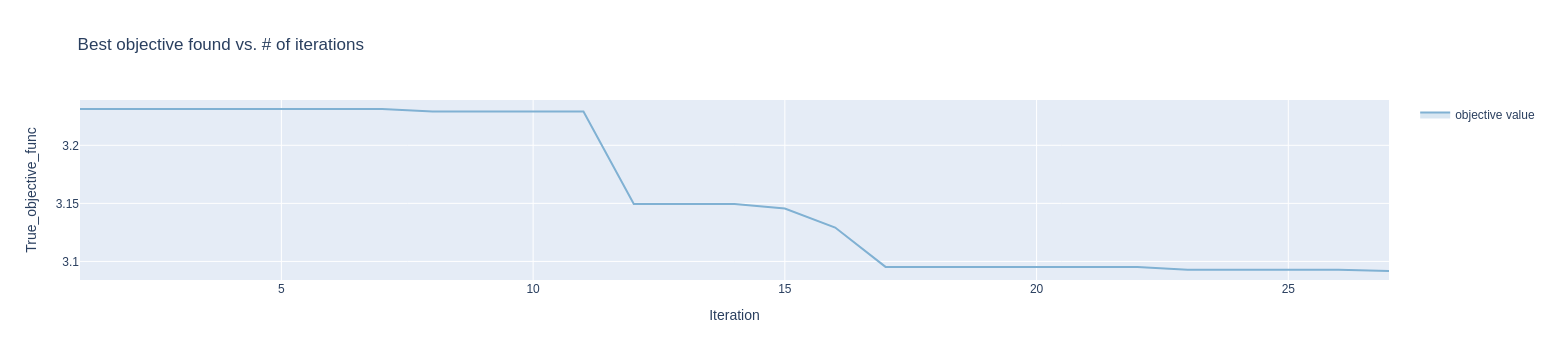

In [28]:
render(ax_client.get_optimization_trace())

[INFO 05-25 04:59:54] ax.service.ax_client: Retrieving contour plot with parameter 'aLund' on X-axis and 'bLund' on Y-axis, for metric 'true_objective_func'. Remaining parameters are affixed to the middle of their range.


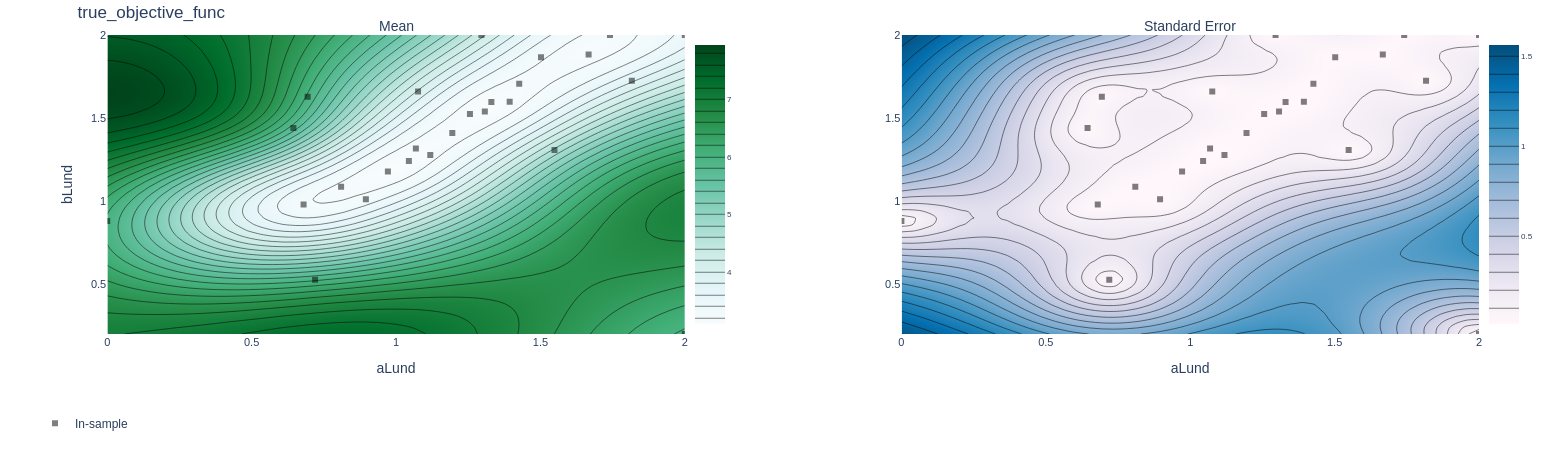

In [29]:
import plotly.graph_objects as go

# fig = go.Figure()
# fig.add_trace(
render(ax_client.get_contour_plot())
# )


# fig.show()
# fig.write_image("images/Lund_a_b_countour.pdf")

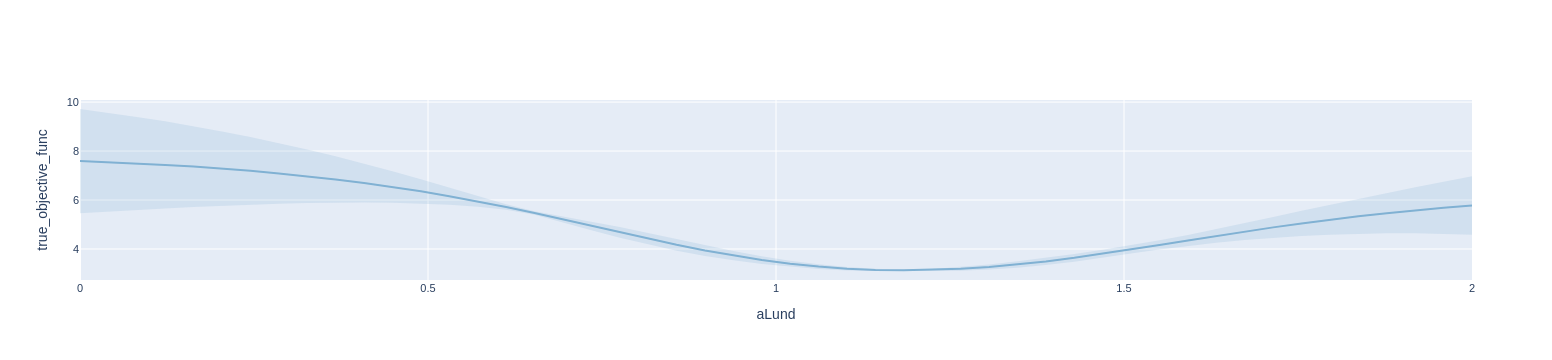

In [30]:
from ax.plot.slice import plot_slice

model = ax_client.generation_strategy.model
render(plot_slice(model, "aLund", "true_objective_func"))

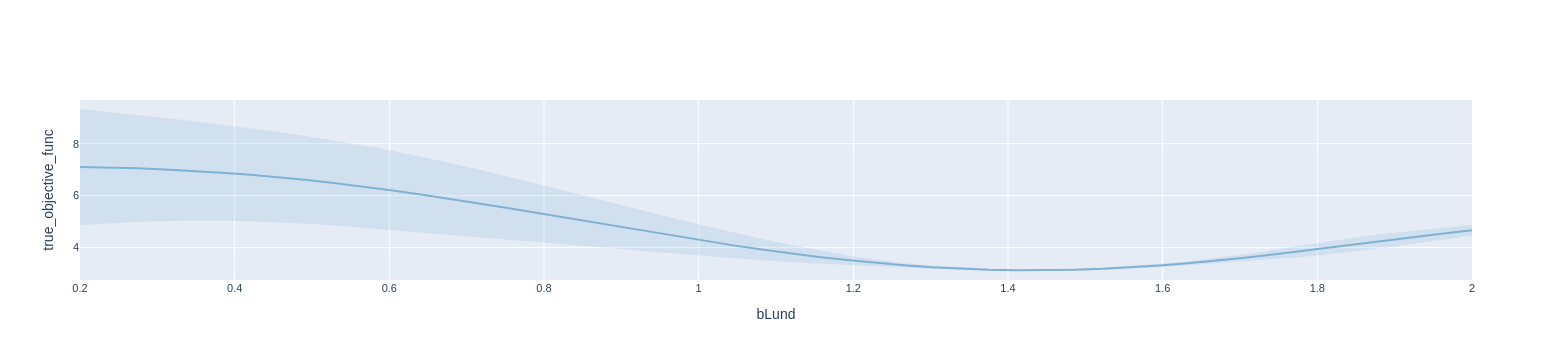

In [31]:
render(plot_slice(model, "bLund", "true_objective_func"))

## Validate the results

1. Make the pythia card with the best parameters based on the Bayesian Optimization above
2. Run the pythia card with 300,000 events yielding a test.yoda validation output
3. convert yoda histograms to pandas dataframes, filter histograms and plot result agreement with data

In [32]:
def make_pythia_valid_card(best_parameters):
    
    cards_dir = os.path.join(os.getcwd(), "BO_Cards")
    filename = f"ALEPH_1996_S3486095_BO_card_valid.cmnd"
    file_path = os.path.join(cards_dir, filename)
    with open(file_path,'w') as f:
        first_block="""Main:numberOfEvents = 300000          ! number of events to generate
Next:numberShowEvent = 0           ! suppress full listing of first events
# random seed
Random:setSeed = on
Random:seed= 0
! 2) Beam parameter settings.
Beams:idA = 11                ! first beam,  e- = 11
Beams:idB = -11                ! second beam, e+ = -11
Beams:eCM = 91.2               ! CM energy of collision
# Pythia 8 settings for LEP
# Hadronic decays including b quarks, with ISR photons switched off
WeakSingleBoson:ffbar2gmZ = on
23:onMode = off
23:onIfAny = 1 2 3 4 5
PDF:lepton = off
SpaceShower:QEDshowerByL = off\n\n"""
        f.write(first_block)
        # f.write(f"Random:seed={indx+1}")

        f.write("StringZ:aLund = {}\n\n".format(best_parameters["aLund"]))
        f.write("StringZ:bLund = {}\n\n".format(best_parameters["bLund"]))

def run_valid_card(best_parameters):
    
    # step 1: write .cmnd file 
    make_pythia_valid_card(best_parameters)
    #step 2 run main42 and rivet
    os.system("""./main42 BO_Cards/ALEPH_1996_S3486095_BO_card_valid.cmnd ALEPH_1996_S3486095_card_valid.fifo &
    
    rivet -o ALEPH_1996_S3486095_hist_valid_0.yoda -a ALEPH_1996_S3486095 ALEPH_1996_S3486095_card_valid.fifo

    rm ALEPH_1996_S3486095_card_valid.fifo
    mv ALEPH_1996_S3486095_hist_valid_0.yoda ALEPH_YODAS_BayesOpt/""")

In [33]:
run_valid_card(best_parameters)


 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card_valid.cmnd <<< 
 >>> HepMC events will be written to file ALEPH_1996_S3486095_card_valid.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |   P       

Rivet 3.1.9 running on machine 99deb7ce41f6 (x86_64) at 2024-05-25 05:00:37
Reading events from 'ALEPH_1996_S3486095_card_valid.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)



 Pythia::next(): 2000 events have been generated 


Event 300 (0:00:01 elapsed)
Event 400 (0:00:01 elapsed)
Event 500 (0:00:01 elapsed)
Event 600 (0:00:01 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)



 Pythia::next(): 3000 events have been generated 


Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:02 elapsed)
Event 1500 (0:00:02 elapsed)
Event 1600 (0:00:02 elapsed)
Event 1700 (0:00:02 elapsed)
Event 1800 (0:00:02 elapsed)
Event 1900 (0:00:02 elapsed)
Event 2000 (0:00:02 elapsed)



 Pythia::next(): 4000 events have been generated 


Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:03 elapsed)
Event 2600 (0:00:03 elapsed)



 Pythia::next(): 5000 events have been generated 


Event 2700 (0:00:03 elapsed)
Event 2800 (0:00:03 elapsed)
Event 2900 (0:00:03 elapsed)
Event 3000 (0:00:03 elapsed)
Event 3100 (0:00:03 elapsed)
Event 3200 (0:00:03 elapsed)
Event 3300 (0:00:03 elapsed)
Event 3400 (0:00:03 elapsed)
Event 3500 (0:00:03 elapsed)



 Pythia::next(): 6000 events have been generated 


Event 3600 (0:00:03 elapsed)
Event 3700 (0:00:04 elapsed)
Event 3800 (0:00:04 elapsed)
Event 3900 (0:00:04 elapsed)
Event 4000 (0:00:04 elapsed)
Event 4100 (0:00:04 elapsed)
Event 4200 (0:00:04 elapsed)
Event 4300 (0:00:04 elapsed)
Event 4400 (0:00:04 elapsed)



 Pythia::next(): 7000 events have been generated 


Event 4500 (0:00:04 elapsed)
Event 4600 (0:00:04 elapsed)
Event 4700 (0:00:04 elapsed)
Event 4800 (0:00:05 elapsed)
Event 4900 (0:00:05 elapsed)
Event 5000 (0:00:05 elapsed)
Event 5100 (0:00:05 elapsed)
Event 5200 (0:00:05 elapsed)
Event 5300 (0:00:05 elapsed)



 Pythia::next(): 8000 events have been generated 


Event 5400 (0:00:05 elapsed)
Event 5500 (0:00:05 elapsed)
Event 5600 (0:00:05 elapsed)
Event 5700 (0:00:05 elapsed)
Event 5800 (0:00:06 elapsed)
Event 5900 (0:00:06 elapsed)
Event 6000 (0:00:06 elapsed)
Event 6100 (0:00:06 elapsed)



 Pythia::next(): 9000 events have been generated 


Event 6200 (0:00:06 elapsed)
Event 6300 (0:00:06 elapsed)
Event 6400 (0:00:06 elapsed)
Event 6500 (0:00:06 elapsed)
Event 6600 (0:00:06 elapsed)
Event 6700 (0:00:06 elapsed)
Event 6800 (0:00:06 elapsed)
Event 6900 (0:00:07 elapsed)
Event 7000 (0:00:07 elapsed)



 Pythia::next(): 10000 events have been generated 


Event 7100 (0:00:07 elapsed)
Event 7200 (0:00:07 elapsed)
Event 7300 (0:00:07 elapsed)
Event 7400 (0:00:07 elapsed)
Event 7500 (0:00:07 elapsed)
Event 7600 (0:00:07 elapsed)
Event 7700 (0:00:07 elapsed)
Event 7800 (0:00:07 elapsed)
Event 7900 (0:00:07 elapsed)



 Pythia::next(): 11000 events have been generated 


Event 8000 (0:00:08 elapsed)
Event 8100 (0:00:08 elapsed)
Event 8200 (0:00:08 elapsed)
Event 8300 (0:00:08 elapsed)
Event 8400 (0:00:08 elapsed)
Event 8500 (0:00:08 elapsed)
Event 8600 (0:00:08 elapsed)
Event 8700 (0:00:08 elapsed)
Event 8800 (0:00:08 elapsed)



 Pythia::next(): 12000 events have been generated 


Event 8900 (0:00:08 elapsed)
Event 9000 (0:00:08 elapsed)
Event 9100 (0:00:09 elapsed)
Event 9200 (0:00:09 elapsed)
Event 9300 (0:00:09 elapsed)
Event 9400 (0:00:09 elapsed)



 Pythia::next(): 13000 events have been generated 


Event 9500 (0:00:09 elapsed)
Event 9600 (0:00:09 elapsed)
Event 9700 (0:00:09 elapsed)
Event 9800 (0:00:09 elapsed)
Event 9900 (0:00:09 elapsed)
Event 10000 (0:00:09 elapsed)
Event 10100 (0:00:09 elapsed)
Event 10200 (0:00:10 elapsed)
Event 10300 (0:00:10 elapsed)



 Pythia::next(): 14000 events have been generated 


Event 10400 (0:00:10 elapsed)
Event 10500 (0:00:10 elapsed)
Event 10600 (0:00:10 elapsed)
Event 10700 (0:00:10 elapsed)
Event 10800 (0:00:10 elapsed)
Event 10900 (0:00:10 elapsed)
Event 11000 (0:00:10 elapsed)
Event 11100 (0:00:10 elapsed)
Event 11200 (0:00:11 elapsed)



 Pythia::next(): 15000 events have been generated 


Event 11300 (0:00:11 elapsed)
Event 11400 (0:00:11 elapsed)
Event 11500 (0:00:11 elapsed)
Event 11600 (0:00:11 elapsed)
Event 11700 (0:00:11 elapsed)
Event 11800 (0:00:11 elapsed)
Event 11900 (0:00:11 elapsed)
Event 12000 (0:00:11 elapsed)
Event 12100 (0:00:11 elapsed)



 Pythia::next(): 16000 events have been generated 


Event 12200 (0:00:11 elapsed)
Event 12300 (0:00:12 elapsed)
Event 12400 (0:00:12 elapsed)
Event 12500 (0:00:12 elapsed)
Event 12600 (0:00:12 elapsed)
Event 12700 (0:00:12 elapsed)
Event 12800 (0:00:12 elapsed)
Event 12900 (0:00:12 elapsed)
Event 13000 (0:00:12 elapsed)



 Pythia::next(): 17000 events have been generated 


Event 13100 (0:00:12 elapsed)
Event 13200 (0:00:12 elapsed)
Event 13300 (0:00:12 elapsed)
Event 13400 (0:00:13 elapsed)
Event 13500 (0:00:13 elapsed)
Event 13600 (0:00:13 elapsed)
Event 13700 (0:00:13 elapsed)
Event 13800 (0:00:13 elapsed)
Event 13900 (0:00:13 elapsed)



 Pythia::next(): 18000 events have been generated 


Event 14000 (0:00:13 elapsed)
Event 14100 (0:00:13 elapsed)
Event 14200 (0:00:13 elapsed)
Event 14300 (0:00:13 elapsed)
Event 14400 (0:00:13 elapsed)
Event 14500 (0:00:14 elapsed)



 Pythia::next(): 19000 events have been generated 


Event 14600 (0:00:14 elapsed)
Event 14700 (0:00:14 elapsed)
Event 14800 (0:00:14 elapsed)
Event 14900 (0:00:14 elapsed)
Event 15000 (0:00:14 elapsed)
Event 15100 (0:00:14 elapsed)
Event 15200 (0:00:14 elapsed)
Event 15300 (0:00:14 elapsed)
Event 15400 (0:00:14 elapsed)



 Pythia::next(): 20000 events have been generated 


Event 15500 (0:00:14 elapsed)
Event 15600 (0:00:14 elapsed)
Event 15700 (0:00:15 elapsed)
Event 15800 (0:00:15 elapsed)
Event 15900 (0:00:15 elapsed)
Event 16000 (0:00:15 elapsed)
Event 16100 (0:00:15 elapsed)
Event 16200 (0:00:15 elapsed)
Event 16300 (0:00:15 elapsed)



 Pythia::next(): 21000 events have been generated 


Event 16400 (0:00:15 elapsed)
Event 16500 (0:00:15 elapsed)
Event 16600 (0:00:15 elapsed)
Event 16700 (0:00:15 elapsed)
Event 16800 (0:00:16 elapsed)
Event 16900 (0:00:16 elapsed)
Event 17000 (0:00:16 elapsed)
Event 17100 (0:00:16 elapsed)
Event 17200 (0:00:16 elapsed)



 Pythia::next(): 22000 events have been generated 


Event 17300 (0:00:16 elapsed)
Event 17400 (0:00:16 elapsed)
Event 17500 (0:00:16 elapsed)
Event 17600 (0:00:16 elapsed)
Event 17700 (0:00:16 elapsed)
Event 17800 (0:00:16 elapsed)
Event 17900 (0:00:17 elapsed)
Event 18000 (0:00:17 elapsed)
Event 18100 (0:00:17 elapsed)



 Pythia::next(): 23000 events have been generated 


Event 18200 (0:00:17 elapsed)
Event 18300 (0:00:17 elapsed)
Event 18400 (0:00:17 elapsed)
Event 18500 (0:00:17 elapsed)
Event 18600 (0:00:17 elapsed)
Event 18700 (0:00:17 elapsed)
Event 18800 (0:00:17 elapsed)
Event 18900 (0:00:17 elapsed)
Event 19000 (0:00:18 elapsed)



 Pythia::next(): 24000 events have been generated 


Event 19100 (0:00:18 elapsed)
Event 19200 (0:00:18 elapsed)
Event 19300 (0:00:18 elapsed)
Event 19400 (0:00:18 elapsed)
Event 19500 (0:00:18 elapsed)
Event 19600 (0:00:18 elapsed)
Event 19700 (0:00:18 elapsed)
Event 19800 (0:00:18 elapsed)
Event 19900 (0:00:18 elapsed)



 Pythia::next(): 25000 events have been generated 


Event 20000 (0:00:18 elapsed)
Event 20100 (0:00:18 elapsed)
Event 20200 (0:00:19 elapsed)
Event 20300 (0:00:19 elapsed)
Event 20400 (0:00:19 elapsed)
Event 20500 (0:00:19 elapsed)



 Pythia::next(): 26000 events have been generated 


Event 20600 (0:00:19 elapsed)
Event 20700 (0:00:19 elapsed)
Event 20800 (0:00:19 elapsed)
Event 20900 (0:00:19 elapsed)
Event 21000 (0:00:19 elapsed)
Event 21100 (0:00:19 elapsed)
Event 21200 (0:00:19 elapsed)
Event 21300 (0:00:20 elapsed)
Event 21400 (0:00:20 elapsed)



 Pythia::next(): 27000 events have been generated 


Event 21500 (0:00:20 elapsed)
Event 21600 (0:00:20 elapsed)
Event 21700 (0:00:20 elapsed)
Event 21800 (0:00:20 elapsed)
Event 21900 (0:00:20 elapsed)
Event 22000 (0:00:20 elapsed)
Event 22100 (0:00:20 elapsed)
Event 22200 (0:00:20 elapsed)
Event 22300 (0:00:20 elapsed)



 Pythia::next(): 28000 events have been generated 


Event 22400 (0:00:21 elapsed)
Event 22500 (0:00:21 elapsed)
Event 22600 (0:00:21 elapsed)
Event 22700 (0:00:21 elapsed)
Event 22800 (0:00:21 elapsed)
Event 22900 (0:00:21 elapsed)
Event 23000 (0:00:21 elapsed)
Event 23100 (0:00:21 elapsed)
Event 23200 (0:00:21 elapsed)



 Pythia::next(): 29000 events have been generated 


Event 23300 (0:00:21 elapsed)
Event 23400 (0:00:21 elapsed)
Event 23500 (0:00:21 elapsed)
Event 23600 (0:00:22 elapsed)
Event 23700 (0:00:22 elapsed)
Event 23800 (0:00:22 elapsed)
Event 23900 (0:00:22 elapsed)
Event 24000 (0:00:22 elapsed)
Event 24100 (0:00:22 elapsed)



 Pythia::next(): 30000 events have been generated 


Event 24200 (0:00:22 elapsed)
Event 24300 (0:00:22 elapsed)
Event 24400 (0:00:22 elapsed)
Event 24500 (0:00:22 elapsed)
Event 24600 (0:00:22 elapsed)
Event 24700 (0:00:23 elapsed)



 Pythia::next(): 31000 events have been generated 


Event 24800 (0:00:23 elapsed)
Event 24900 (0:00:23 elapsed)
Event 25000 (0:00:23 elapsed)
Event 25100 (0:00:23 elapsed)
Event 25200 (0:00:23 elapsed)
Event 25300 (0:00:23 elapsed)
Event 25400 (0:00:23 elapsed)
Event 25500 (0:00:23 elapsed)
Event 25600 (0:00:23 elapsed)



 Pythia::next(): 32000 events have been generated 


Event 25700 (0:00:23 elapsed)
Event 25800 (0:00:24 elapsed)
Event 25900 (0:00:24 elapsed)
Event 26000 (0:00:24 elapsed)
Event 26100 (0:00:24 elapsed)
Event 26200 (0:00:24 elapsed)
Event 26300 (0:00:24 elapsed)
Event 26400 (0:00:24 elapsed)
Event 26500 (0:00:24 elapsed)



 Pythia::next(): 33000 events have been generated 


Event 26600 (0:00:24 elapsed)
Event 26700 (0:00:24 elapsed)
Event 26800 (0:00:24 elapsed)
Event 26900 (0:00:24 elapsed)
Event 27000 (0:00:25 elapsed)
Event 27100 (0:00:25 elapsed)
Event 27200 (0:00:25 elapsed)
Event 27300 (0:00:25 elapsed)
Event 27400 (0:00:25 elapsed)



 Pythia::next(): 34000 events have been generated 


Event 27500 (0:00:25 elapsed)
Event 27600 (0:00:25 elapsed)
Event 27700 (0:00:25 elapsed)
Event 27800 (0:00:25 elapsed)
Event 27900 (0:00:25 elapsed)
Event 28000 (0:00:25 elapsed)
Event 28100 (0:00:26 elapsed)
Event 28200 (0:00:26 elapsed)
Event 28300 (0:00:26 elapsed)



 Pythia::next(): 35000 events have been generated 


Event 28400 (0:00:26 elapsed)
Event 28500 (0:00:26 elapsed)
Event 28600 (0:00:26 elapsed)
Event 28700 (0:00:26 elapsed)
Event 28800 (0:00:26 elapsed)
Event 28900 (0:00:26 elapsed)
Event 29000 (0:00:26 elapsed)
Event 29100 (0:00:26 elapsed)
Event 29200 (0:00:27 elapsed)



 Pythia::next(): 36000 events have been generated 


Event 29300 (0:00:27 elapsed)
Event 29400 (0:00:27 elapsed)
Event 29500 (0:00:27 elapsed)
Event 29600 (0:00:27 elapsed)
Event 29700 (0:00:27 elapsed)
Event 29800 (0:00:27 elapsed)
Event 29900 (0:00:27 elapsed)
Event 30000 (0:00:27 elapsed)
Event 30100 (0:00:27 elapsed)



 Pythia::next(): 37000 events have been generated 


Event 30200 (0:00:27 elapsed)
Event 30300 (0:00:27 elapsed)
Event 30400 (0:00:28 elapsed)
Event 30500 (0:00:28 elapsed)
Event 30600 (0:00:28 elapsed)
Event 30700 (0:00:28 elapsed)



 Pythia::next(): 38000 events have been generated 


Event 30800 (0:00:28 elapsed)
Event 30900 (0:00:28 elapsed)
Event 31000 (0:00:28 elapsed)
Event 31100 (0:00:28 elapsed)
Event 31200 (0:00:28 elapsed)
Event 31300 (0:00:28 elapsed)
Event 31400 (0:00:28 elapsed)
Event 31500 (0:00:29 elapsed)
Event 31600 (0:00:29 elapsed)



 Pythia::next(): 39000 events have been generated 


Event 31700 (0:00:29 elapsed)
Event 31800 (0:00:29 elapsed)
Event 31900 (0:00:29 elapsed)
Event 32000 (0:00:29 elapsed)
Event 32100 (0:00:29 elapsed)
Event 32200 (0:00:29 elapsed)
Event 32300 (0:00:29 elapsed)
Event 32400 (0:00:29 elapsed)
Event 32500 (0:00:29 elapsed)



 Pythia::next(): 40000 events have been generated 


Event 32600 (0:00:29 elapsed)
Event 32700 (0:00:30 elapsed)
Event 32800 (0:00:30 elapsed)
Event 32900 (0:00:30 elapsed)
Event 33000 (0:00:30 elapsed)
Event 33100 (0:00:30 elapsed)
Event 33200 (0:00:30 elapsed)
Event 33300 (0:00:30 elapsed)
Event 33400 (0:00:30 elapsed)



 Pythia::next(): 41000 events have been generated 


Event 33500 (0:00:30 elapsed)
Event 33600 (0:00:30 elapsed)
Event 33700 (0:00:30 elapsed)
Event 33800 (0:00:31 elapsed)
Event 33900 (0:00:31 elapsed)
Event 34000 (0:00:31 elapsed)
Event 34100 (0:00:31 elapsed)
Event 34200 (0:00:31 elapsed)
Event 34300 (0:00:31 elapsed)



 Pythia::next(): 42000 events have been generated 


Event 34400 (0:00:31 elapsed)
Event 34500 (0:00:31 elapsed)
Event 34600 (0:00:31 elapsed)
Event 34700 (0:00:31 elapsed)
Event 34800 (0:00:31 elapsed)
Event 34900 (0:00:32 elapsed)
Event 35000 (0:00:32 elapsed)



 Pythia::next(): 43000 events have been generated 


Event 35100 (0:00:32 elapsed)
Event 35200 (0:00:32 elapsed)
Event 35300 (0:00:32 elapsed)
Event 35400 (0:00:32 elapsed)
Event 35500 (0:00:32 elapsed)
Event 35600 (0:00:32 elapsed)



 Pythia::next(): 44000 events have been generated 


Event 35700 (0:00:32 elapsed)
Event 35800 (0:00:33 elapsed)
Event 35900 (0:00:33 elapsed)
Event 36000 (0:00:33 elapsed)
Event 36100 (0:00:33 elapsed)
Event 36200 (0:00:33 elapsed)
Event 36300 (0:00:33 elapsed)
Event 36400 (0:00:33 elapsed)
Event 36500 (0:00:33 elapsed)



 Pythia::next(): 45000 events have been generated 


Event 36600 (0:00:33 elapsed)
Event 36700 (0:00:33 elapsed)
Event 36800 (0:00:33 elapsed)
Event 36900 (0:00:33 elapsed)
Event 37000 (0:00:34 elapsed)
Event 37100 (0:00:34 elapsed)
Event 37200 (0:00:34 elapsed)
Event 37300 (0:00:34 elapsed)



 Pythia::next(): 46000 events have been generated 


Event 37400 (0:00:34 elapsed)
Event 37500 (0:00:34 elapsed)
Event 37600 (0:00:34 elapsed)
Event 37700 (0:00:34 elapsed)
Event 37800 (0:00:34 elapsed)
Event 37900 (0:00:34 elapsed)
Event 38000 (0:00:35 elapsed)



 Pythia::next(): 47000 events have been generated 


Event 38100 (0:00:35 elapsed)
Event 38200 (0:00:35 elapsed)
Event 38300 (0:00:35 elapsed)
Event 38400 (0:00:35 elapsed)
Event 38500 (0:00:36 elapsed)
Event 38600 (0:00:36 elapsed)
Event 38700 (0:00:36 elapsed)
Event 38800 (0:00:36 elapsed)
Event 38900 (0:00:36 elapsed)



 Pythia::next(): 48000 events have been generated 


Event 39000 (0:00:36 elapsed)
Event 39100 (0:00:36 elapsed)
Event 39200 (0:00:36 elapsed)
Event 39300 (0:00:36 elapsed)
Event 39400 (0:00:36 elapsed)
Event 39500 (0:00:36 elapsed)
Event 39600 (0:00:37 elapsed)
Event 39700 (0:00:37 elapsed)



 Pythia::next(): 49000 events have been generated 


Event 39800 (0:00:37 elapsed)
Event 39900 (0:00:37 elapsed)
Event 40000 (0:00:37 elapsed)
Event 40100 (0:00:37 elapsed)
Event 40200 (0:00:37 elapsed)



 Pythia::next(): 50000 events have been generated 


Event 40300 (0:00:37 elapsed)
Event 40400 (0:00:38 elapsed)
Event 40500 (0:00:38 elapsed)
Event 40600 (0:00:38 elapsed)
Event 40700 (0:00:38 elapsed)
Event 40800 (0:00:38 elapsed)
Event 40900 (0:00:38 elapsed)
Event 41000 (0:00:38 elapsed)



 Pythia::next(): 51000 events have been generated 


Event 41100 (0:00:39 elapsed)
Event 41200 (0:00:39 elapsed)
Event 41300 (0:00:39 elapsed)
Event 41400 (0:00:39 elapsed)
Event 41500 (0:00:39 elapsed)
Event 41600 (0:00:39 elapsed)



 Pythia::next(): 52000 events have been generated 


Event 41700 (0:00:39 elapsed)
Event 41800 (0:00:39 elapsed)
Event 41900 (0:00:39 elapsed)
Event 42000 (0:00:39 elapsed)
Event 42100 (0:00:40 elapsed)
Event 42200 (0:00:40 elapsed)
Event 42300 (0:00:40 elapsed)
Event 42400 (0:00:40 elapsed)



 Pythia::next(): 53000 events have been generated 


Event 42500 (0:00:40 elapsed)
Event 42600 (0:00:40 elapsed)
Event 42700 (0:00:40 elapsed)
Event 42800 (0:00:40 elapsed)
Event 42900 (0:00:40 elapsed)
Event 43000 (0:00:40 elapsed)



 Pythia::next(): 54000 events have been generated 


Event 43100 (0:00:41 elapsed)
Event 43200 (0:00:41 elapsed)
Event 43300 (0:00:41 elapsed)
Event 43400 (0:00:41 elapsed)
Event 43500 (0:00:41 elapsed)
Event 43600 (0:00:41 elapsed)
Event 43700 (0:00:41 elapsed)
Event 43800 (0:00:41 elapsed)
Event 43900 (0:00:41 elapsed)



 Pythia::next(): 55000 events have been generated 


Event 44000 (0:00:42 elapsed)
Event 44100 (0:00:42 elapsed)
Event 44200 (0:00:42 elapsed)
Event 44300 (0:00:42 elapsed)
Event 44400 (0:00:42 elapsed)
Event 44500 (0:00:42 elapsed)
Event 44600 (0:00:42 elapsed)
Event 44700 (0:00:42 elapsed)



 Pythia::next(): 56000 events have been generated 


Event 44800 (0:00:42 elapsed)
Event 44900 (0:00:42 elapsed)
Event 45000 (0:00:43 elapsed)
Event 45100 (0:00:43 elapsed)
Event 45200 (0:00:43 elapsed)
Event 45300 (0:00:43 elapsed)



 Pythia::next(): 57000 events have been generated 


Event 45400 (0:00:43 elapsed)
Event 45500 (0:00:43 elapsed)
Event 45600 (0:00:43 elapsed)
Event 45700 (0:00:43 elapsed)
Event 45800 (0:00:43 elapsed)
Event 45900 (0:00:43 elapsed)
Event 46000 (0:00:43 elapsed)
Event 46100 (0:00:44 elapsed)
Event 46200 (0:00:44 elapsed)
Event 46300 (0:00:44 elapsed)
Event 46400 (0:00:44 elapsed)



 Pythia::next(): 58000 events have been generated 


Event 46500 (0:00:44 elapsed)
Event 46600 (0:00:44 elapsed)
Event 46700 (0:00:44 elapsed)
Event 46800 (0:00:44 elapsed)
Event 46900 (0:00:44 elapsed)
Event 47000 (0:00:44 elapsed)



 Pythia::next(): 59000 events have been generated 


Event 47100 (0:00:45 elapsed)
Event 47200 (0:00:45 elapsed)
Event 47300 (0:00:45 elapsed)
Event 47400 (0:00:45 elapsed)
Event 47500 (0:00:45 elapsed)
Event 47600 (0:00:45 elapsed)
Event 47700 (0:00:45 elapsed)
Event 47800 (0:00:45 elapsed)



 Pythia::next(): 60000 events have been generated 


Event 47900 (0:00:45 elapsed)
Event 48000 (0:00:46 elapsed)
Event 48100 (0:00:46 elapsed)
Event 48200 (0:00:46 elapsed)
Event 48300 (0:00:46 elapsed)
Event 48400 (0:00:46 elapsed)
Event 48500 (0:00:46 elapsed)
Event 48600 (0:00:46 elapsed)



 Pythia::next(): 61000 events have been generated 


Event 48700 (0:00:46 elapsed)
Event 48800 (0:00:46 elapsed)
Event 48900 (0:00:46 elapsed)
Event 49000 (0:00:47 elapsed)
Event 49100 (0:00:47 elapsed)
Event 49200 (0:00:47 elapsed)
Event 49300 (0:00:47 elapsed)
Event 49400 (0:00:47 elapsed)



 Pythia::next(): 62000 events have been generated 


Event 49500 (0:00:47 elapsed)
Event 49600 (0:00:47 elapsed)
Event 49700 (0:00:47 elapsed)
Event 49800 (0:00:47 elapsed)
Event 49900 (0:00:47 elapsed)
Event 50000 (0:00:47 elapsed)
Event 50100 (0:00:48 elapsed)
Event 50200 (0:00:48 elapsed)
Event 50300 (0:00:48 elapsed)



 Pythia::next(): 63000 events have been generated 


Event 50400 (0:00:48 elapsed)
Event 50500 (0:00:48 elapsed)
Event 50600 (0:00:48 elapsed)
Event 50700 (0:00:48 elapsed)
Event 50800 (0:00:48 elapsed)
Event 50900 (0:00:48 elapsed)
Event 51000 (0:00:48 elapsed)
Event 51100 (0:00:49 elapsed)



 Pythia::next(): 64000 events have been generated 


Event 51200 (0:00:49 elapsed)
Event 51300 (0:00:49 elapsed)
Event 51400 (0:00:49 elapsed)
Event 51500 (0:00:49 elapsed)
Event 51600 (0:00:49 elapsed)
Event 51700 (0:00:49 elapsed)
Event 51800 (0:00:49 elapsed)
Event 51900 (0:00:49 elapsed)
Event 52000 (0:00:49 elapsed)



 Pythia::next(): 65000 events have been generated 


Event 52100 (0:00:49 elapsed)
Event 52200 (0:00:50 elapsed)
Event 52300 (0:00:50 elapsed)
Event 52400 (0:00:50 elapsed)
Event 52500 (0:00:50 elapsed)
Event 52600 (0:00:50 elapsed)
Event 52700 (0:00:50 elapsed)
Event 52800 (0:00:50 elapsed)



 Pythia::next(): 66000 events have been generated 


Event 52900 (0:00:50 elapsed)
Event 53000 (0:00:50 elapsed)
Event 53100 (0:00:51 elapsed)
Event 53200 (0:00:51 elapsed)
Event 53300 (0:00:51 elapsed)



 Pythia::next(): 67000 events have been generated 


Event 53400 (0:00:51 elapsed)
Event 53500 (0:00:51 elapsed)
Event 53600 (0:00:51 elapsed)
Event 53700 (0:00:51 elapsed)
Event 53800 (0:00:52 elapsed)
Event 53900 (0:00:52 elapsed)
Event 54000 (0:00:52 elapsed)



 Pythia::next(): 68000 events have been generated 


Event 54100 (0:00:52 elapsed)
Event 54200 (0:00:52 elapsed)
Event 54300 (0:00:52 elapsed)
Event 54400 (0:00:52 elapsed)
Event 54500 (0:00:52 elapsed)
Event 54600 (0:00:53 elapsed)
Event 54700 (0:00:53 elapsed)
Event 54800 (0:00:53 elapsed)
Event 54900 (0:00:53 elapsed)



 Pythia::next(): 69000 events have been generated 


Event 55000 (0:00:53 elapsed)
Event 55100 (0:00:53 elapsed)
Event 55200 (0:00:53 elapsed)
Event 55300 (0:00:53 elapsed)
Event 55400 (0:00:53 elapsed)
Event 55500 (0:00:54 elapsed)



 Pythia::next(): 70000 events have been generated 


Event 55600 (0:00:54 elapsed)
Event 55700 (0:00:54 elapsed)
Event 55800 (0:00:54 elapsed)
Event 55900 (0:00:54 elapsed)
Event 56000 (0:00:54 elapsed)
Event 56100 (0:00:54 elapsed)
Event 56200 (0:00:54 elapsed)
Event 56300 (0:00:54 elapsed)



 Pythia::next(): 71000 events have been generated 


Event 56400 (0:00:55 elapsed)
Event 56500 (0:00:55 elapsed)
Event 56600 (0:00:55 elapsed)
Event 56700 (0:00:55 elapsed)
Event 56800 (0:00:55 elapsed)
Event 56900 (0:00:55 elapsed)
Event 57000 (0:00:55 elapsed)
Event 57100 (0:00:55 elapsed)



 Pythia::next(): 72000 events have been generated 


Event 57200 (0:00:55 elapsed)
Event 57300 (0:00:56 elapsed)
Event 57400 (0:00:56 elapsed)
Event 57500 (0:00:56 elapsed)
Event 57600 (0:00:56 elapsed)
Event 57700 (0:00:56 elapsed)
Event 57800 (0:00:56 elapsed)
Event 57900 (0:00:56 elapsed)



 Pythia::next(): 73000 events have been generated 


Event 58000 (0:00:56 elapsed)
Event 58100 (0:00:56 elapsed)
Event 58200 (0:00:57 elapsed)
Event 58300 (0:00:57 elapsed)
Event 58400 (0:00:57 elapsed)
Event 58500 (0:00:57 elapsed)
Event 58600 (0:00:57 elapsed)
Event 58700 (0:00:57 elapsed)



 Pythia::next(): 74000 events have been generated 


Event 58800 (0:00:57 elapsed)
Event 58900 (0:00:57 elapsed)
Event 59000 (0:00:57 elapsed)
Event 59100 (0:00:57 elapsed)
Event 59200 (0:00:57 elapsed)
Event 59300 (0:00:58 elapsed)
Event 59400 (0:00:58 elapsed)
Event 59500 (0:00:58 elapsed)
Event 59600 (0:00:58 elapsed)



 Pythia::next(): 75000 events have been generated 


Event 59700 (0:00:58 elapsed)
Event 59800 (0:00:58 elapsed)
Event 59900 (0:00:58 elapsed)
Event 60000 (0:00:58 elapsed)
Event 60100 (0:00:58 elapsed)
Event 60200 (0:00:58 elapsed)
Event 60300 (0:00:58 elapsed)
Event 60400 (0:00:59 elapsed)



 Pythia::next(): 76000 events have been generated 


Event 60500 (0:00:59 elapsed)
Event 60600 (0:00:59 elapsed)
Event 60700 (0:00:59 elapsed)
Event 60800 (0:00:59 elapsed)
Event 60900 (0:00:59 elapsed)
Event 61000 (0:00:59 elapsed)



 Pythia::next(): 77000 events have been generated 


Event 61100 (0:01:00 elapsed)
Event 61200 (0:01:00 elapsed)
Event 61300 (0:01:00 elapsed)
Event 61400 (0:01:00 elapsed)
Event 61500 (0:01:00 elapsed)
Event 61600 (0:01:00 elapsed)
Event 61700 (0:01:00 elapsed)
Event 61800 (0:01:00 elapsed)
Event 61900 (0:01:00 elapsed)



 Pythia::next(): 78000 events have been generated 


Event 62000 (0:01:01 elapsed)
Event 62100 (0:01:01 elapsed)
Event 62200 (0:01:01 elapsed)
Event 62300 (0:01:01 elapsed)



 Pythia::next(): 79000 events have been generated 
 PYTHIA Warning in HadronWidths::pickMasses: angular momentum and running widths not used  


Event 62400 (0:01:01 elapsed)
Event 62500 (0:01:01 elapsed)
Event 62600 (0:01:01 elapsed)
Event 62700 (0:01:01 elapsed)
Event 62800 (0:01:02 elapsed)
Event 62900 (0:01:02 elapsed)
Event 63000 (0:01:02 elapsed)



 Pythia::next(): 80000 events have been generated 


Event 63100 (0:01:02 elapsed)
Event 63200 (0:01:02 elapsed)
Event 63300 (0:01:02 elapsed)
Event 63400 (0:01:02 elapsed)
Event 63500 (0:01:02 elapsed)
Event 63600 (0:01:02 elapsed)
Event 63700 (0:01:03 elapsed)
Event 63800 (0:01:03 elapsed)
Event 63900 (0:01:03 elapsed)



 Pythia::next(): 81000 events have been generated 


Event 64000 (0:01:03 elapsed)
Event 64100 (0:01:03 elapsed)
Event 64200 (0:01:03 elapsed)
Event 64300 (0:01:03 elapsed)
Event 64400 (0:01:03 elapsed)
Event 64500 (0:01:03 elapsed)
Event 64600 (0:01:03 elapsed)
Event 64700 (0:01:03 elapsed)
Event 64800 (0:01:04 elapsed)



 Pythia::next(): 82000 events have been generated 


Event 64900 (0:01:04 elapsed)
Event 65000 (0:01:04 elapsed)
Event 65100 (0:01:04 elapsed)
Event 65200 (0:01:04 elapsed)
Event 65300 (0:01:04 elapsed)
Event 65400 (0:01:04 elapsed)



 Pythia::next(): 83000 events have been generated 


Event 65500 (0:01:04 elapsed)
Event 65600 (0:01:04 elapsed)
Event 65700 (0:01:04 elapsed)
Event 65800 (0:01:04 elapsed)
Event 65900 (0:01:05 elapsed)
Event 66000 (0:01:05 elapsed)
Event 66100 (0:01:05 elapsed)
Event 66200 (0:01:05 elapsed)
Event 66300 (0:01:05 elapsed)



 Pythia::next(): 84000 events have been generated 


Event 66400 (0:01:05 elapsed)
Event 66500 (0:01:05 elapsed)
Event 66600 (0:01:05 elapsed)
Event 66700 (0:01:05 elapsed)
Event 66800 (0:01:05 elapsed)
Event 66900 (0:01:05 elapsed)
Event 67000 (0:01:06 elapsed)
Event 67100 (0:01:06 elapsed)
Event 67200 (0:01:06 elapsed)



 Pythia::next(): 85000 events have been generated 


Event 67300 (0:01:06 elapsed)
Event 67400 (0:01:06 elapsed)
Event 67500 (0:01:06 elapsed)
Event 67600 (0:01:06 elapsed)
Event 67700 (0:01:06 elapsed)
Event 67800 (0:01:06 elapsed)
Event 67900 (0:01:06 elapsed)
Event 68000 (0:01:06 elapsed)
Event 68100 (0:01:07 elapsed)



 Pythia::next(): 86000 events have been generated 


Event 68200 (0:01:07 elapsed)
Event 68300 (0:01:07 elapsed)
Event 68400 (0:01:07 elapsed)
Event 68500 (0:01:07 elapsed)
Event 68600 (0:01:07 elapsed)
Event 68700 (0:01:07 elapsed)
Event 68800 (0:01:07 elapsed)
Event 68900 (0:01:07 elapsed)
Event 69000 (0:01:07 elapsed)



 Pythia::next(): 87000 events have been generated 


Event 69100 (0:01:08 elapsed)
Event 69200 (0:01:08 elapsed)
Event 69300 (0:01:08 elapsed)
Event 69400 (0:01:08 elapsed)
Event 69500 (0:01:08 elapsed)
Event 69600 (0:01:08 elapsed)



 Pythia::next(): 88000 events have been generated 


Event 69700 (0:01:08 elapsed)
Event 69800 (0:01:08 elapsed)
Event 69900 (0:01:08 elapsed)
Event 70000 (0:01:08 elapsed)



 Pythia::next(): 89000 events have been generated 


Event 70100 (0:01:09 elapsed)
Event 70200 (0:01:09 elapsed)
Event 70300 (0:01:09 elapsed)
Event 70400 (0:01:09 elapsed)
Event 70500 (0:01:09 elapsed)
Event 70600 (0:01:09 elapsed)
Event 70700 (0:01:09 elapsed)
Event 70800 (0:01:09 elapsed)
Event 70900 (0:01:10 elapsed)



 Pythia::next(): 90000 events have been generated 


Event 71000 (0:01:10 elapsed)
Event 71100 (0:01:10 elapsed)
Event 71200 (0:01:10 elapsed)
Event 71300 (0:01:10 elapsed)
Event 71400 (0:01:10 elapsed)
Event 71500 (0:01:10 elapsed)
Event 71600 (0:01:11 elapsed)
Event 71700 (0:01:11 elapsed)



 Pythia::next(): 91000 events have been generated 


Event 71800 (0:01:11 elapsed)
Event 71900 (0:01:11 elapsed)
Event 72000 (0:01:11 elapsed)
Event 72100 (0:01:11 elapsed)
Event 72200 (0:01:11 elapsed)
Event 72300 (0:01:11 elapsed)
Event 72400 (0:01:11 elapsed)
Event 72500 (0:01:12 elapsed)



 Pythia::next(): 92000 events have been generated 


Event 72600 (0:01:12 elapsed)
Event 72700 (0:01:12 elapsed)
Event 72800 (0:01:12 elapsed)
Event 72900 (0:01:12 elapsed)
Event 73000 (0:01:12 elapsed)



 Pythia::next(): 93000 events have been generated 


Event 73100 (0:01:13 elapsed)
Event 73200 (0:01:13 elapsed)
Event 73300 (0:01:13 elapsed)
Event 73400 (0:01:13 elapsed)
Event 73500 (0:01:13 elapsed)
Event 73600 (0:01:13 elapsed)



 Pythia::next(): 94000 events have been generated 


Event 73700 (0:01:13 elapsed)
Event 73800 (0:01:13 elapsed)
Event 73900 (0:01:13 elapsed)
Event 74000 (0:01:13 elapsed)
Event 74100 (0:01:14 elapsed)
Event 74200 (0:01:14 elapsed)



 Pythia::next(): 95000 events have been generated 


Event 74300 (0:01:14 elapsed)
Event 74400 (0:01:14 elapsed)
Event 74500 (0:01:14 elapsed)
Event 74600 (0:01:14 elapsed)
Event 74700 (0:01:14 elapsed)
Event 74800 (0:01:15 elapsed)
Event 74900 (0:01:15 elapsed)
Event 75000 (0:01:15 elapsed)



 Pythia::next(): 96000 events have been generated 


Event 75100 (0:01:15 elapsed)
Event 75200 (0:01:15 elapsed)
Event 75300 (0:01:15 elapsed)
Event 75400 (0:01:16 elapsed)
Event 75500 (0:01:16 elapsed)
Event 75600 (0:01:16 elapsed)



 Pythia::next(): 97000 events have been generated 


Event 75700 (0:01:16 elapsed)
Event 75800 (0:01:16 elapsed)
Event 75900 (0:01:16 elapsed)
Event 76000 (0:01:16 elapsed)
Event 76100 (0:01:17 elapsed)
Event 76200 (0:01:17 elapsed)
Event 76300 (0:01:17 elapsed)



 Pythia::next(): 98000 events have been generated 


Event 76400 (0:01:17 elapsed)
Event 76500 (0:01:17 elapsed)
Event 76600 (0:01:17 elapsed)
Event 76700 (0:01:17 elapsed)
Event 76800 (0:01:17 elapsed)
Event 76900 (0:01:17 elapsed)
Event 77000 (0:01:17 elapsed)
Event 77100 (0:01:17 elapsed)
Event 77200 (0:01:18 elapsed)



 Pythia::next(): 99000 events have been generated 


Event 77300 (0:01:18 elapsed)
Event 77400 (0:01:18 elapsed)
Event 77500 (0:01:18 elapsed)
Event 77600 (0:01:18 elapsed)
Event 77700 (0:01:18 elapsed)
Event 77800 (0:01:18 elapsed)



 Pythia::next(): 100000 events have been generated 


Event 77900 (0:01:18 elapsed)
Event 78000 (0:01:18 elapsed)
Event 78100 (0:01:19 elapsed)
Event 78200 (0:01:19 elapsed)
Event 78300 (0:01:19 elapsed)



 Pythia::next(): 101000 events have been generated 


Event 78400 (0:01:19 elapsed)
Event 78500 (0:01:19 elapsed)
Event 78600 (0:01:19 elapsed)
Event 78700 (0:01:19 elapsed)
Event 78800 (0:01:19 elapsed)
Event 78900 (0:01:19 elapsed)
Event 79000 (0:01:19 elapsed)
Event 79100 (0:01:20 elapsed)



 Pythia::next(): 102000 events have been generated 


Event 79200 (0:01:20 elapsed)
Event 79300 (0:01:20 elapsed)
Event 79400 (0:01:20 elapsed)
Event 79500 (0:01:20 elapsed)
Event 79600 (0:01:20 elapsed)
Event 79700 (0:01:20 elapsed)
Event 79800 (0:01:20 elapsed)
Event 79900 (0:01:20 elapsed)
Event 80000 (0:01:20 elapsed)



 Pythia::next(): 103000 events have been generated 


Event 80100 (0:01:21 elapsed)
Event 80200 (0:01:21 elapsed)
Event 80300 (0:01:21 elapsed)
Event 80400 (0:01:21 elapsed)
Event 80500 (0:01:21 elapsed)
Event 80600 (0:01:21 elapsed)
Event 80700 (0:01:21 elapsed)
Event 80800 (0:01:21 elapsed)
Event 80900 (0:01:21 elapsed)



 Pythia::next(): 104000 events have been generated 


Event 81000 (0:01:22 elapsed)



 Pythia::next(): 105000 events have been generated 


Event 81100 (0:01:22 elapsed)
Event 81200 (0:01:23 elapsed)
Event 81300 (0:01:23 elapsed)
Event 81400 (0:01:23 elapsed)
Event 81500 (0:01:23 elapsed)
Event 81600 (0:01:23 elapsed)



 Pythia::next(): 106000 events have been generated 


Event 81700 (0:01:23 elapsed)
Event 81800 (0:01:23 elapsed)
Event 81900 (0:01:23 elapsed)
Event 82000 (0:01:23 elapsed)



 Pythia::next(): 107000 events have been generated 


Event 82100 (0:01:24 elapsed)
Event 82200 (0:01:24 elapsed)
Event 82300 (0:01:24 elapsed)
Event 82400 (0:01:24 elapsed)
Event 82500 (0:01:24 elapsed)
Event 82600 (0:01:24 elapsed)
Event 82700 (0:01:24 elapsed)
Event 82800 (0:01:24 elapsed)
Event 82900 (0:01:24 elapsed)



 Pythia::next(): 108000 events have been generated 


Event 83000 (0:01:24 elapsed)
Event 83100 (0:01:25 elapsed)
Event 83200 (0:01:25 elapsed)
Event 83300 (0:01:25 elapsed)
Event 83400 (0:01:25 elapsed)
Event 83500 (0:01:25 elapsed)
Event 83600 (0:01:25 elapsed)
Event 83700 (0:01:25 elapsed)



 Pythia::next(): 109000 events have been generated 


Event 83800 (0:01:25 elapsed)
Event 83900 (0:01:25 elapsed)
Event 84000 (0:01:25 elapsed)
Event 84100 (0:01:26 elapsed)
Event 84200 (0:01:26 elapsed)
Event 84300 (0:01:26 elapsed)
Event 84400 (0:01:26 elapsed)
Event 84500 (0:01:26 elapsed)
Event 84600 (0:01:26 elapsed)



 Pythia::next(): 110000 events have been generated 


Event 84700 (0:01:26 elapsed)
Event 84800 (0:01:26 elapsed)
Event 84900 (0:01:26 elapsed)
Event 85000 (0:01:26 elapsed)
Event 85100 (0:01:27 elapsed)
Event 85200 (0:01:27 elapsed)
Event 85300 (0:01:27 elapsed)
Event 85400 (0:01:27 elapsed)
Event 85500 (0:01:27 elapsed)



 Pythia::next(): 111000 events have been generated 


Event 85600 (0:01:27 elapsed)
Event 85700 (0:01:27 elapsed)
Event 85800 (0:01:27 elapsed)
Event 85900 (0:01:27 elapsed)
Event 86000 (0:01:27 elapsed)
Event 86100 (0:01:27 elapsed)
Event 86200 (0:01:28 elapsed)
Event 86300 (0:01:28 elapsed)
Event 86400 (0:01:28 elapsed)



 Pythia::next(): 112000 events have been generated 


Event 86500 (0:01:28 elapsed)
Event 86600 (0:01:28 elapsed)
Event 86700 (0:01:28 elapsed)
Event 86800 (0:01:28 elapsed)
Event 86900 (0:01:28 elapsed)
Event 87000 (0:01:28 elapsed)
Event 87100 (0:01:28 elapsed)
Event 87200 (0:01:28 elapsed)
Event 87300 (0:01:29 elapsed)



 Pythia::next(): 113000 events have been generated 


Event 87400 (0:01:29 elapsed)
Event 87500 (0:01:29 elapsed)
Event 87600 (0:01:29 elapsed)
Event 87700 (0:01:29 elapsed)
Event 87800 (0:01:29 elapsed)
Event 87900 (0:01:29 elapsed)
Event 88000 (0:01:29 elapsed)
Event 88100 (0:01:29 elapsed)
Event 88200 (0:01:29 elapsed)



 Pythia::next(): 114000 events have been generated 


Event 88300 (0:01:30 elapsed)
Event 88400 (0:01:30 elapsed)
Event 88500 (0:01:30 elapsed)
Event 88600 (0:01:30 elapsed)
Event 88700 (0:01:30 elapsed)
Event 88800 (0:01:30 elapsed)
Event 88900 (0:01:30 elapsed)
Event 89000 (0:01:30 elapsed)
Event 89100 (0:01:30 elapsed)



 Pythia::next(): 115000 events have been generated 


Event 89200 (0:01:30 elapsed)
Event 89300 (0:01:30 elapsed)
Event 89400 (0:01:31 elapsed)
Event 89500 (0:01:31 elapsed)
Event 89600 (0:01:31 elapsed)
Event 89700 (0:01:31 elapsed)
Event 89800 (0:01:31 elapsed)
Event 89900 (0:01:31 elapsed)
Event 90000 (0:01:31 elapsed)



 Pythia::next(): 116000 events have been generated 


Event 90100 (0:01:31 elapsed)
Event 90200 (0:01:31 elapsed)
Event 90300 (0:01:31 elapsed)
Event 90400 (0:01:31 elapsed)
Event 90500 (0:01:32 elapsed)
Event 90600 (0:01:32 elapsed)



 Pythia::next(): 117000 events have been generated 


Event 90700 (0:01:32 elapsed)
Event 90800 (0:01:32 elapsed)
Event 90900 (0:01:32 elapsed)
Event 91000 (0:01:32 elapsed)
Event 91100 (0:01:32 elapsed)
Event 91200 (0:01:32 elapsed)
Event 91300 (0:01:32 elapsed)
Event 91400 (0:01:32 elapsed)
Event 91500 (0:01:33 elapsed)



 Pythia::next(): 118000 events have been generated 


Event 91600 (0:01:33 elapsed)
Event 91700 (0:01:33 elapsed)
Event 91800 (0:01:33 elapsed)
Event 91900 (0:01:33 elapsed)
Event 92000 (0:01:33 elapsed)
Event 92100 (0:01:33 elapsed)
Event 92200 (0:01:33 elapsed)
Event 92300 (0:01:33 elapsed)



 Pythia::next(): 119000 events have been generated 


Event 92400 (0:01:33 elapsed)
Event 92500 (0:01:33 elapsed)
Event 92600 (0:01:34 elapsed)
Event 92700 (0:01:34 elapsed)
Event 92800 (0:01:34 elapsed)
Event 92900 (0:01:34 elapsed)
Event 93000 (0:01:34 elapsed)
Event 93100 (0:01:34 elapsed)
Event 93200 (0:01:34 elapsed)



 Pythia::next(): 120000 events have been generated 


Event 93300 (0:01:34 elapsed)
Event 93400 (0:01:34 elapsed)
Event 93500 (0:01:34 elapsed)
Event 93600 (0:01:34 elapsed)
Event 93700 (0:01:35 elapsed)
Event 93800 (0:01:35 elapsed)
Event 93900 (0:01:35 elapsed)
Event 94000 (0:01:35 elapsed)
Event 94100 (0:01:35 elapsed)



 Pythia::next(): 121000 events have been generated 


Event 94200 (0:01:35 elapsed)
Event 94300 (0:01:35 elapsed)
Event 94400 (0:01:35 elapsed)
Event 94500 (0:01:35 elapsed)
Event 94600 (0:01:35 elapsed)
Event 94700 (0:01:35 elapsed)
Event 94800 (0:01:36 elapsed)
Event 94900 (0:01:36 elapsed)
Event 95000 (0:01:36 elapsed)



 Pythia::next(): 122000 events have been generated 


Event 95100 (0:01:36 elapsed)
Event 95200 (0:01:36 elapsed)
Event 95300 (0:01:36 elapsed)
Event 95400 (0:01:36 elapsed)
Event 95500 (0:01:36 elapsed)
Event 95600 (0:01:36 elapsed)
Event 95700 (0:01:36 elapsed)
Event 95800 (0:01:36 elapsed)
Event 95900 (0:01:37 elapsed)



 Pythia::next(): 123000 events have been generated 


Event 96000 (0:01:37 elapsed)
Event 96100 (0:01:37 elapsed)
Event 96200 (0:01:37 elapsed)
Event 96300 (0:01:37 elapsed)
Event 96400 (0:01:37 elapsed)
Event 96500 (0:01:37 elapsed)
Event 96600 (0:01:37 elapsed)
Event 96700 (0:01:37 elapsed)
Event 96800 (0:01:37 elapsed)



 Pythia::next(): 124000 events have been generated 


Event 96900 (0:01:37 elapsed)
Event 97000 (0:01:38 elapsed)
Event 97100 (0:01:38 elapsed)
Event 97200 (0:01:38 elapsed)
Event 97300 (0:01:38 elapsed)
Event 97400 (0:01:38 elapsed)
Event 97500 (0:01:38 elapsed)
Event 97600 (0:01:38 elapsed)



 Pythia::next(): 125000 events have been generated 


Event 97700 (0:01:38 elapsed)
Event 97800 (0:01:38 elapsed)
Event 97900 (0:01:38 elapsed)
Event 98000 (0:01:39 elapsed)
Event 98100 (0:01:39 elapsed)
Event 98200 (0:01:39 elapsed)
Event 98300 (0:01:39 elapsed)
Event 98400 (0:01:39 elapsed)
Event 98500 (0:01:39 elapsed)



 Pythia::next(): 126000 events have been generated 


Event 98600 (0:01:39 elapsed)
Event 98700 (0:01:39 elapsed)
Event 98800 (0:01:39 elapsed)
Event 98900 (0:01:39 elapsed)
Event 99000 (0:01:39 elapsed)
Event 99100 (0:01:40 elapsed)



 Pythia::next(): 127000 events have been generated 


Event 99200 (0:01:40 elapsed)
Event 99300 (0:01:40 elapsed)
Event 99400 (0:01:40 elapsed)
Event 99500 (0:01:40 elapsed)
Event 99600 (0:01:40 elapsed)
Event 99700 (0:01:40 elapsed)
Event 99800 (0:01:40 elapsed)
Event 99900 (0:01:40 elapsed)
Event 100000 (0:01:40 elapsed)



 Pythia::next(): 128000 events have been generated 


Event 100100 (0:01:40 elapsed)
Event 100200 (0:01:41 elapsed)
Event 100300 (0:01:41 elapsed)
Event 100400 (0:01:41 elapsed)
Event 100500 (0:01:41 elapsed)
Event 100600 (0:01:41 elapsed)
Event 100700 (0:01:41 elapsed)
Event 100800 (0:01:41 elapsed)
Event 100900 (0:01:41 elapsed)



 Pythia::next(): 129000 events have been generated 


Event 101000 (0:01:41 elapsed)
Event 101100 (0:01:41 elapsed)
Event 101200 (0:01:41 elapsed)
Event 101300 (0:01:42 elapsed)
Event 101400 (0:01:42 elapsed)
Event 101500 (0:01:42 elapsed)
Event 101600 (0:01:42 elapsed)
Event 101700 (0:01:42 elapsed)
Event 101800 (0:01:42 elapsed)



 Pythia::next(): 130000 events have been generated 
 PYTHIA Error in StringFragmentation::fragment: stuck in joining  
 PYTHIA Error in Pythia::next: hadronLevel failed; try again  


Event 101900 (0:01:42 elapsed)
Event 102000 (0:01:42 elapsed)
Event 102100 (0:01:42 elapsed)
Event 102200 (0:01:42 elapsed)
Event 102300 (0:01:42 elapsed)
Event 102400 (0:01:43 elapsed)
Event 102500 (0:01:43 elapsed)
Event 102600 (0:01:43 elapsed)



 Pythia::next(): 131000 events have been generated 


Event 102700 (0:01:43 elapsed)
Event 102800 (0:01:43 elapsed)
Event 102900 (0:01:43 elapsed)
Event 103000 (0:01:43 elapsed)
Event 103100 (0:01:43 elapsed)
Event 103200 (0:01:43 elapsed)
Event 103300 (0:01:43 elapsed)
Event 103400 (0:01:43 elapsed)
Event 103500 (0:01:44 elapsed)



 Pythia::next(): 132000 events have been generated 


Event 103600 (0:01:44 elapsed)
Event 103700 (0:01:44 elapsed)
Event 103800 (0:01:44 elapsed)
Event 103900 (0:01:44 elapsed)
Event 104000 (0:01:44 elapsed)
Event 104100 (0:01:44 elapsed)
Event 104200 (0:01:44 elapsed)
Event 104300 (0:01:44 elapsed)
Event 104400 (0:01:44 elapsed)



 Pythia::next(): 133000 events have been generated 


Event 104500 (0:01:44 elapsed)
Event 104600 (0:01:45 elapsed)
Event 104700 (0:01:45 elapsed)
Event 104800 (0:01:45 elapsed)
Event 104900 (0:01:45 elapsed)
Event 105000 (0:01:45 elapsed)
Event 105100 (0:01:45 elapsed)
Event 105200 (0:01:45 elapsed)
Event 105300 (0:01:45 elapsed)



 Pythia::next(): 134000 events have been generated 


Event 105400 (0:01:45 elapsed)
Event 105500 (0:01:45 elapsed)
Event 105600 (0:01:46 elapsed)
Event 105700 (0:01:46 elapsed)
Event 105800 (0:01:46 elapsed)
Event 105900 (0:01:46 elapsed)
Event 106000 (0:01:46 elapsed)



 Pythia::next(): 135000 events have been generated 


Event 106100 (0:01:46 elapsed)
Event 106200 (0:01:46 elapsed)
Event 106300 (0:01:46 elapsed)
Event 106400 (0:01:46 elapsed)
Event 106500 (0:01:46 elapsed)
Event 106600 (0:01:46 elapsed)
Event 106700 (0:01:47 elapsed)
Event 106800 (0:01:47 elapsed)
Event 106900 (0:01:47 elapsed)



 Pythia::next(): 136000 events have been generated 


Event 107000 (0:01:47 elapsed)
Event 107100 (0:01:47 elapsed)
Event 107200 (0:01:47 elapsed)
Event 107300 (0:01:47 elapsed)
Event 107400 (0:01:47 elapsed)
Event 107500 (0:01:47 elapsed)
Event 107600 (0:01:47 elapsed)
Event 107700 (0:01:48 elapsed)
Event 107800 (0:01:48 elapsed)



 Pythia::next(): 137000 events have been generated 


Event 107900 (0:01:48 elapsed)
Event 108000 (0:01:48 elapsed)
Event 108100 (0:01:48 elapsed)
Event 108200 (0:01:48 elapsed)
Event 108300 (0:01:48 elapsed)
Event 108400 (0:01:48 elapsed)
Event 108500 (0:01:48 elapsed)
Event 108600 (0:01:48 elapsed)
Event 108700 (0:01:48 elapsed)



 Pythia::next(): 138000 events have been generated 


Event 108800 (0:01:49 elapsed)
Event 108900 (0:01:49 elapsed)
Event 109000 (0:01:49 elapsed)
Event 109100 (0:01:49 elapsed)
Event 109200 (0:01:49 elapsed)
Event 109300 (0:01:49 elapsed)
Event 109400 (0:01:49 elapsed)
Event 109500 (0:01:49 elapsed)
Event 109600 (0:01:49 elapsed)



 Pythia::next(): 139000 events have been generated 


Event 109700 (0:01:49 elapsed)
Event 109800 (0:01:49 elapsed)
Event 109900 (0:01:50 elapsed)
Event 110000 (0:01:50 elapsed)
Event 110100 (0:01:50 elapsed)
Event 110200 (0:01:50 elapsed)
Event 110300 (0:01:50 elapsed)
Event 110400 (0:01:50 elapsed)
Event 110500 (0:01:50 elapsed)



 Pythia::next(): 140000 events have been generated 


Event 110600 (0:01:50 elapsed)
Event 110700 (0:01:50 elapsed)
Event 110800 (0:01:50 elapsed)
Event 110900 (0:01:50 elapsed)
Event 111000 (0:01:51 elapsed)
Event 111100 (0:01:51 elapsed)



 Pythia::next(): 141000 events have been generated 


Event 111200 (0:01:51 elapsed)
Event 111300 (0:01:51 elapsed)
Event 111400 (0:01:51 elapsed)
Event 111500 (0:01:51 elapsed)
Event 111600 (0:01:51 elapsed)
Event 111700 (0:01:51 elapsed)
Event 111800 (0:01:51 elapsed)
Event 111900 (0:01:51 elapsed)
Event 112000 (0:01:51 elapsed)



 Pythia::next(): 142000 events have been generated 


Event 112100 (0:01:52 elapsed)
Event 112200 (0:01:52 elapsed)
Event 112300 (0:01:52 elapsed)
Event 112400 (0:01:52 elapsed)
Event 112500 (0:01:52 elapsed)
Event 112600 (0:01:52 elapsed)
Event 112700 (0:01:52 elapsed)
Event 112800 (0:01:52 elapsed)
Event 112900 (0:01:52 elapsed)



 Pythia::next(): 143000 events have been generated 


Event 113000 (0:01:52 elapsed)
Event 113100 (0:01:52 elapsed)
Event 113200 (0:01:53 elapsed)
Event 113300 (0:01:53 elapsed)
Event 113400 (0:01:53 elapsed)
Event 113500 (0:01:53 elapsed)
Event 113600 (0:01:53 elapsed)
Event 113700 (0:01:53 elapsed)
Event 113800 (0:01:53 elapsed)



 Pythia::next(): 144000 events have been generated 


Event 113900 (0:01:53 elapsed)
Event 114000 (0:01:53 elapsed)
Event 114100 (0:01:53 elapsed)
Event 114200 (0:01:54 elapsed)
Event 114300 (0:01:54 elapsed)
Event 114400 (0:01:54 elapsed)
Event 114500 (0:01:54 elapsed)
Event 114600 (0:01:54 elapsed)
Event 114700 (0:01:54 elapsed)



 Pythia::next(): 145000 events have been generated 


Event 114800 (0:01:54 elapsed)
Event 114900 (0:01:54 elapsed)
Event 115000 (0:01:54 elapsed)
Event 115100 (0:01:54 elapsed)
Event 115200 (0:01:54 elapsed)
Event 115300 (0:01:55 elapsed)
Event 115400 (0:01:55 elapsed)
Event 115500 (0:01:55 elapsed)
Event 115600 (0:01:55 elapsed)



 Pythia::next(): 146000 events have been generated 


Event 115700 (0:01:55 elapsed)
Event 115800 (0:01:55 elapsed)
Event 115900 (0:01:55 elapsed)
Event 116000 (0:01:55 elapsed)
Event 116100 (0:01:55 elapsed)
Event 116200 (0:01:55 elapsed)
Event 116300 (0:01:55 elapsed)
Event 116400 (0:01:56 elapsed)
Event 116500 (0:01:56 elapsed)



 Pythia::next(): 147000 events have been generated 


Event 116600 (0:01:56 elapsed)
Event 116700 (0:01:56 elapsed)
Event 116800 (0:01:56 elapsed)
Event 116900 (0:01:56 elapsed)
Event 117000 (0:01:56 elapsed)
Event 117100 (0:01:56 elapsed)



 Pythia::next(): 148000 events have been generated 


Event 117200 (0:01:56 elapsed)
Event 117300 (0:01:56 elapsed)
Event 117400 (0:01:56 elapsed)
Event 117500 (0:01:57 elapsed)
Event 117600 (0:01:57 elapsed)
Event 117700 (0:01:57 elapsed)
Event 117800 (0:01:57 elapsed)
Event 117900 (0:01:57 elapsed)
Event 118000 (0:01:57 elapsed)



 Pythia::next(): 149000 events have been generated 


Event 118100 (0:01:57 elapsed)
Event 118200 (0:01:57 elapsed)
Event 118300 (0:01:57 elapsed)
Event 118400 (0:01:58 elapsed)
Event 118500 (0:01:58 elapsed)
Event 118600 (0:01:58 elapsed)
Event 118700 (0:01:58 elapsed)
Event 118800 (0:01:58 elapsed)
Event 118900 (0:01:58 elapsed)



 Pythia::next(): 150000 events have been generated 


Event 119000 (0:01:58 elapsed)
Event 119100 (0:01:58 elapsed)
Event 119200 (0:01:58 elapsed)
Event 119300 (0:01:59 elapsed)
Event 119400 (0:01:59 elapsed)
Event 119500 (0:01:59 elapsed)
Event 119600 (0:01:59 elapsed)



 Pythia::next(): 151000 events have been generated 


Event 119700 (0:01:59 elapsed)
Event 119800 (0:01:59 elapsed)
Event 119900 (0:01:59 elapsed)
Event 120000 (0:01:59 elapsed)
Event 120100 (0:02:00 elapsed)
Event 120200 (0:02:00 elapsed)
Event 120300 (0:02:00 elapsed)



 Pythia::next(): 152000 events have been generated 


Event 120400 (0:02:00 elapsed)
Event 120500 (0:02:00 elapsed)
Event 120600 (0:02:00 elapsed)
Event 120700 (0:02:00 elapsed)
Event 120800 (0:02:00 elapsed)
Event 120900 (0:02:00 elapsed)
Event 121000 (0:02:01 elapsed)
Event 121100 (0:02:01 elapsed)



 Pythia::next(): 153000 events have been generated 


Event 121200 (0:02:01 elapsed)
Event 121300 (0:02:01 elapsed)
Event 121400 (0:02:01 elapsed)
Event 121500 (0:02:01 elapsed)
Event 121600 (0:02:01 elapsed)
Event 121700 (0:02:01 elapsed)
Event 121800 (0:02:01 elapsed)
Event 121900 (0:02:01 elapsed)
Event 122000 (0:02:01 elapsed)



 Pythia::next(): 154000 events have been generated 


Event 122100 (0:02:02 elapsed)
Event 122200 (0:02:02 elapsed)
Event 122300 (0:02:02 elapsed)
Event 122400 (0:02:02 elapsed)
Event 122500 (0:02:02 elapsed)
Event 122600 (0:02:02 elapsed)



 Pythia::next(): 155000 events have been generated 


Event 122700 (0:02:02 elapsed)
Event 122800 (0:02:02 elapsed)
Event 122900 (0:02:02 elapsed)
Event 123000 (0:02:02 elapsed)
Event 123100 (0:02:03 elapsed)
Event 123200 (0:02:03 elapsed)
Event 123300 (0:02:03 elapsed)



 Pythia::next(): 156000 events have been generated 


Event 123400 (0:02:03 elapsed)
Event 123500 (0:02:03 elapsed)
Event 123600 (0:02:03 elapsed)
Event 123700 (0:02:03 elapsed)
Event 123800 (0:02:03 elapsed)
Event 123900 (0:02:03 elapsed)
Event 124000 (0:02:04 elapsed)
Event 124100 (0:02:04 elapsed)



 Pythia::next(): 157000 events have been generated 


Event 124200 (0:02:04 elapsed)
Event 124300 (0:02:04 elapsed)
Event 124400 (0:02:04 elapsed)
Event 124500 (0:02:04 elapsed)
Event 124600 (0:02:04 elapsed)
Event 124700 (0:02:04 elapsed)
Event 124800 (0:02:04 elapsed)
Event 124900 (0:02:04 elapsed)



 Pythia::next(): 158000 events have been generated 


Event 125000 (0:02:05 elapsed)
Event 125100 (0:02:06 elapsed)
Event 125200 (0:02:06 elapsed)
Event 125300 (0:02:06 elapsed)
Event 125400 (0:02:06 elapsed)
Event 125500 (0:02:06 elapsed)
Event 125600 (0:02:06 elapsed)



 Pythia::next(): 159000 events have been generated 


Event 125700 (0:02:06 elapsed)
Event 125800 (0:02:06 elapsed)
Event 125900 (0:02:07 elapsed)
Event 126000 (0:02:07 elapsed)
Event 126100 (0:02:07 elapsed)
Event 126200 (0:02:07 elapsed)
Event 126300 (0:02:07 elapsed)
Event 126400 (0:02:07 elapsed)



 Pythia::next(): 160000 events have been generated 


Event 126500 (0:02:07 elapsed)
Event 126600 (0:02:07 elapsed)
Event 126700 (0:02:07 elapsed)
Event 126800 (0:02:07 elapsed)
Event 126900 (0:02:07 elapsed)
Event 127000 (0:02:08 elapsed)
Event 127100 (0:02:08 elapsed)
Event 127200 (0:02:08 elapsed)
Event 127300 (0:02:08 elapsed)



 Pythia::next(): 161000 events have been generated 


Event 127400 (0:02:08 elapsed)
Event 127500 (0:02:08 elapsed)
Event 127600 (0:02:08 elapsed)
Event 127700 (0:02:08 elapsed)
Event 127800 (0:02:08 elapsed)
Event 127900 (0:02:08 elapsed)
Event 128000 (0:02:08 elapsed)
Event 128100 (0:02:09 elapsed)
Event 128200 (0:02:09 elapsed)



 Pythia::next(): 162000 events have been generated 


Event 128300 (0:02:09 elapsed)
Event 128400 (0:02:09 elapsed)
Event 128500 (0:02:09 elapsed)
Event 128600 (0:02:09 elapsed)
Event 128700 (0:02:09 elapsed)
Event 128800 (0:02:09 elapsed)
Event 128900 (0:02:09 elapsed)
Event 129000 (0:02:09 elapsed)



 Pythia::next(): 163000 events have been generated 


Event 129100 (0:02:10 elapsed)



 Pythia::next(): 164000 events have been generated 


Event 129200 (0:02:10 elapsed)
Event 129300 (0:02:10 elapsed)
Event 129400 (0:02:10 elapsed)
Event 129500 (0:02:10 elapsed)
Event 129600 (0:02:11 elapsed)
Event 129700 (0:02:11 elapsed)
Event 129800 (0:02:11 elapsed)
Event 129900 (0:02:11 elapsed)
Event 130000 (0:02:11 elapsed)



 Pythia::next(): 165000 events have been generated 


Event 130100 (0:02:11 elapsed)
Event 130200 (0:02:11 elapsed)
Event 130300 (0:02:11 elapsed)
Event 130400 (0:02:12 elapsed)
Event 130500 (0:02:12 elapsed)
Event 130600 (0:02:12 elapsed)



 Pythia::next(): 166000 events have been generated 


Event 130700 (0:02:12 elapsed)
Event 130800 (0:02:12 elapsed)
Event 130900 (0:02:12 elapsed)
Event 131000 (0:02:12 elapsed)



 Pythia::next(): 167000 events have been generated 


Event 131100 (0:02:13 elapsed)
Event 131200 (0:02:13 elapsed)
Event 131300 (0:02:13 elapsed)
Event 131400 (0:02:13 elapsed)
Event 131500 (0:02:13 elapsed)
Event 131600 (0:02:13 elapsed)
Event 131700 (0:02:13 elapsed)
Event 131800 (0:02:13 elapsed)
Event 131900 (0:02:13 elapsed)
Event 132000 (0:02:13 elapsed)



 Pythia::next(): 168000 events have been generated 


Event 132100 (0:02:13 elapsed)
Event 132200 (0:02:14 elapsed)
Event 132300 (0:02:14 elapsed)
Event 132400 (0:02:14 elapsed)
Event 132500 (0:02:14 elapsed)
Event 132600 (0:02:14 elapsed)
Event 132700 (0:02:14 elapsed)
Event 132800 (0:02:14 elapsed)



 Pythia::next(): 169000 events have been generated 


Event 132900 (0:02:14 elapsed)
Event 133000 (0:02:14 elapsed)
Event 133100 (0:02:15 elapsed)
Event 133200 (0:02:15 elapsed)
Event 133300 (0:02:15 elapsed)
Event 133400 (0:02:15 elapsed)
Event 133500 (0:02:15 elapsed)
Event 133600 (0:02:15 elapsed)



 Pythia::next(): 170000 events have been generated 


Event 133700 (0:02:15 elapsed)
Event 133800 (0:02:15 elapsed)
Event 133900 (0:02:15 elapsed)
Event 134000 (0:02:15 elapsed)
Event 134100 (0:02:16 elapsed)
Event 134200 (0:02:16 elapsed)
Event 134300 (0:02:16 elapsed)



 Pythia::next(): 171000 events have been generated 


Event 134400 (0:02:16 elapsed)
Event 134500 (0:02:16 elapsed)
Event 134600 (0:02:16 elapsed)
Event 134700 (0:02:16 elapsed)
Event 134800 (0:02:16 elapsed)
Event 134900 (0:02:16 elapsed)
Event 135000 (0:02:17 elapsed)
Event 135100 (0:02:17 elapsed)



 Pythia::next(): 172000 events have been generated 


Event 135200 (0:02:17 elapsed)
Event 135300 (0:02:17 elapsed)
Event 135400 (0:02:17 elapsed)
Event 135500 (0:02:17 elapsed)
Event 135600 (0:02:17 elapsed)
Event 135700 (0:02:17 elapsed)
Event 135800 (0:02:17 elapsed)
Event 135900 (0:02:17 elapsed)
Event 136000 (0:02:17 elapsed)



 Pythia::next(): 173000 events have been generated 


Event 136100 (0:02:18 elapsed)
Event 136200 (0:02:18 elapsed)
Event 136300 (0:02:18 elapsed)
Event 136400 (0:02:18 elapsed)
Event 136500 (0:02:18 elapsed)
Event 136600 (0:02:18 elapsed)



 Pythia::next(): 174000 events have been generated 


Event 136700 (0:02:18 elapsed)
Event 136800 (0:02:18 elapsed)
Event 136900 (0:02:18 elapsed)
Event 137000 (0:02:19 elapsed)
Event 137100 (0:02:19 elapsed)
Event 137200 (0:02:19 elapsed)
Event 137300 (0:02:19 elapsed)



 Pythia::next(): 175000 events have been generated 


Event 137400 (0:02:19 elapsed)
Event 137500 (0:02:19 elapsed)
Event 137600 (0:02:19 elapsed)
Event 137700 (0:02:20 elapsed)
Event 137800 (0:02:20 elapsed)
Event 137900 (0:02:20 elapsed)
Event 138000 (0:02:20 elapsed)



 Pythia::next(): 176000 events have been generated 


Event 138100 (0:02:20 elapsed)
Event 138200 (0:02:20 elapsed)
Event 138300 (0:02:21 elapsed)



 Pythia::next(): 177000 events have been generated 


Event 138400 (0:02:21 elapsed)
Event 138500 (0:02:21 elapsed)
Event 138600 (0:02:21 elapsed)
Event 138700 (0:02:21 elapsed)
Event 138800 (0:02:21 elapsed)
Event 138900 (0:02:21 elapsed)
Event 139000 (0:02:21 elapsed)
Event 139100 (0:02:21 elapsed)
Event 139200 (0:02:21 elapsed)



 Pythia::next(): 178000 events have been generated 


Event 139300 (0:02:21 elapsed)
Event 139400 (0:02:22 elapsed)
Event 139500 (0:02:22 elapsed)
Event 139600 (0:02:22 elapsed)
Event 139700 (0:02:22 elapsed)
Event 139800 (0:02:22 elapsed)
Event 139900 (0:02:22 elapsed)
Event 140000 (0:02:22 elapsed)
Event 140100 (0:02:22 elapsed)



 Pythia::next(): 179000 events have been generated 


Event 140200 (0:02:22 elapsed)
Event 140300 (0:02:22 elapsed)
Event 140400 (0:02:22 elapsed)
Event 140500 (0:02:23 elapsed)
Event 140600 (0:02:23 elapsed)
Event 140700 (0:02:23 elapsed)
Event 140800 (0:02:23 elapsed)
Event 140900 (0:02:23 elapsed)
Event 141000 (0:02:23 elapsed)



 Pythia::next(): 180000 events have been generated 


Event 141100 (0:02:23 elapsed)
Event 141200 (0:02:23 elapsed)
Event 141300 (0:02:23 elapsed)
Event 141400 (0:02:23 elapsed)
Event 141500 (0:02:23 elapsed)
Event 141600 (0:02:24 elapsed)
Event 141700 (0:02:24 elapsed)
Event 141800 (0:02:24 elapsed)
Event 141900 (0:02:24 elapsed)



 Pythia::next(): 181000 events have been generated 


Event 142000 (0:02:24 elapsed)
Event 142100 (0:02:24 elapsed)
Event 142200 (0:02:24 elapsed)
Event 142300 (0:02:24 elapsed)
Event 142400 (0:02:24 elapsed)
Event 142500 (0:02:24 elapsed)
Event 142600 (0:02:24 elapsed)
Event 142700 (0:02:25 elapsed)
Event 142800 (0:02:25 elapsed)



 Pythia::next(): 182000 events have been generated 


Event 142900 (0:02:25 elapsed)
Event 143000 (0:02:25 elapsed)
Event 143100 (0:02:25 elapsed)
Event 143200 (0:02:25 elapsed)
Event 143300 (0:02:25 elapsed)
Event 143400 (0:02:25 elapsed)



 Pythia::next(): 183000 events have been generated 


Event 143500 (0:02:25 elapsed)
Event 143600 (0:02:25 elapsed)
Event 143700 (0:02:26 elapsed)
Event 143800 (0:02:26 elapsed)
Event 143900 (0:02:26 elapsed)
Event 144000 (0:02:26 elapsed)



 Pythia::next(): 184000 events have been generated 


Event 144100 (0:02:26 elapsed)
Event 144200 (0:02:26 elapsed)
Event 144300 (0:02:26 elapsed)
Event 144400 (0:02:26 elapsed)
Event 144500 (0:02:26 elapsed)
Event 144600 (0:02:27 elapsed)
Event 144700 (0:02:27 elapsed)
Event 144800 (0:02:27 elapsed)
Event 144900 (0:02:27 elapsed)



 Pythia::next(): 185000 events have been generated 


Event 145000 (0:02:27 elapsed)
Event 145100 (0:02:27 elapsed)
Event 145200 (0:02:27 elapsed)
Event 145300 (0:02:27 elapsed)
Event 145400 (0:02:27 elapsed)
Event 145500 (0:02:28 elapsed)
Event 145600 (0:02:28 elapsed)



 Pythia::next(): 186000 events have been generated 


Event 145700 (0:02:28 elapsed)
Event 145800 (0:02:28 elapsed)
Event 145900 (0:02:28 elapsed)
Event 146000 (0:02:28 elapsed)
Event 146100 (0:02:28 elapsed)
Event 146200 (0:02:28 elapsed)
Event 146300 (0:02:28 elapsed)
Event 146400 (0:02:28 elapsed)



 Pythia::next(): 187000 events have been generated 


Event 146500 (0:02:28 elapsed)
Event 146600 (0:02:29 elapsed)
Event 146700 (0:02:29 elapsed)
Event 146800 (0:02:29 elapsed)
Event 146900 (0:02:29 elapsed)
Event 147000 (0:02:29 elapsed)
Event 147100 (0:02:29 elapsed)
Event 147200 (0:02:29 elapsed)
Event 147300 (0:02:30 elapsed)
Event 147400 (0:02:30 elapsed)



 Pythia::next(): 188000 events have been generated 


Event 147500 (0:02:30 elapsed)
Event 147600 (0:02:30 elapsed)
Event 147700 (0:02:30 elapsed)
Event 147800 (0:02:30 elapsed)
Event 147900 (0:02:30 elapsed)
Event 148000 (0:02:30 elapsed)



 Pythia::next(): 189000 events have been generated 


Event 148100 (0:02:31 elapsed)
Event 148200 (0:02:31 elapsed)
Event 148300 (0:02:31 elapsed)



 Pythia::next(): 190000 events have been generated 


Event 148400 (0:02:31 elapsed)
Event 148500 (0:02:31 elapsed)
Event 148600 (0:02:31 elapsed)
Event 148700 (0:02:31 elapsed)
Event 148800 (0:02:31 elapsed)
Event 148900 (0:02:31 elapsed)
Event 149000 (0:02:31 elapsed)



 Pythia::next(): 191000 events have been generated 


Event 149100 (0:02:32 elapsed)
Event 149200 (0:02:32 elapsed)
Event 149300 (0:02:32 elapsed)
Event 149400 (0:02:32 elapsed)
Event 149500 (0:02:32 elapsed)
Event 149600 (0:02:32 elapsed)
Event 149700 (0:02:32 elapsed)
Event 149800 (0:02:32 elapsed)
Event 149900 (0:02:32 elapsed)



 Pythia::next(): 192000 events have been generated 


Event 150000 (0:02:33 elapsed)
Event 150100 (0:02:33 elapsed)
Event 150200 (0:02:33 elapsed)
Event 150300 (0:02:33 elapsed)
Event 150400 (0:02:33 elapsed)
Event 150500 (0:02:33 elapsed)
Event 150600 (0:02:33 elapsed)
Event 150700 (0:02:33 elapsed)



 Pythia::next(): 193000 events have been generated 


Event 150800 (0:02:33 elapsed)
Event 150900 (0:02:33 elapsed)
Event 151000 (0:02:33 elapsed)
Event 151100 (0:02:34 elapsed)
Event 151200 (0:02:34 elapsed)
Event 151300 (0:02:34 elapsed)
Event 151400 (0:02:34 elapsed)
Event 151500 (0:02:34 elapsed)
Event 151600 (0:02:34 elapsed)



 Pythia::next(): 194000 events have been generated 


Event 151700 (0:02:34 elapsed)
Event 151800 (0:02:34 elapsed)
Event 151900 (0:02:34 elapsed)
Event 152000 (0:02:34 elapsed)
Event 152100 (0:02:34 elapsed)
Event 152200 (0:02:35 elapsed)
Event 152300 (0:02:35 elapsed)
Event 152400 (0:02:35 elapsed)
Event 152500 (0:02:35 elapsed)



 Pythia::next(): 195000 events have been generated 


Event 152600 (0:02:35 elapsed)
Event 152700 (0:02:35 elapsed)
Event 152800 (0:02:35 elapsed)
Event 152900 (0:02:35 elapsed)
Event 153000 (0:02:35 elapsed)
Event 153100 (0:02:35 elapsed)
Event 153200 (0:02:36 elapsed)
Event 153300 (0:02:36 elapsed)
Event 153400 (0:02:36 elapsed)



 Pythia::next(): 196000 events have been generated 


Event 153500 (0:02:36 elapsed)
Event 153600 (0:02:36 elapsed)
Event 153700 (0:02:36 elapsed)
Event 153800 (0:02:36 elapsed)
Event 153900 (0:02:36 elapsed)
Event 154000 (0:02:36 elapsed)
Event 154100 (0:02:36 elapsed)
Event 154200 (0:02:36 elapsed)
Event 154300 (0:02:37 elapsed)



 Pythia::next(): 197000 events have been generated 


Event 154400 (0:02:37 elapsed)
Event 154500 (0:02:37 elapsed)
Event 154600 (0:02:37 elapsed)
Event 154700 (0:02:37 elapsed)
Event 154800 (0:02:37 elapsed)
Event 154900 (0:02:37 elapsed)
Event 155000 (0:02:37 elapsed)
Event 155100 (0:02:37 elapsed)
Event 155200 (0:02:37 elapsed)



 Pythia::next(): 198000 events have been generated 


Event 155300 (0:02:37 elapsed)
Event 155400 (0:02:38 elapsed)
Event 155500 (0:02:38 elapsed)
Event 155600 (0:02:38 elapsed)
Event 155700 (0:02:38 elapsed)
Event 155800 (0:02:38 elapsed)
Event 155900 (0:02:38 elapsed)
Event 156000 (0:02:38 elapsed)
Event 156100 (0:02:38 elapsed)



 Pythia::next(): 199000 events have been generated 


Event 156200 (0:02:38 elapsed)
Event 156300 (0:02:38 elapsed)
Event 156400 (0:02:38 elapsed)
Event 156500 (0:02:39 elapsed)
Event 156600 (0:02:39 elapsed)
Event 156700 (0:02:39 elapsed)
Event 156800 (0:02:39 elapsed)
Event 156900 (0:02:39 elapsed)



 Pythia::next(): 200000 events have been generated 


Event 157000 (0:02:39 elapsed)
Event 157100 (0:02:39 elapsed)
Event 157200 (0:02:39 elapsed)
Event 157300 (0:02:39 elapsed)
Event 157400 (0:02:39 elapsed)
Event 157500 (0:02:40 elapsed)
Event 157600 (0:02:40 elapsed)
Event 157700 (0:02:40 elapsed)
Event 157800 (0:02:40 elapsed)



 Pythia::next(): 201000 events have been generated 


Event 157900 (0:02:40 elapsed)
Event 158000 (0:02:40 elapsed)
Event 158100 (0:02:40 elapsed)
Event 158200 (0:02:40 elapsed)
Event 158300 (0:02:40 elapsed)
Event 158400 (0:02:40 elapsed)



 Pythia::next(): 202000 events have been generated 


Event 158500 (0:02:40 elapsed)
Event 158600 (0:02:41 elapsed)
Event 158700 (0:02:41 elapsed)
Event 158800 (0:02:41 elapsed)
Event 158900 (0:02:41 elapsed)
Event 159000 (0:02:41 elapsed)
Event 159100 (0:02:41 elapsed)
Event 159200 (0:02:41 elapsed)
Event 159300 (0:02:41 elapsed)



 Pythia::next(): 203000 events have been generated 


Event 159400 (0:02:41 elapsed)
Event 159500 (0:02:41 elapsed)
Event 159600 (0:02:41 elapsed)
Event 159700 (0:02:42 elapsed)
Event 159800 (0:02:42 elapsed)
Event 159900 (0:02:42 elapsed)
Event 160000 (0:02:42 elapsed)
Event 160100 (0:02:42 elapsed)



 Pythia::next(): 204000 events have been generated 


Event 160200 (0:02:42 elapsed)
Event 160300 (0:02:42 elapsed)
Event 160400 (0:02:42 elapsed)
Event 160500 (0:02:42 elapsed)
Event 160600 (0:02:42 elapsed)
Event 160700 (0:02:43 elapsed)
Event 160800 (0:02:43 elapsed)
Event 160900 (0:02:43 elapsed)



 Pythia::next(): 205000 events have been generated 


Event 161000 (0:02:43 elapsed)
Event 161100 (0:02:43 elapsed)
Event 161200 (0:02:43 elapsed)
Event 161300 (0:02:43 elapsed)
Event 161400 (0:02:43 elapsed)
Event 161500 (0:02:43 elapsed)
Event 161600 (0:02:43 elapsed)
Event 161700 (0:02:44 elapsed)
Event 161800 (0:02:44 elapsed)



 Pythia::next(): 206000 events have been generated 


Event 161900 (0:02:44 elapsed)
Event 162000 (0:02:44 elapsed)
Event 162100 (0:02:44 elapsed)
Event 162200 (0:02:44 elapsed)
Event 162300 (0:02:44 elapsed)
Event 162400 (0:02:44 elapsed)
Event 162500 (0:02:44 elapsed)
Event 162600 (0:02:44 elapsed)
Event 162700 (0:02:45 elapsed)



 Pythia::next(): 207000 events have been generated 


Event 162800 (0:02:45 elapsed)
Event 162900 (0:02:45 elapsed)
Event 163000 (0:02:45 elapsed)
Event 163100 (0:02:45 elapsed)
Event 163200 (0:02:45 elapsed)
Event 163300 (0:02:45 elapsed)
Event 163400 (0:02:45 elapsed)
Event 163500 (0:02:45 elapsed)
Event 163600 (0:02:45 elapsed)



 Pythia::next(): 208000 events have been generated 


Event 163700 (0:02:45 elapsed)
Event 163800 (0:02:46 elapsed)
Event 163900 (0:02:46 elapsed)
Event 164000 (0:02:46 elapsed)
Event 164100 (0:02:46 elapsed)
Event 164200 (0:02:46 elapsed)
Event 164300 (0:02:46 elapsed)
Event 164400 (0:02:46 elapsed)
Event 164500 (0:02:46 elapsed)



 Pythia::next(): 209000 events have been generated 


Event 164600 (0:02:46 elapsed)
Event 164700 (0:02:46 elapsed)
Event 164800 (0:02:46 elapsed)
Event 164900 (0:02:47 elapsed)
Event 165000 (0:02:47 elapsed)
Event 165100 (0:02:47 elapsed)
Event 165200 (0:02:47 elapsed)
Event 165300 (0:02:47 elapsed)



 Pythia::next(): 210000 events have been generated 


Event 165400 (0:02:47 elapsed)
Event 165500 (0:02:47 elapsed)
Event 165600 (0:02:47 elapsed)
Event 165700 (0:02:47 elapsed)
Event 165800 (0:02:47 elapsed)
Event 165900 (0:02:47 elapsed)
Event 166000 (0:02:48 elapsed)
Event 166100 (0:02:48 elapsed)
Event 166200 (0:02:48 elapsed)



 Pythia::next(): 211000 events have been generated 


Event 166300 (0:02:48 elapsed)
Event 166400 (0:02:48 elapsed)
Event 166500 (0:02:48 elapsed)
Event 166600 (0:02:48 elapsed)
Event 166700 (0:02:48 elapsed)
Event 166800 (0:02:48 elapsed)
Event 166900 (0:02:48 elapsed)
Event 167000 (0:02:49 elapsed)
Event 167100 (0:02:49 elapsed)



 Pythia::next(): 212000 events have been generated 


Event 167200 (0:02:49 elapsed)
Event 167300 (0:02:49 elapsed)
Event 167400 (0:02:49 elapsed)
Event 167500 (0:02:49 elapsed)
Event 167600 (0:02:49 elapsed)
Event 167700 (0:02:49 elapsed)



 Pythia::next(): 213000 events have been generated 


Event 167800 (0:02:49 elapsed)
Event 167900 (0:02:49 elapsed)
Event 168000 (0:02:49 elapsed)
Event 168100 (0:02:50 elapsed)
Event 168200 (0:02:50 elapsed)
Event 168300 (0:02:50 elapsed)
Event 168400 (0:02:50 elapsed)
Event 168500 (0:02:50 elapsed)
Event 168600 (0:02:50 elapsed)



 Pythia::next(): 214000 events have been generated 


Event 168700 (0:02:50 elapsed)
Event 168800 (0:02:50 elapsed)
Event 168900 (0:02:50 elapsed)
Event 169000 (0:02:50 elapsed)
Event 169100 (0:02:50 elapsed)
Event 169200 (0:02:51 elapsed)
Event 169300 (0:02:51 elapsed)
Event 169400 (0:02:51 elapsed)
Event 169500 (0:02:51 elapsed)



 Pythia::next(): 215000 events have been generated 


Event 169600 (0:02:51 elapsed)
Event 169700 (0:02:51 elapsed)
Event 169800 (0:02:51 elapsed)
Event 169900 (0:02:51 elapsed)
Event 170000 (0:02:51 elapsed)
Event 170100 (0:02:51 elapsed)
Event 170200 (0:02:51 elapsed)
Event 170300 (0:02:52 elapsed)
Event 170400 (0:02:52 elapsed)



 Pythia::next(): 216000 events have been generated 


Event 170500 (0:02:52 elapsed)
Event 170600 (0:02:52 elapsed)
Event 170700 (0:02:52 elapsed)
Event 170800 (0:02:52 elapsed)
Event 170900 (0:02:52 elapsed)
Event 171000 (0:02:52 elapsed)
Event 171100 (0:02:52 elapsed)
Event 171200 (0:02:52 elapsed)
Event 171300 (0:02:53 elapsed)



 Pythia::next(): 217000 events have been generated 


Event 171400 (0:02:53 elapsed)
Event 171500 (0:02:53 elapsed)
Event 171600 (0:02:53 elapsed)
Event 171700 (0:02:53 elapsed)
Event 171800 (0:02:53 elapsed)
Event 171900 (0:02:53 elapsed)
Event 172000 (0:02:53 elapsed)
Event 172100 (0:02:53 elapsed)
Event 172200 (0:02:53 elapsed)



 Pythia::next(): 218000 events have been generated 


Event 172300 (0:02:53 elapsed)
Event 172400 (0:02:54 elapsed)
Event 172500 (0:02:54 elapsed)
Event 172600 (0:02:54 elapsed)
Event 172700 (0:02:54 elapsed)
Event 172800 (0:02:54 elapsed)
Event 172900 (0:02:54 elapsed)
Event 173000 (0:02:54 elapsed)



 Pythia::next(): 219000 events have been generated 


Event 173100 (0:02:54 elapsed)
Event 173200 (0:02:54 elapsed)
Event 173300 (0:02:54 elapsed)
Event 173400 (0:02:55 elapsed)
Event 173500 (0:02:55 elapsed)
Event 173600 (0:02:55 elapsed)
Event 173700 (0:02:55 elapsed)
Event 173800 (0:02:55 elapsed)
Event 173900 (0:02:55 elapsed)



 Pythia::next(): 220000 events have been generated 


Event 174000 (0:02:55 elapsed)
Event 174100 (0:02:55 elapsed)
Event 174200 (0:02:55 elapsed)
Event 174300 (0:02:55 elapsed)
Event 174400 (0:02:55 elapsed)
Event 174500 (0:02:56 elapsed)
Event 174600 (0:02:56 elapsed)
Event 174700 (0:02:56 elapsed)
Event 174800 (0:02:56 elapsed)



 Pythia::next(): 221000 events have been generated 


Event 174900 (0:02:56 elapsed)
Event 175000 (0:02:56 elapsed)
Event 175100 (0:02:56 elapsed)
Event 175200 (0:02:56 elapsed)
Event 175300 (0:02:56 elapsed)
Event 175400 (0:02:56 elapsed)
Event 175500 (0:02:56 elapsed)
Event 175600 (0:02:57 elapsed)



 Pythia::next(): 222000 events have been generated 


Event 175700 (0:02:57 elapsed)
Event 175800 (0:02:57 elapsed)
Event 175900 (0:02:57 elapsed)
Event 176000 (0:02:57 elapsed)
Event 176100 (0:02:57 elapsed)
Event 176200 (0:02:57 elapsed)
Event 176300 (0:02:57 elapsed)
Event 176400 (0:02:57 elapsed)



 Pythia::next(): 223000 events have been generated 


Event 176500 (0:02:58 elapsed)
Event 176600 (0:02:58 elapsed)
Event 176700 (0:02:58 elapsed)
Event 176800 (0:02:58 elapsed)
Event 176900 (0:02:58 elapsed)
Event 177000 (0:02:58 elapsed)
Event 177100 (0:02:58 elapsed)
Event 177200 (0:02:58 elapsed)



 Pythia::next(): 224000 events have been generated 


Event 177300 (0:02:58 elapsed)
Event 177400 (0:02:59 elapsed)
Event 177500 (0:02:59 elapsed)
Event 177600 (0:02:59 elapsed)
Event 177700 (0:02:59 elapsed)
Event 177800 (0:02:59 elapsed)
Event 177900 (0:02:59 elapsed)
Event 178000 (0:02:59 elapsed)
Event 178100 (0:02:59 elapsed)



 Pythia::next(): 225000 events have been generated 


Event 178200 (0:02:59 elapsed)
Event 178300 (0:02:59 elapsed)
Event 178400 (0:03:00 elapsed)
Event 178500 (0:03:00 elapsed)
Event 178600 (0:03:00 elapsed)
Event 178700 (0:03:00 elapsed)
Event 178800 (0:03:00 elapsed)
Event 178900 (0:03:00 elapsed)
Event 179000 (0:03:00 elapsed)



 Pythia::next(): 226000 events have been generated 


Event 179100 (0:03:00 elapsed)
Event 179200 (0:03:00 elapsed)
Event 179300 (0:03:00 elapsed)
Event 179400 (0:03:00 elapsed)
Event 179500 (0:03:01 elapsed)
Event 179600 (0:03:01 elapsed)
Event 179700 (0:03:01 elapsed)
Event 179800 (0:03:01 elapsed)
Event 179900 (0:03:01 elapsed)



 Pythia::next(): 227000 events have been generated 


Event 180000 (0:03:01 elapsed)
Event 180100 (0:03:01 elapsed)
Event 180200 (0:03:01 elapsed)
Event 180300 (0:03:01 elapsed)
Event 180400 (0:03:01 elapsed)
Event 180500 (0:03:01 elapsed)
Event 180600 (0:03:02 elapsed)
Event 180700 (0:03:02 elapsed)
Event 180800 (0:03:02 elapsed)



 Pythia::next(): 228000 events have been generated 


Event 180900 (0:03:02 elapsed)
Event 181000 (0:03:02 elapsed)
Event 181100 (0:03:02 elapsed)
Event 181200 (0:03:02 elapsed)
Event 181300 (0:03:02 elapsed)
Event 181400 (0:03:02 elapsed)



 Pythia::next(): 229000 events have been generated 


Event 181500 (0:03:02 elapsed)
Event 181600 (0:03:03 elapsed)
Event 181700 (0:03:03 elapsed)
Event 181800 (0:03:03 elapsed)
Event 181900 (0:03:03 elapsed)
Event 182000 (0:03:03 elapsed)
Event 182100 (0:03:03 elapsed)
Event 182200 (0:03:03 elapsed)
Event 182300 (0:03:03 elapsed)



 Pythia::next(): 230000 events have been generated 


Event 182400 (0:03:03 elapsed)
Event 182500 (0:03:03 elapsed)
Event 182600 (0:03:03 elapsed)
Event 182700 (0:03:04 elapsed)
Event 182800 (0:03:04 elapsed)
Event 182900 (0:03:04 elapsed)
Event 183000 (0:03:04 elapsed)
Event 183100 (0:03:04 elapsed)
Event 183200 (0:03:04 elapsed)



 Pythia::next(): 231000 events have been generated 


Event 183300 (0:03:04 elapsed)
Event 183400 (0:03:04 elapsed)
Event 183500 (0:03:04 elapsed)
Event 183600 (0:03:04 elapsed)
Event 183700 (0:03:05 elapsed)
Event 183800 (0:03:05 elapsed)
Event 183900 (0:03:05 elapsed)
Event 184000 (0:03:05 elapsed)



 Pythia::next(): 232000 events have been generated 


Event 184100 (0:03:05 elapsed)
Event 184200 (0:03:05 elapsed)
Event 184300 (0:03:05 elapsed)
Event 184400 (0:03:05 elapsed)
Event 184500 (0:03:05 elapsed)
Event 184600 (0:03:05 elapsed)
Event 184700 (0:03:06 elapsed)
Event 184800 (0:03:06 elapsed)
Event 184900 (0:03:06 elapsed)



 Pythia::next(): 233000 events have been generated 


Event 185000 (0:03:06 elapsed)
Event 185100 (0:03:06 elapsed)
Event 185200 (0:03:06 elapsed)
Event 185300 (0:03:06 elapsed)
Event 185400 (0:03:06 elapsed)
Event 185500 (0:03:06 elapsed)
Event 185600 (0:03:06 elapsed)
Event 185700 (0:03:07 elapsed)



 Pythia::next(): 234000 events have been generated 


Event 185800 (0:03:07 elapsed)
Event 185900 (0:03:07 elapsed)
Event 186000 (0:03:07 elapsed)
Event 186100 (0:03:07 elapsed)
Event 186200 (0:03:07 elapsed)
Event 186300 (0:03:07 elapsed)
Event 186400 (0:03:07 elapsed)
Event 186500 (0:03:07 elapsed)
Event 186600 (0:03:07 elapsed)



 Pythia::next(): 235000 events have been generated 


Event 186700 (0:03:08 elapsed)
Event 186800 (0:03:08 elapsed)
Event 186900 (0:03:08 elapsed)
Event 187000 (0:03:08 elapsed)



 Pythia::next(): 236000 events have been generated 


Event 187100 (0:03:08 elapsed)
Event 187200 (0:03:08 elapsed)
Event 187300 (0:03:08 elapsed)
Event 187400 (0:03:08 elapsed)
Event 187500 (0:03:09 elapsed)
Event 187600 (0:03:09 elapsed)
Event 187700 (0:03:09 elapsed)
Event 187800 (0:03:09 elapsed)
Event 187900 (0:03:09 elapsed)
Event 188000 (0:03:09 elapsed)



 Pythia::next(): 237000 events have been generated 


Event 188100 (0:03:09 elapsed)
Event 188200 (0:03:09 elapsed)
Event 188300 (0:03:09 elapsed)
Event 188400 (0:03:09 elapsed)
Event 188500 (0:03:10 elapsed)
Event 188600 (0:03:10 elapsed)
Event 188700 (0:03:10 elapsed)
Event 188800 (0:03:10 elapsed)
Event 188900 (0:03:10 elapsed)



 Pythia::next(): 238000 events have been generated 


Event 189000 (0:03:10 elapsed)
Event 189100 (0:03:10 elapsed)
Event 189200 (0:03:10 elapsed)
Event 189300 (0:03:10 elapsed)
Event 189400 (0:03:10 elapsed)
Event 189500 (0:03:11 elapsed)
Event 189600 (0:03:11 elapsed)
Event 189700 (0:03:11 elapsed)



 Pythia::next(): 239000 events have been generated 


Event 189800 (0:03:11 elapsed)
Event 189900 (0:03:11 elapsed)
Event 190000 (0:03:11 elapsed)



 Pythia::next(): 240000 events have been generated 


Event 190100 (0:03:12 elapsed)
Event 190200 (0:03:12 elapsed)
Event 190300 (0:03:12 elapsed)
Event 190400 (0:03:12 elapsed)
Event 190500 (0:03:12 elapsed)
Event 190600 (0:03:12 elapsed)
Event 190700 (0:03:12 elapsed)
Event 190800 (0:03:12 elapsed)
Event 190900 (0:03:12 elapsed)
Event 191000 (0:03:12 elapsed)
Event 191100 (0:03:13 elapsed)



 Pythia::next(): 241000 events have been generated 


Event 191200 (0:03:13 elapsed)
Event 191300 (0:03:13 elapsed)
Event 191400 (0:03:13 elapsed)
Event 191500 (0:03:13 elapsed)
Event 191600 (0:03:13 elapsed)
Event 191700 (0:03:13 elapsed)
Event 191800 (0:03:13 elapsed)
Event 191900 (0:03:13 elapsed)
Event 192000 (0:03:14 elapsed)



 Pythia::next(): 242000 events have been generated 


Event 192100 (0:03:14 elapsed)
Event 192200 (0:03:14 elapsed)
Event 192300 (0:03:14 elapsed)
Event 192400 (0:03:14 elapsed)
Event 192500 (0:03:14 elapsed)
Event 192600 (0:03:14 elapsed)
Event 192700 (0:03:15 elapsed)
Event 192800 (0:03:15 elapsed)



 Pythia::next(): 243000 events have been generated 


Event 192900 (0:03:15 elapsed)
Event 193000 (0:03:15 elapsed)
Event 193100 (0:03:15 elapsed)
Event 193200 (0:03:15 elapsed)
Event 193300 (0:03:15 elapsed)
Event 193400 (0:03:15 elapsed)
Event 193500 (0:03:15 elapsed)
Event 193600 (0:03:15 elapsed)



 Pythia::next(): 244000 events have been generated 


Event 193700 (0:03:16 elapsed)
Event 193800 (0:03:16 elapsed)
Event 193900 (0:03:16 elapsed)
Event 194000 (0:03:16 elapsed)



 Pythia::next(): 245000 events have been generated 


Event 194100 (0:03:16 elapsed)
Event 194200 (0:03:16 elapsed)
Event 194300 (0:03:16 elapsed)
Event 194400 (0:03:17 elapsed)
Event 194500 (0:03:17 elapsed)
Event 194600 (0:03:17 elapsed)



 Pythia::next(): 246000 events have been generated 


Event 194700 (0:03:17 elapsed)
Event 194800 (0:03:17 elapsed)
Event 194900 (0:03:17 elapsed)
Event 195000 (0:03:17 elapsed)
Event 195100 (0:03:17 elapsed)
Event 195200 (0:03:17 elapsed)
Event 195300 (0:03:18 elapsed)



 Pythia::next(): 247000 events have been generated 


Event 195400 (0:03:18 elapsed)
Event 195500 (0:03:18 elapsed)
Event 195600 (0:03:18 elapsed)
Event 195700 (0:03:18 elapsed)
Event 195800 (0:03:18 elapsed)
Event 195900 (0:03:18 elapsed)
Event 196000 (0:03:18 elapsed)
Event 196100 (0:03:18 elapsed)
Event 196200 (0:03:18 elapsed)
Event 196300 (0:03:19 elapsed)
Event 196400 (0:03:19 elapsed)



 Pythia::next(): 248000 events have been generated 


Event 196500 (0:03:19 elapsed)
Event 196600 (0:03:19 elapsed)
Event 196700 (0:03:19 elapsed)
Event 196800 (0:03:19 elapsed)
Event 196900 (0:03:19 elapsed)
Event 197000 (0:03:19 elapsed)



 Pythia::next(): 249000 events have been generated 


Event 197100 (0:03:19 elapsed)
Event 197200 (0:03:19 elapsed)
Event 197300 (0:03:20 elapsed)
Event 197400 (0:03:20 elapsed)
Event 197500 (0:03:20 elapsed)
Event 197600 (0:03:20 elapsed)
Event 197700 (0:03:20 elapsed)
Event 197800 (0:03:20 elapsed)
Event 197900 (0:03:20 elapsed)



 Pythia::next(): 250000 events have been generated 


Event 198000 (0:03:20 elapsed)
Event 198100 (0:03:20 elapsed)
Event 198200 (0:03:21 elapsed)
Event 198300 (0:03:21 elapsed)
Event 198400 (0:03:21 elapsed)
Event 198500 (0:03:21 elapsed)
Event 198600 (0:03:21 elapsed)



 Pythia::next(): 251000 events have been generated 


Event 198700 (0:03:21 elapsed)
Event 198800 (0:03:21 elapsed)
Event 198900 (0:03:21 elapsed)
Event 199000 (0:03:21 elapsed)
Event 199100 (0:03:21 elapsed)
Event 199200 (0:03:22 elapsed)
Event 199300 (0:03:22 elapsed)
Event 199400 (0:03:22 elapsed)



 Pythia::next(): 252000 events have been generated 


Event 199500 (0:03:22 elapsed)
Event 199600 (0:03:22 elapsed)
Event 199700 (0:03:22 elapsed)
Event 199800 (0:03:22 elapsed)
Event 199900 (0:03:22 elapsed)
Event 200000 (0:03:22 elapsed)



 Pythia::next(): 253000 events have been generated 


Event 200100 (0:03:23 elapsed)
Event 200200 (0:03:23 elapsed)
Event 200300 (0:03:23 elapsed)
Event 200400 (0:03:23 elapsed)
Event 200500 (0:03:23 elapsed)
Event 200600 (0:03:23 elapsed)



 Pythia::next(): 254000 events have been generated 


Event 200700 (0:03:23 elapsed)
Event 200800 (0:03:23 elapsed)
Event 200900 (0:03:24 elapsed)
Event 201000 (0:03:24 elapsed)
Event 201100 (0:03:24 elapsed)
Event 201200 (0:03:24 elapsed)
Event 201300 (0:03:24 elapsed)



 Pythia::next(): 255000 events have been generated 


Event 201400 (0:03:24 elapsed)
Event 201500 (0:03:24 elapsed)
Event 201600 (0:03:24 elapsed)
Event 201700 (0:03:24 elapsed)
Event 201800 (0:03:25 elapsed)
Event 201900 (0:03:25 elapsed)
Event 202000 (0:03:25 elapsed)



 Pythia::next(): 256000 events have been generated 


Event 202100 (0:03:25 elapsed)
Event 202200 (0:03:25 elapsed)
Event 202300 (0:03:26 elapsed)
Event 202400 (0:03:26 elapsed)
Event 202500 (0:03:26 elapsed)
Event 202600 (0:03:26 elapsed)



 Pythia::next(): 257000 events have been generated 


Event 202700 (0:03:26 elapsed)
Event 202800 (0:03:26 elapsed)
Event 202900 (0:03:26 elapsed)
Event 203000 (0:03:26 elapsed)
Event 203100 (0:03:26 elapsed)
Event 203200 (0:03:26 elapsed)
Event 203300 (0:03:26 elapsed)
Event 203400 (0:03:27 elapsed)



 Pythia::next(): 258000 events have been generated 


Event 203500 (0:03:27 elapsed)
Event 203600 (0:03:27 elapsed)
Event 203700 (0:03:27 elapsed)
Event 203800 (0:03:27 elapsed)
Event 203900 (0:03:27 elapsed)
Event 204000 (0:03:27 elapsed)



 Pythia::next(): 259000 events have been generated 

 Pythia::next(): 260000 events have been generated 


Event 204100 (0:03:28 elapsed)
Event 204200 (0:03:28 elapsed)
Event 204300 (0:03:28 elapsed)
Event 204400 (0:03:28 elapsed)
Event 204500 (0:03:28 elapsed)
Event 204600 (0:03:29 elapsed)
Event 204700 (0:03:29 elapsed)
Event 204800 (0:03:29 elapsed)
Event 204900 (0:03:29 elapsed)



 Pythia::next(): 261000 events have been generated 


Event 205000 (0:03:29 elapsed)
Event 205100 (0:03:29 elapsed)
Event 205200 (0:03:29 elapsed)
Event 205300 (0:03:29 elapsed)



 Pythia::next(): 262000 events have been generated 


Event 205400 (0:03:29 elapsed)
Event 205500 (0:03:30 elapsed)
Event 205600 (0:03:30 elapsed)
Event 205700 (0:03:30 elapsed)
Event 205800 (0:03:30 elapsed)
Event 205900 (0:03:30 elapsed)
Event 206000 (0:03:30 elapsed)
Event 206100 (0:03:30 elapsed)
Event 206200 (0:03:30 elapsed)



 Pythia::next(): 263000 events have been generated 


Event 206300 (0:03:30 elapsed)
Event 206400 (0:03:30 elapsed)
Event 206500 (0:03:30 elapsed)
Event 206600 (0:03:31 elapsed)
Event 206700 (0:03:31 elapsed)
Event 206800 (0:03:31 elapsed)
Event 206900 (0:03:31 elapsed)
Event 207000 (0:03:31 elapsed)



 Pythia::next(): 264000 events have been generated 


Event 207100 (0:03:31 elapsed)
Event 207200 (0:03:31 elapsed)
Event 207300 (0:03:31 elapsed)
Event 207400 (0:03:31 elapsed)
Event 207500 (0:03:31 elapsed)
Event 207600 (0:03:32 elapsed)
Event 207700 (0:03:32 elapsed)
Event 207800 (0:03:32 elapsed)
Event 207900 (0:03:32 elapsed)



 Pythia::next(): 265000 events have been generated 


Event 208000 (0:03:32 elapsed)
Event 208100 (0:03:32 elapsed)
Event 208200 (0:03:32 elapsed)
Event 208300 (0:03:32 elapsed)
Event 208400 (0:03:32 elapsed)
Event 208500 (0:03:32 elapsed)
Event 208600 (0:03:32 elapsed)
Event 208700 (0:03:33 elapsed)
Event 208800 (0:03:33 elapsed)



 Pythia::next(): 266000 events have been generated 


Event 208900 (0:03:33 elapsed)
Event 209000 (0:03:33 elapsed)
Event 209100 (0:03:33 elapsed)
Event 209200 (0:03:33 elapsed)
Event 209300 (0:03:33 elapsed)
Event 209400 (0:03:33 elapsed)
Event 209500 (0:03:33 elapsed)
Event 209600 (0:03:33 elapsed)
Event 209700 (0:03:33 elapsed)



 Pythia::next(): 267000 events have been generated 


Event 209800 (0:03:34 elapsed)
Event 209900 (0:03:34 elapsed)
Event 210000 (0:03:34 elapsed)
Event 210100 (0:03:34 elapsed)
Event 210200 (0:03:34 elapsed)
Event 210300 (0:03:34 elapsed)
Event 210400 (0:03:34 elapsed)
Event 210500 (0:03:34 elapsed)
Event 210600 (0:03:34 elapsed)



 Pythia::next(): 268000 events have been generated 


Event 210700 (0:03:34 elapsed)
Event 210800 (0:03:34 elapsed)
Event 210900 (0:03:35 elapsed)
Event 211000 (0:03:35 elapsed)



 Pythia::next(): 269000 events have been generated 


Event 211100 (0:03:35 elapsed)
Event 211200 (0:03:35 elapsed)
Event 211300 (0:03:35 elapsed)
Event 211400 (0:03:36 elapsed)
Event 211500 (0:03:36 elapsed)
Event 211600 (0:03:36 elapsed)



 Pythia::next(): 270000 events have been generated 


Event 211700 (0:03:36 elapsed)
Event 211800 (0:03:36 elapsed)
Event 211900 (0:03:36 elapsed)
Event 212000 (0:03:36 elapsed)
Event 212100 (0:03:36 elapsed)
Event 212200 (0:03:36 elapsed)
Event 212300 (0:03:37 elapsed)



 Pythia::next(): 271000 events have been generated 


Event 212400 (0:03:37 elapsed)
Event 212500 (0:03:37 elapsed)
Event 212600 (0:03:37 elapsed)
Event 212700 (0:03:37 elapsed)
Event 212800 (0:03:37 elapsed)
Event 212900 (0:03:37 elapsed)
Event 213000 (0:03:37 elapsed)



 Pythia::next(): 272000 events have been generated 


Event 213100 (0:03:37 elapsed)
Event 213200 (0:03:37 elapsed)
Event 213300 (0:03:38 elapsed)
Event 213400 (0:03:38 elapsed)
Event 213500 (0:03:38 elapsed)
Event 213600 (0:03:38 elapsed)
Event 213700 (0:03:38 elapsed)
Event 213800 (0:03:38 elapsed)
Event 213900 (0:03:38 elapsed)



 Pythia::next(): 273000 events have been generated 


Event 214000 (0:03:38 elapsed)
Event 214100 (0:03:39 elapsed)
Event 214200 (0:03:39 elapsed)
Event 214300 (0:03:39 elapsed)
Event 214400 (0:03:39 elapsed)
Event 214500 (0:03:39 elapsed)
Event 214600 (0:03:39 elapsed)



 Pythia::next(): 274000 events have been generated 


Event 214700 (0:03:39 elapsed)
Event 214800 (0:03:39 elapsed)
Event 214900 (0:03:39 elapsed)
Event 215000 (0:03:39 elapsed)
Event 215100 (0:03:39 elapsed)
Event 215200 (0:03:40 elapsed)



 Pythia::next(): 275000 events have been generated 


Event 215300 (0:03:40 elapsed)
Event 215400 (0:03:40 elapsed)
Event 215500 (0:03:40 elapsed)
Event 215600 (0:03:40 elapsed)
Event 215700 (0:03:40 elapsed)
Event 215800 (0:03:40 elapsed)
Event 215900 (0:03:40 elapsed)
Event 216000 (0:03:41 elapsed)
Event 216100 (0:03:41 elapsed)



 Pythia::next(): 276000 events have been generated 


Event 216200 (0:03:41 elapsed)
Event 216300 (0:03:41 elapsed)
Event 216400 (0:03:41 elapsed)
Event 216500 (0:03:41 elapsed)
Event 216600 (0:03:41 elapsed)
Event 216700 (0:03:41 elapsed)
Event 216800 (0:03:41 elapsed)
Event 216900 (0:03:42 elapsed)



 Pythia::next(): 277000 events have been generated 


Event 217000 (0:03:42 elapsed)
Event 217100 (0:03:42 elapsed)
Event 217200 (0:03:42 elapsed)
Event 217300 (0:03:42 elapsed)
Event 217400 (0:03:42 elapsed)
Event 217500 (0:03:42 elapsed)
Event 217600 (0:03:42 elapsed)



 Pythia::next(): 278000 events have been generated 


Event 217700 (0:03:42 elapsed)
Event 217800 (0:03:43 elapsed)
Event 217900 (0:03:43 elapsed)
Event 218000 (0:03:43 elapsed)
Event 218100 (0:03:43 elapsed)
Event 218200 (0:03:43 elapsed)
Event 218300 (0:03:43 elapsed)
Event 218400 (0:03:43 elapsed)



 Pythia::next(): 279000 events have been generated 


Event 218500 (0:03:43 elapsed)
Event 218600 (0:03:43 elapsed)
Event 218700 (0:03:43 elapsed)
Event 218800 (0:03:44 elapsed)
Event 218900 (0:03:44 elapsed)
Event 219000 (0:03:44 elapsed)
Event 219100 (0:03:44 elapsed)
Event 219200 (0:03:44 elapsed)
Event 219300 (0:03:44 elapsed)



 Pythia::next(): 280000 events have been generated 


Event 219400 (0:03:44 elapsed)
Event 219500 (0:03:44 elapsed)
Event 219600 (0:03:44 elapsed)
Event 219700 (0:03:44 elapsed)
Event 219800 (0:03:45 elapsed)
Event 219900 (0:03:45 elapsed)



 Pythia::next(): 281000 events have been generated 


Event 220000 (0:03:45 elapsed)
Event 220100 (0:03:45 elapsed)
Event 220200 (0:03:45 elapsed)
Event 220300 (0:03:45 elapsed)
Event 220400 (0:03:45 elapsed)
Event 220500 (0:03:45 elapsed)
Event 220600 (0:03:45 elapsed)
Event 220700 (0:03:45 elapsed)



 Pythia::next(): 282000 events have been generated 


Event 220800 (0:03:45 elapsed)
Event 220900 (0:03:46 elapsed)
Event 221000 (0:03:46 elapsed)
Event 221100 (0:03:46 elapsed)
Event 221200 (0:03:46 elapsed)
Event 221300 (0:03:46 elapsed)
Event 221400 (0:03:46 elapsed)
Event 221500 (0:03:46 elapsed)
Event 221600 (0:03:46 elapsed)



 Pythia::next(): 283000 events have been generated 


Event 221700 (0:03:46 elapsed)
Event 221800 (0:03:46 elapsed)
Event 221900 (0:03:47 elapsed)
Event 222000 (0:03:47 elapsed)
Event 222100 (0:03:47 elapsed)
Event 222200 (0:03:47 elapsed)
Event 222300 (0:03:47 elapsed)
Event 222400 (0:03:47 elapsed)
Event 222500 (0:03:47 elapsed)
Event 222600 (0:03:47 elapsed)
Event 222700 (0:03:47 elapsed)
Event 222800 (0:03:47 elapsed)



 Pythia::next(): 284000 events have been generated 


Event 222900 (0:03:47 elapsed)
Event 223000 (0:03:48 elapsed)
Event 223100 (0:03:48 elapsed)
Event 223200 (0:03:48 elapsed)
Event 223300 (0:03:48 elapsed)
Event 223400 (0:03:48 elapsed)
Event 223500 (0:03:48 elapsed)
Event 223600 (0:03:48 elapsed)



 Pythia::next(): 285000 events have been generated 


Event 223700 (0:03:48 elapsed)
Event 223800 (0:03:48 elapsed)
Event 223900 (0:03:48 elapsed)
Event 224000 (0:03:48 elapsed)
Event 224100 (0:03:49 elapsed)
Event 224200 (0:03:49 elapsed)



 Pythia::next(): 286000 events have been generated 


Event 224300 (0:03:49 elapsed)
Event 224400 (0:03:49 elapsed)
Event 224500 (0:03:49 elapsed)
Event 224600 (0:03:49 elapsed)
Event 224700 (0:03:49 elapsed)
Event 224800 (0:03:49 elapsed)
Event 224900 (0:03:49 elapsed)
Event 225000 (0:03:49 elapsed)
Event 225100 (0:03:50 elapsed)



 Pythia::next(): 287000 events have been generated 


Event 225200 (0:03:50 elapsed)
Event 225300 (0:03:50 elapsed)
Event 225400 (0:03:50 elapsed)
Event 225500 (0:03:50 elapsed)
Event 225600 (0:03:50 elapsed)
Event 225700 (0:03:50 elapsed)
Event 225800 (0:03:50 elapsed)
Event 225900 (0:03:50 elapsed)
Event 226000 (0:03:50 elapsed)



 Pythia::next(): 288000 events have been generated 


Event 226100 (0:03:50 elapsed)
Event 226200 (0:03:51 elapsed)
Event 226300 (0:03:51 elapsed)
Event 226400 (0:03:51 elapsed)
Event 226500 (0:03:51 elapsed)
Event 226600 (0:03:51 elapsed)
Event 226700 (0:03:51 elapsed)
Event 226800 (0:03:51 elapsed)
Event 226900 (0:03:51 elapsed)



 Pythia::next(): 289000 events have been generated 


Event 227000 (0:03:51 elapsed)
Event 227100 (0:03:51 elapsed)
Event 227200 (0:03:51 elapsed)
Event 227300 (0:03:52 elapsed)
Event 227400 (0:03:52 elapsed)
Event 227500 (0:03:52 elapsed)
Event 227600 (0:03:52 elapsed)
Event 227700 (0:03:52 elapsed)
Event 227800 (0:03:52 elapsed)



 Pythia::next(): 290000 events have been generated 


Event 227900 (0:03:52 elapsed)
Event 228000 (0:03:52 elapsed)
Event 228100 (0:03:52 elapsed)
Event 228200 (0:03:53 elapsed)
Event 228300 (0:03:53 elapsed)
Event 228400 (0:03:53 elapsed)
Event 228500 (0:03:53 elapsed)
Event 228600 (0:03:53 elapsed)



 Pythia::next(): 291000 events have been generated 


Event 228700 (0:03:53 elapsed)
Event 228800 (0:03:53 elapsed)
Event 228900 (0:03:53 elapsed)
Event 229000 (0:03:53 elapsed)
Event 229100 (0:03:53 elapsed)
Event 229200 (0:03:53 elapsed)
Event 229300 (0:03:54 elapsed)
Event 229400 (0:03:54 elapsed)
Event 229500 (0:03:54 elapsed)



 Pythia::next(): 292000 events have been generated 


Event 229600 (0:03:54 elapsed)
Event 229700 (0:03:54 elapsed)
Event 229800 (0:03:54 elapsed)
Event 229900 (0:03:54 elapsed)
Event 230000 (0:03:54 elapsed)
Event 230100 (0:03:54 elapsed)



 Pythia::next(): 293000 events have been generated 


Event 230200 (0:03:54 elapsed)
Event 230300 (0:03:54 elapsed)
Event 230400 (0:03:55 elapsed)
Event 230500 (0:03:55 elapsed)
Event 230600 (0:03:55 elapsed)
Event 230700 (0:03:55 elapsed)
Event 230800 (0:03:55 elapsed)
Event 230900 (0:03:55 elapsed)
Event 231000 (0:03:55 elapsed)



 Pythia::next(): 294000 events have been generated 


Event 231100 (0:03:55 elapsed)
Event 231200 (0:03:55 elapsed)
Event 231300 (0:03:55 elapsed)
Event 231400 (0:03:55 elapsed)
Event 231500 (0:03:56 elapsed)
Event 231600 (0:03:56 elapsed)
Event 231700 (0:03:56 elapsed)
Event 231800 (0:03:56 elapsed)
Event 231900 (0:03:56 elapsed)



 Pythia::next(): 295000 events have been generated 


Event 232000 (0:03:56 elapsed)
Event 232100 (0:03:56 elapsed)
Event 232200 (0:03:56 elapsed)
Event 232300 (0:03:56 elapsed)
Event 232400 (0:03:56 elapsed)
Event 232500 (0:03:56 elapsed)
Event 232600 (0:03:57 elapsed)
Event 232700 (0:03:57 elapsed)
Event 232800 (0:03:57 elapsed)



 Pythia::next(): 296000 events have been generated 


Event 232900 (0:03:57 elapsed)
Event 233000 (0:03:57 elapsed)
Event 233100 (0:03:57 elapsed)
Event 233200 (0:03:57 elapsed)
Event 233300 (0:03:57 elapsed)
Event 233400 (0:03:57 elapsed)
Event 233500 (0:03:57 elapsed)
Event 233600 (0:03:58 elapsed)



 Pythia::next(): 297000 events have been generated 


Event 233700 (0:03:58 elapsed)
Event 233800 (0:03:58 elapsed)
Event 233900 (0:03:58 elapsed)
Event 234000 (0:03:58 elapsed)
Event 234100 (0:03:58 elapsed)
Event 234200 (0:03:58 elapsed)
Event 234300 (0:03:58 elapsed)
Event 234400 (0:03:58 elapsed)
Event 234500 (0:03:58 elapsed)



 Pythia::next(): 298000 events have been generated 


Event 234600 (0:03:58 elapsed)
Event 234700 (0:03:59 elapsed)
Event 234800 (0:03:59 elapsed)
Event 234900 (0:03:59 elapsed)
Event 235000 (0:03:59 elapsed)
Event 235100 (0:03:59 elapsed)
Event 235200 (0:03:59 elapsed)
Event 235300 (0:03:59 elapsed)
Event 235400 (0:03:59 elapsed)



 Pythia::next(): 299000 events have been generated 


Event 235500 (0:03:59 elapsed)
Event 235600 (0:03:59 elapsed)
Event 235700 (0:04:00 elapsed)
Event 235800 (0:04:00 elapsed)
Event 235900 (0:04:00 elapsed)
Event 236000 (0:04:00 elapsed)
Event 236100 (0:04:00 elapsed)
Event 236200 (0:04:00 elapsed)
Event 236300 (0:04:00 elapsed)



 *-------  PYTHIA Event and Cross Section Statistics  -------------------------------------------------------------*
 |                                                                                                                 |
 | Subprocess                                    Code |            Number of events       |      sigma +- delta    |
 |                                                    |       Tried   Selected   Accepted |     (estimated) (mb)   |
 |                                                    |                                   |                        |
 |-----------------------------------------------------------------------------------------------------------------|
 |                                                    |                                   |                        |
 | f fbar -> gamma*/Z0                            221 |      314974     300000     300000 |   4.144e-05  1.562e-13 |
 |                                                    |        

Event 236400 (0:04:00 elapsed)
Event 236500 (0:04:00 elapsed)
Event 236600 (0:04:00 elapsed)
Event 236700 (0:04:00 elapsed)
Event 236800 (0:04:00 elapsed)
Event 236900 (0:04:01 elapsed)
Event 237000 (0:04:01 elapsed)
Event 237100 (0:04:01 elapsed)
Event 237200 (0:04:01 elapsed)
Event 237300 (0:04:01 elapsed)
Event 237400 (0:04:01 elapsed)
Event 237500 (0:04:01 elapsed)
Event 237600 (0:04:01 elapsed)
Event 237700 (0:04:01 elapsed)
Event 237800 (0:04:01 elapsed)
Event 237900 (0:04:01 elapsed)
Event 238000 (0:04:01 elapsed)
Event 238100 (0:04:01 elapsed)
Event 238200 (0:04:02 elapsed)
Event 238300 (0:04:02 elapsed)
Event 238400 (0:04:02 elapsed)
Event 238500 (0:04:02 elapsed)
Event 238600 (0:04:02 elapsed)
Event 238700 (0:04:02 elapsed)
Event 238800 (0:04:02 elapsed)
Event 238900 (0:04:02 elapsed)
Event 239000 (0:04:02 elapsed)
Event 239100 (0:04:02 elapsed)
Event 239200 (0:04:02 elapsed)
Event 239300 (0:04:02 elapsed)
Event 239400 (0:04:03 elapsed)
Event 239500 (0:04:03 elapsed)
Event 23





Rivet.AnalysisHandler: INFO  Using named weights


In [34]:
importlib.reload(yoda2numpy_BayesOpt)
from yoda2numpy_BayesOpt import Yoda2Numpy

def get_valid_data():
    # tracemalloc.start()
    yoda2numpy = Yoda2Numpy()
    files = list(glob('ALEPH_YODAS_BayesOpt/*.yoda'))
    M = len(files)
    # M = 
    generated_indices = []
    for file in files[:M]:
        index = file.split('_')[-1].split('.')[0]
        generated_indices.append(int(index))    
    generated_indices.sort()
    print(generated_indices)
    # # --- SIM
    print(f'looping over {M:d} sim yoda files...\n')
    # dfsims = []
    dfsims_valid = {}
    for ii in tqdm(generated_indices):    
        # index here should match the index of the file
        # dfsims.append( yoda2numpy.todf( yoda2numpy('sim', index=ii) ) )
        dfsims_valid[ii]= yoda2numpy.todf( yoda2numpy('val', index=ii) ) 

    # # --- NEW
    # print(f'looping over {M:d} new yoda files...\n')
    # # dfnews = []
    # # for ii in tqdm(range(M)):
    # #     dfnews.append( yoda2numpy.todf( yoda2numpy('new', index=ii) ) )

    print()
    # key = '/ALEPH_1996_S3486095/d01-x01-y01'
    # dfsim = dfsims[0][key]
    
    dfdata = yoda2numpy.todf( yoda2numpy('dat') )
    
    return dfdata, dfsims_valid, generated_indices

In [35]:
dfdata, dfsims_valid, generated_indices = get_valid_data()

[0]
looping over 1 sim yoda files...



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.93it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_valid_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda


In [36]:
print(generated_indices)
# print(dfsims)
print('DATA DATAFRAME')
print(dfdata['/REF/ALEPH_1996_S3486095/d01-x01-y01'].head())
print('FIRST SIM-VALID DATAFRAME')
print(dfsims_valid[generated_indices[0]]['/ALEPH_1996_S3486095/d01-x01-y01'].head())

[0]
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM-VALID DATAFRAME
    xlow  xhigh       sumw     sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  11.320000  0.007547  0.039157  0.029592     16980.0
1  0.005  0.010  23.486000  0.015657  0.176466  0.274869     35229.0
2  0.010  0.015  20.993340  0.013996  0.260706  0.656214     31490.0
3  0.015  0.020  17.208000  0.011472  0.299443  1.049264     25812.0
4  0.020  0.025  13.955334  0.009304  0.312822  1.408255     20933.0


In [37]:
data_keys, mc_keys = get_hist_names(dfdata)
filtered_data_keys, filtered_mc_keys = filter_keys(dfdata, dfsims_valid, data_keys, mc_keys)

 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/REF/ALEPH_1996_S3486095/d05-x01-y01', '/REF/ALEPH_1996_S3486095/d06-x01-y01', '/REF/ALEPH_1996_S3486095/d07-x01-y01', '/REF/ALEPH_1996_S3486095/d08-x01-y01', '/REF/ALEPH_1996_S3486095/d09-x01-y01', '/REF/ALEPH_1996_S3486095/d10-x01-y01', '/REF/ALEPH_1996_S3486095/d11-x01-y01', '/REF/ALEPH_1996_S3486095/d12-x01-y01', '/REF/ALEPH_1996_S3486095/d17-x01-y01', '/REF/ALEPH_1996_S3486095/d18-x01-y01', '/REF/ALEPH_1996_S3486095/d25-x01-y01', '/REF/ALEPH_1996_S3486095/d26-x01-y01', '/REF/ALEPH_1996_S3486095/d27-x01-y01', '/REF/ALEPH_1996_S3486095/d28-x01-y01', '/REF/ALEPH_1996_S3486095/d29-x01-y01', '/REF/ALEPH_1996_S3486095/d30-x01-y01', '/REF/ALEPH_1996_S3486095/d31-x01-y01', '/REF/ALEPH_1996_S3486095/d32-x01-y01', '/REF/ALEPH_1996_S3486095/d33-x01-y01', '/REF/ALEPH_1996_S3486095/d34-x01-y01', '/REF/ALEPH_1996_S348609

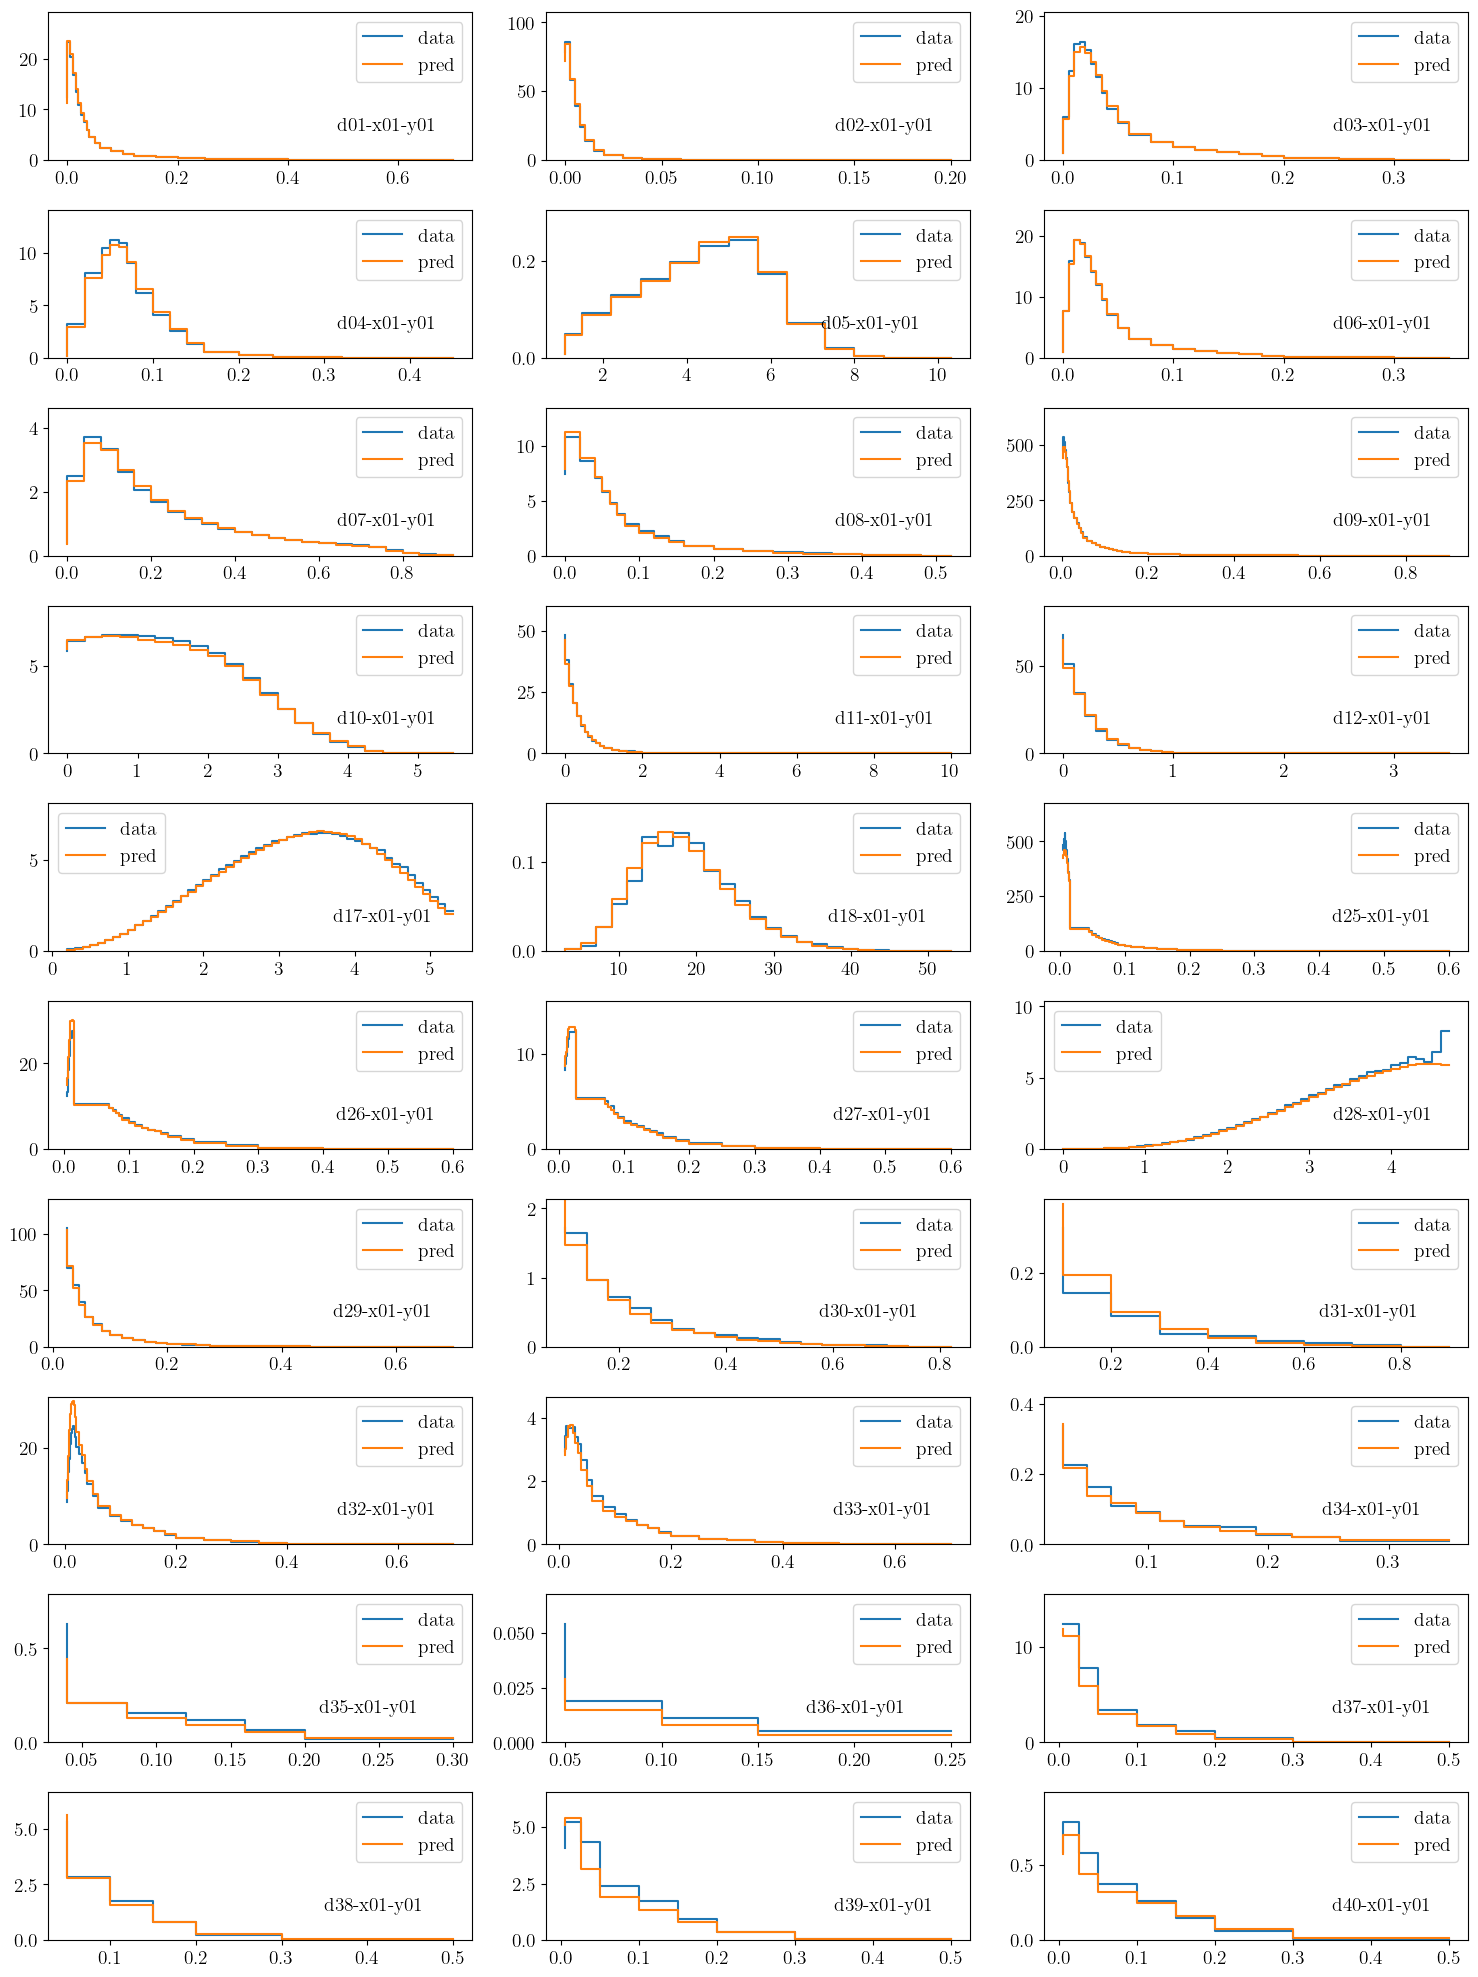

In [38]:
importlib.reload(pythia_SBI_utils)
from pythia_SBI_utils import * 

hists = make_hists(dfdata, dfsims_valid[0], filtered_data_keys, filtered_mc_keys)

plot_dist(filtered_data_keys, hists, filename='images/Ax_BayesianOpt_Valid_Best_fit_hists_ab_26_iter.pdf')